In [1]:
%autosave 180
%matplotlib inline

Autosaving every 180 seconds


In [2]:
import requests
import time
from datetime import datetime
import itertools as it
import re
#import numpy
from copy import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
#from pprint import pprint
import time
import json
import os
import networkx as nx
from math import sqrt
import spacy
from hdt import HDTDocument
import multiprocessing as mp
import torch
import random
from transformers import BertTokenizer, BertModel, BertForMaskedLM, GPT2Tokenizer, GPT2LMHeadModel

os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
from deepcorrect import DeepCorrect
corrector = DeepCorrect('data/deep_punct/deeppunct_params_en', 'data/deep_punct/deeppunct_checkpoint_wikipedia')

Using TensorFlow backend.


Loading the params file
Input encoding {'o': 2, '{': 3, '.': 4, 'J': 5, '0': 6, '1': 7, '<': 8, 'B': 9, 'd': 10, '£': 11, 'e': 12, '6': 13, '!': 14, 'O': 15, 'M': 16, 'X': 17, 'f': 18, 't': 19, 'C': 20, 'V': 21, 'z': 22, 'K': 23, '\\': 24, '9': 25, 'P': 26, 'S': 27, '/': 28, '₹': 29, 'F': 30, 'G': 31, '=': 32, '8': 33, ')': 34, '+': 35, ']': 36, 'U': 37, "'": 38, '"': 39, 'g': 40, 'N': 41, 'r': 42, 'u': 43, '&': 44, '$': 45, 'x': 46, '%': 47, ':': 48, '@': 49, '^': 50, 'I': 51, 'L': 52, 'Z': 53, 'h': 54, 'W': 55, 'A': 56, 'v': 57, '?': 58, '2': 59, '~': 60, 's': 61, 'T': 62, 'R': 63, ',': 64, '|': 65, '4': 66, '>': 67, 'y': 68, '(': 69, '[': 70, 'k': 71, 'H': 72, 'l': 73, 'j': 74, '7': 75, 'n': 76, 'i': 77, 'D': 78, 'Q': 79, ' ': 80, 'm': 81, 'Y': 82, '*': 83, '}': 84, '#': 85, 'p': 86, 'q': 87, '5': 88, 'c': 89, '`': 90, 'a': 91, 'b': 92, 'w': 93, '3': 94, 'E': 95, ';': 96, '-': 97}
Input decoding {2: 'o', 3: '{', 4: '.', 5: 'J', 6: '0', 7: '1', 8: '<', 9: 'B', 10: 'd', 11: '£', 12: '

In [3]:
print("Hi! My PID is",os.getpid())

Hi! My PID is 7086


In [4]:
hdt_wd = HDTDocument("data/kb/wikidata2018_09_11.hdt")

In [5]:
# Load pre-trained language models and tokenizers
#https://github.com/huggingface/transformers/blob/master/docs/source/pretrained_models.rst

bert_modelpath = "bert-large-uncased"
bert_model = BertForMaskedLM.from_pretrained(bert_modelpath)
bert_tokenizer = BertTokenizer.from_pretrained(bert_modelpath)

gpt2_modelpath = "gpt2-xl"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_modelpath)
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_modelpath)

In [6]:
#nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("/data/users/romain.claret/tm/wiki-kb-linked-entities/nlp_custom_6")
#print(nlp.pipeline)

In [7]:
# load settings
with open( "settings-graphqa.json", "r") as settings_data:
    settings = json.load(settings_data)
    use_cache = settings['use_cache']
    save_cache = settings['save_cache']
    cache_path = settings['cache_path']
#cache_path

In [8]:
save_cache = True
def save_cache_data(save_cache=save_cache):
    if save_cache:
        with open(os.path.join(cache_path,'wd_local_statements_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(wd_local_statements_dict, separators=(',',':')).encode('utf8'))
        with open(os.path.join(cache_path,'wd_labels_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(wd_labels_dict, separators=(',',':')).encode('utf8'))
        with open(os.path.join(cache_path,'wd_local_word_ids_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(wd_local_word_ids_dict, separators=(',',':')).encode('utf8'))
        with open(os.path.join(cache_path,'wd_online_word_ids_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(wd_online_word_ids_dict, separators=(',',':')).encode('utf8'))
        with open(os.path.join(cache_path,'wd_local_predicate_ids_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(wd_local_predicate_ids_dict, separators=(',',':')).encode('utf8'))
        with open(os.path.join(cache_path,'wd_online_predicate_ids_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(wd_online_predicate_ids_dict, separators=(',',':')).encode('utf8'))
        with open(os.path.join(cache_path,'word_similarities_dict.json'), 'wb') as outfile:
            outfile.write(json.dumps(word_similarities_dict, separators=(',',':')).encode('utf8'))
            


In [9]:
# Load statements cache
use_cache = True

def load_cache_data(use_cache=False):
    if use_cache:
        path_wd_local_statements_dict = "wd_local_statements_dict.json"
        path_wd_labels_dict = 'wd_labels_dict.json'
        path_wd_local_word_ids_dict = 'wd_local_word_ids_dict.json'
        path_wd_online_word_ids_dict = 'wd_online_word_ids_dict.json'
        path_wd_local_predicate_ids_dict = 'wd_local_predicate_ids_dict.json'
        path_wd_online_predicate_ids_dict = 'wd_online_predicate_ids_dict.json'
        path_word_similarities_dict = 'word_similarities_dict.json'
    else:
        path_wd_local_statements_dict = "wd_local_statements_dict_empty.json"
        path_wd_labels_dict = 'wd_labels_dict_empty.json'
        path_wd_local_word_ids_dict = 'wd_local_word_ids_dict_empty.json'
        path_wd_online_word_ids_dict = 'wd_online_word_ids_dict_empty.json'
        path_wd_local_predicate_ids_dict = 'wd_local_predicate_ids_dict_empty.json'
        path_wd_online_predicate_ids_dict = 'wd_online_predicate_ids_dict_empty.json'
        path_word_similarities_dict = 'word_similarities_dict_empty.json'

    with open(os.path.join(cache_path,path_wd_local_statements_dict), "rb") as data:
        wd_local_statements_dict = json.load(data)
    with open(os.path.join(cache_path,path_wd_labels_dict), "rb") as data:
        wd_labels_dict = json.load(data)
    with open(os.path.join(cache_path,path_wd_local_word_ids_dict), "rb") as data:
        wd_local_word_ids_dict = json.load(data)
    with open(os.path.join(cache_path,path_wd_online_word_ids_dict), "rb") as data:
        wd_online_word_ids_dict = json.load(data)
    with open(os.path.join(cache_path,path_wd_local_predicate_ids_dict), "rb") as data:
        wd_local_predicate_ids_dict = json.load(data)
    with open(os.path.join(cache_path,path_wd_online_predicate_ids_dict), "rb") as data:
        wd_online_predicate_ids_dict = json.load(data)
    with open(os.path.join(cache_path,path_word_similarities_dict), "rb") as data:
        word_similarities_dict = json.load(data)
        
    return (wd_local_statements_dict, wd_labels_dict,
            wd_local_word_ids_dict, wd_online_word_ids_dict,
            wd_local_predicate_ids_dict, wd_online_predicate_ids_dict,
            word_similarities_dict)
        
(wd_local_statements_dict, wd_labels_dict,
    wd_local_word_ids_dict, wd_online_word_ids_dict,
    wd_local_predicate_ids_dict, wd_online_predicate_ids_dict,
    word_similarities_dict) = load_cache_data(use_cache=True)

#print("wd_local_statements_dict",len(wd_local_statements_dict))
#print("wd_labels_dict",len(wd_labels_dict))
#print("wd_local_word_ids_dict",len(wd_local_word_ids_dict))
#print("wd_online_word_ids_dict",len(wd_online_word_ids_dict))
#print("wd_local_predicate_ids_dict",len(wd_local_predicate_ids_dict))
#print("wd_online_predicate_ids_dict",len(wd_online_predicate_ids_dict))
#print("word_similarities_dict",len(word_similarities_dict))


In [10]:
def get_kb_ents(text):
    #doc = nlp_kb(text)
    doc = nlp(text)
    #for ent in doc.ents:
    #    print(" ".join(["ent", ent.text, ent.label_, ent.kb_id_]))
    return doc.ents
        
#ent_text_test = (
#    "In The Hitchhiker's Guide to the Galaxy, written by Douglas Adams, "
#    "Douglas reminds us to always bring our towel, even in China or Brazil. "
#    "The main character in Doug's novel is the man Arthur Dent, "
#    "but Dougledydoug doesn't write about George Washington or Homer Simpson."
#)
#
#en_text_test_2 = ("Which actor voiced the Unicorn in The Last Unicorn?")
#
#print([ent.kb_id_ for ent in get_kb_ents(ent_text_test)])
#[ent.kb_id_ for ent in get_kb_ents(en_text_test_2)]

In [11]:
def get_nlp(sentence, autocorrect=False, banning_str=False):
    
    sentence = sentence.replace("’", "\'")
    nlp_sentence = nlp(sentence)
    nlp_sentence_list = list(nlp_sentence)
    meaningful_punct = []
    
    for i_t, t in enumerate(nlp_sentence_list):
        #print(t,t.pos_, t.lemma_)
        if t.lemma_ == "year":
            nlp_sentence_list[i_t] = "date"
        elif t.text == "\'s" or t.text == "s":
            if t.lemma_ == "be" or t.lemma_ == "s":
                nlp_sentence_list[i_t] = "is"
            else: nlp_sentence_list[i_t] = ""
        elif t.text == "\'ve" or t.text == "ve":
            if t.lemma_ == "have":
                nlp_sentence_list[i_t] = "have"
            else: nlp_sentence_list[i_t] = ""
        elif t.text == "\'re" or t.text == "re":
            if t.lemma_ == "be":
                nlp_sentence_list[i_t] = "are"
            else: nlp_sentence_list[i_t] = ""
        elif t.text == "\'ll" or t.text == "ll":
            if t.lemma_ == "will":
                nlp_sentence_list[i_t] = "will"
            else: nlp_sentence_list[i_t] = ""
        elif t.text == "\'d" or t.text == "d":
            if t.lemma_ == "have":
                nlp_sentence_list[i_t] = "had"
            elif t.lemma_ == "would":
                nlp_sentence_list[i_t] = "would"
            else: nlp_sentence_list[i_t] = ""   
        elif t.is_space:
            nlp_sentence_list[i_t] = ""
        elif t.pos_ == "PUNCT":
            if t.text.count(".") > 2:
                meaningful_punct.append((i_t,"..."))
                nlp_sentence_list[i_t] = "..."
            else:
                nlp_sentence_list[i_t] = ""
        else: nlp_sentence_list[i_t] = nlp_sentence_list[i_t].text
    
    nlp_sentence_list = [w for w in nlp_sentence_list if w]
    
    #print("nlp_sentence_list",nlp_sentence_list)
    
    if autocorrect:
        nlp_sentence = " ".join(nlp_sentence_list)
        nlp_sentence = (nlp_sentence.replace("’", "\'").replace("€", "euro").replace("ç", "c")
                        .replace("à", "a").replace("é","e").replace("ä","a").replace("ö","o")
                        .replace("ü","u").replace("è","e").replace("¨","").replace("ê","e")
                        .replace("â","a").replace("ô","o").replace("î","i").replace("û","u")
                        .replace("_"," ").replace("°","degree").replace("§","section")
                        .replace("š","s").replace("Š","S").replace("ć","c").replace("Ç", "C")
                        .replace("À", "A").replace("É","E").replace("Ä","A").replace("Ö","O")
                        .replace("Ü","U").replace("È","E").replace("Ê","E").replace("Ë","E")
                        .replace("Â","A").replace("Ô","O").replace("Î","I").replace("Û","U")
                        .replace("á","a").replace("Á","Á").replace("ó","o").replace("Ó","O")
                        .replace("ú","u").replace("Ú","U").replace("í","i").replace("Í","I")
                        .replace("–","-").replace("×","x").replace("“","\"").replace("ř","r")
                        .replace("ø","o").replace("ı","i").replace("ş","s").replace("Á","A")
                        .replace("Ō","O").replace("ã","a").replace("ū","u").replace("ō","o")
                        .replace("ñ","n").replace("Ł","L").replace("ł","l").replace("Ñ","N")
                        .replace("Ō","O").replace("Ā","A").replace("ē","e").replace("ǟ","a")
                        .replace("ȱ","o").replace("ō","o").replace("ȭ","o").replace("ī","i")
                        .replace("ū","u").replace("ȯ","o").replace("ä","a").replace("õ","o")
                        .replace("Ā","A").replace("ū","u").replace("ī","i").replace("ē","e")
                        .replace("ō","o").replace("Ā","A").replace("ā","a").replace("Ǟ","A")
                        .replace("ǟ","a").replace("Ḇ","B").replace("ḇ","b").replace("C̄","C")
                        .replace("c̄","c").replace("Ḏ","D").replace("ḏ","d").replace("ḕ","e")
                        .replace("Ē","E").replace("ē","e").replace("Ḕ","E").replace("Ḗ","E")
                        .replace("ḗ","e").replace("Ḡ","G").replace("ḡ","g").replace("ẖ","h")
                        .replace("Ī","ī").replace("Ḹ","L").replace("ḹ","l").replace("Ḻ","L")
                        .replace("ḻ","l").replace("Ṉ","N").replace("ṉ","n").replace("Ȫ","O")
                        .replace("ȫ","o").replace("Ṑ","O").replace("ṑ","o").replace("ß","ss")
                        .replace("Ṓ","O").replace("ṓ","o").replace("Ṝ","R").replace("ṝ","r")
                        .replace("Ṟ","R").replace("ṟ","r").replace("Ṯ","T").replace("ṯ","t")
                        .replace("Ū","U").replace("ū","u").replace("Ǘ","U").replace("ǘ","u")
                        .replace("Ǖ","U").replace("ǖ","u").replace("Ṻ","U").replace("ṻ","u")
                        .replace("Ȳ","Y").replace("ȳ","y").replace("ẕ","z").replace("Ẕ","Z")
                        .replace("Ǣ","AE").replace("ǣ","ae").replace("ė","e").replace("å","a")
                        .replace("æ","ae").replace("Æ","AE").replace("ą","a").replace("ț","t")
                        .replace("ï","i").replace("Ț","T").replace("İ","I").replace("ʻ","\'")
                        .replace("ń","n").replace("Ń","N").replace("Č","C").replace("ø","o")
                        .replace("č","c").replace("ž","z").replace("Ž","Z").replace("Ø","O")
                        .replace("ễ","e").replace("Ê","E").replace("ă","a").replace("Ă","A")
                        .replace("ệ","e").replace("Ş","S").replace("ş","s").replace("～"," ")
                        .replace("œ","oe").replace("Œ","OE").replace("ě","e").replace("Ě","E")
                        .replace("đ","d").replace("Đ","D").replace("Я","R").replace("я","r")
                        .replace("ý","y").replace("Ý","Y").replace("Ż","Z").replace("ż","z")
                        .replace("ș","s").replace("¡","i").replace("´","\'").replace("Ș","S")
                        .replace("ò","o").replace("Ò","O").replace("ë","e")
                       )
        
        if banning_str:
            for ban in banning_str:
                nlp_sentence = nlp_sentence.replace(ban[0],ban[1])
            
        nlp_sentence = corrector.correct(nlp_sentence)
        nlp_sentence = nlp_sentence[0]["sequence"]
    
        nlp_sentence = nlp(nlp_sentence)
        nlp_sentence_list = list(nlp_sentence)

        for i_t, t in enumerate(nlp_sentence_list):
            if t.pos_ == "PUNCT":
                if i_t in [mpunct[0] for mpunct in meaningful_punct]:
                    for mpunct in meaningful_punct:
                        if i_t == mpunct[0]:
                            nlp_sentence_list[mpunct[0]] = mpunct[1]
                else: nlp_sentence_list[i_t] = ''

            else:
                nlp_sentence_list[i_t] = nlp_sentence_list[i_t].text

        for mpunct in meaningful_punct:
            if mpunct[0] < len(nlp_sentence_list):
                if nlp_sentence_list[mpunct[0]] != mpunct[1]:
                    nlp_sentence_list.insert(mpunct[0], mpunct[1])
        
    return nlp(" ".join(nlp_sentence_list).replace("  ", " ").replace(". &",".").replace("/",""))


#get_nlp("Which genre of album is harder.....faster?", autocorrect=True)
#get_nlp("Which genre of album is Harder ... Faster", autocorrect=True)
#get_nlp("Which home is an example of italianate architecture?", autocorrect=True)
#get_nlp("Your mom's father, were nice in the Years.!?\'\":`’^!$£€\(\)ç*+%&/\\\{\};,àéäöüè¨êâôîû~-_<>°§...@.....", autocorrect=True)
#get_nlp("of what nationality is ken mcgoogan", autocorrect=True)
#get_nlp("you're fun", autocorrect=True)
#get_nlp("where's the fun", autocorrect=True)
#get_nlp("whats the name of the organization that was founded by  frei otto", True)
#get_nlp("Hurry! We’re late!",True)
#get_nlp("Who was an influential figure for miško Šuvaković",True)
#get_nlp("what is the second level division of the division crixás do tocantins",True)
#get_nlp("what is the second level division of the division crixás do tocantins",True)
#get_nlp("2×4",autocorrect=True,banning_str=[["×","x"]])
#get_nlp("what types of music is p.a.r.c.e.",autocorrect=True)


In [12]:
def is_wd_entity(to_check):
    pattern = re.compile('^Q[0-9]*$')
    if pattern.match(to_check.strip()): return True
    else: return False

def is_wd_predicate(to_check):
    pattern = re.compile('^P[0-9]*$')
    if pattern.match(to_check.strip()): return True
    else: return False
    
def is_valide_wd_id(to_check):
    if is_wd_entity(to_check) or is_wd_predicate(to_check): return True
    else: return False

#print(is_wd_entity("Q155"))

In [13]:
# TODO redo the functions and optimize

def is_entity_or_literal(to_check):
    if is_wd_entity(to_check.strip()):
        return True
    pattern = re.compile('^[A-Za-z0-9]*$')
    if len(to_check) == 32 and pattern.match(to_check.strip()):
        return False
    return True

# return if the given string is a literal or a date
def is_literal_or_date(to_check): 
    return not('www.wikidata.org' in to_check)

# return if the given string describes a year in the format YYYY
def is_year(year):
    pattern = re.compile('^[0-9][0-9][0-9][0-9]$')
    if not(pattern.match(year.strip())):
        return False
    else:
        return True

# return if the given string is a date
def is_date(date):
    pattern = re.compile('^[0-9]+ [A-z]+ [0-9][0-9][0-9][0-9]$')
    if not(pattern.match(date.strip())):
        return False
    else:
        return True

# return if the given string is a timestamp
def is_timestamp(timestamp):
    pattern = re.compile('^[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]T00:00:00Z')
    if not(pattern.match(timestamp.strip())):
        return False
    else:
        return True

# convert the given month to a number
def convert_month_to_number(month):
    return{
        "january" : "01",
        "february" : "02",
        "march" : "03",
        "april" : "04",
        "may" : "05",
        "june" : "06",
        "july" : "07",
        "august" : "08",
        "september" : "09", 
        "october" : "10",
        "november" : "11",
        "december" : "12"
    }[month.lower()]

# convert a date from the wikidata frontendstyle to timestamp style
def convert_date_to_timestamp (date):
    sdate = date.split(" ")
    # add the leading zero
    if (len(sdate[0]) < 2):
        sdate[0] = "0" + sdate[0]
    return sdate[2] + '-' + convert_month_to_number(sdate[1]) + '-' + sdate[0] + 'T00:00:00Z'

# convert a year to timestamp style
def convert_year_to_timestamp(year):
    return year + '-01-01T00:00:00Z'

# get the wikidata id of a wikidata url
def wikidata_url_to_wikidata_id(url):
    if not url:
        return False
    if "XMLSchema#dateTime" in url or "XMLSchema#decimal" in url:
        date = url.split("\"", 2)[1]
        date = date.replace("+", "")
        return date
    if(is_literal_or_date(url)):
        if is_year(url):
            return convert_year_to_timestamp(url)
        if is_date(url):
            return convert_date_to_timestamp(url)
        else:
            url = url.replace("\"", "")
            return url
    else:
        url_array = url.split('/')
        # the wikidata id is always in the last component of the id
        return url_array[len(url_array)-1]
    
# fetch all statements where the given qualifier statement occurs as subject
def get_all_statements_with_qualifier_as_subject(qualifier):
    statements = []
    triples, cardinality = hdt_wd.search_triples(qualifier, "", "")
    for triple in triples:
        sub, pre, obj = triple
        # only consider triples with a wikidata-predicate
        if pre.startswith("http://www.wikidata.org/"):
            statements.append({'entity': sub, 'predicate': pre, 'object': obj})
    return statements

# fetch the statement where the given qualifier statement occurs as object
def get_statement_with_qualifier_as_object(qualifier):
    triples, cardinality = hdt_wd.search_triples("", "", qualifier)
    for triple in triples:
        sub, pre, obj = triple
        # only consider triples with a wikidata-predicate
        if pre.startswith("http://www.wikidata.org/") and sub.startswith("http://www.wikidata.org/entity/Q"):
            return (sub, pre, obj)
    return False

# returns all statements that involve the given entity
def get_all_statements_of_entity(entity_id):
    # check entity pattern
    if not is_wd_entity(entity_id.strip()):
        return False
    if wd_local_statements_dict.get(entity_id) != None:
        #print("saved statement")
        return wd_local_statements_dict[entity_id]
    entity = "http://www.wikidata.org/entity/"+entity_id
    statements = []
    # entity as subject
    triples_sub, cardinality_sub = hdt_wd.search_triples(entity, "", "")
    # entity as object
    triples_obj, cardinality_obj = hdt_wd.search_triples("", "", entity)
    if cardinality_sub + cardinality_obj > 5000:
        wd_local_statements_dict[entity_id] = []
        return []
    # iterate through all triples in which the entity occurs as the subject
    for triple in triples_sub:
        sub, pre, obj = triple
        # only consider triples with a wikidata-predicate or if it is an identifier predicate
        if not pre.startswith("http://www.wikidata.org/"):# or (wikidata_url_to_wikidata_id(pre) in identifier_predicates):
            continue
        # object is statement
        if obj.startswith("http://www.wikidata.org/entity/statement/"):
            qualifier_statements = get_all_statements_with_qualifier_as_subject(obj)
            qualifiers = []
            for qualifier_statement in qualifier_statements:
                if qualifier_statement['predicate'] == "http://www.wikidata.org/prop/statement/" + wikidata_url_to_wikidata_id(pre):
                        obj = qualifier_statement['object']
                elif is_entity_or_literal(wikidata_url_to_wikidata_id(qualifier_statement['object'])):
                    qualifiers.append({
                        "qualifier_predicate":{
                            "id": wikidata_url_to_wikidata_id(qualifier_statement['predicate'])
                        }, 
                        "qualifier_object":{
                            "id": wikidata_url_to_wikidata_id(qualifier_statement['object'])
                        }})
            statements.append({'entity': {'id': wikidata_url_to_wikidata_id(sub)}, 'predicate': {'id': wikidata_url_to_wikidata_id(pre)}, 'object': {'id': wikidata_url_to_wikidata_id(obj)}, 'qualifiers': qualifiers})
        else:
            statements.append({'entity': {'id': wikidata_url_to_wikidata_id(sub)}, 'predicate': {'id': wikidata_url_to_wikidata_id(pre)}, 'object': {'id': wikidata_url_to_wikidata_id(obj)}, 'qualifiers': []})
    # iterate through all triples in which the entity occurs as the object
    for triple in triples_obj:
        sub, pre, obj = triple
        # only consider triples with an entity as subject and a wikidata-predicate or if it is an identifier predicate
        if not sub.startswith("http://www.wikidata.org/entity/Q"):# or not pre.startswith("http://www.wikidata.org/") or wikidata_url_to_wikidata_id(pre) in identifier_predicates:
            continue
        if sub.startswith("http://www.wikidata.org/entity/statement/"):
            statements_with_qualifier_as_object =  get_statement_with_qualifier_as_object(sub, process)
            # if no statement was found continue
            if not statements_with_qualifier_as_object:
                continue
            main_sub, main_pred, main_obj = statements_with_qualifier_as_object
            qualifier_statements = get_all_statements_with_qualifier_as_subject(sub)
            qualifiers = []
            for qualifier_statement in qualifier_statements:
                if wikidata_url_to_wikidata_id(qualifier_statement['predicate']) == wikidata_url_to_wikidata_id(main_pred):
                    main_obj = qualifier_statement['object']
                elif is_entity_or_literal(wikidata_url_to_wikidata_id(qualifier_statement['object'])):
                    qualifiers.append({
                        "qualifier_predicate":{"id": wikidata_url_to_wikidata_id(qualifier_statement['predicate'])}, 
                        "qualifier_object":{"id": wikidata_url_to_wikidata_id(qualifier_statement['object'])}
                    })
            statements.append({
                            'entity': {'id': wikidata_url_to_wikidata_id(main_sub)},
                            'predicate': {'id': wikidata_url_to_wikidata_id(main_pred)},
                            'object': {'id': wikidata_url_to_wikidata_id(main_obj)},
                            'qualifiers': qualifiers
                              })
        else:
            statements.append({'entity': {'id': wikidata_url_to_wikidata_id(sub)}, 'predicate': {'id': wikidata_url_to_wikidata_id(pre)}, 'object': {'id': wikidata_url_to_wikidata_id(obj)}, 'qualifiers': []})
    # cache the data
    wd_local_statements_dict[entity_id] = statements
    return statements

#print(len(get_all_statements_of_entity("Q267721")))
#for s in get_all_statements_of_entity("Q267721"):
#    print(s)
#save_cache_data(save_cache=save_cache)

In [14]:
def get_wd_ids_online(name, is_predicate=False, top_k=3, sim_threshold=0.5):
    name = name.split('(')[0]
    
    if is_predicate and wd_online_predicate_ids_dict.get(name) != None and use_cache and len(wd_online_predicate_ids_dict)>0:
        res_ids = wd_online_predicate_ids_dict[name][:top_k]
        to_return = []
        for res_id in res_ids:
            if get_nlp(get_wd_label(res_id)).similarity(get_nlp(name)) >= sim_threshold:
                to_return.append(res_id)
        return to_return #wd_online_predicate_ids_dict[name][:top_k]
    
    elif not is_predicate and wd_online_word_ids_dict.get(name) != None and use_cache and len(wd_online_word_ids_dict)>0:
        #print("saved word online")
        res_ids = wd_online_word_ids_dict[name][:top_k]
        to_return = []
        for res_id in res_ids:
            if get_nlp(get_wd_label(res_id)).similarity(get_nlp(name)) >= sim_threshold:
                to_return.append(res_id)
        return to_return #wd_online_word_ids_dict[name][:top_k]

    request_successfull = False
    entity_ids = ""
    while not request_successfull:
        try:
            if is_predicate:
                entity_ids = requests.get('https://www.wikidata.org/w/api.php?action=wbsearchentities&format=json&language=en&type=property&limit=' + str(top_k) + '&search='+name).json()
            else:
                entity_ids = requests.get('https://www.wikidata.org/w/api.php?action=wbsearchentities&format=json&language=en&limit=' + str(top_k) + '&search='+name).json()
            request_successfull = True
        except Exception as e:
            print("ERROR:",e)
            time.sleep(5)
    results = entity_ids.get("search")
    if not results:
        if is_predicate: wd_online_predicate_ids_dict[name] = [] 
        else: wd_online_word_ids_dict[name] = [] 
        return []
    if not len(results):
        if is_predicate: wd_online_predicate_ids_dict[name] = [] 
        else: wd_online_word_ids_dict[name] = []
        return [] 
    res = []
    for result in results:
        res_id = result['id']
        #print(res_id,get_nlp(get_wd_label(res_id)).similarity(get_nlp(name)))
        if get_nlp(get_wd_label(res_id)).similarity(get_nlp(name)) >= sim_threshold:
            res.append(res_id)
            
    
    if is_predicate: wd_online_predicate_ids_dict[name] = res
    else: wd_online_word_ids_dict[name] = res
    
    if res:
        return res[:top_k]
    else:
        return []

#print(get_wd_ids_online("did", is_predicate=False, top_k=3))
#print(get_wd_ids_online("voiced", is_predicate=True, top_k=3))


In [15]:
# very computational
def get_most_similar(word, top_k=3):
    BANNED_WORDS = ["benteen"]
    if word in BANNED_WORDS:
        return []
    
    print("behold: get_most_similar started with:", word)
    word_text = str(word.lower())
    if word_similarities_dict.get(word) != None and use_cache and len(word_similarities_dict)>0:
        return word_similarities_dict[word][:top_k]
    
    word = nlp.vocab[word_text]
    queries = [w for w in word.vocab if w.is_lower == word.is_lower and w.prob >= -15]
    if len(queries) > 32994:
        return []
    
    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    
    word_similarities = [(w.text.lower(),float(w.similarity(word))) for w in by_similarity[:10] if w.lower_ != word.lower_]

    word_similarities_dict[word_text] = word_similarities
    
    save_cache_data(save_cache=save_cache)
    
    return word_similarities[:top_k]

#print(get_most_similar("dog", top_k=3))
#save_cache_data(save_cache=save_cache)

In [122]:
def get_wd_ids(word, is_predicate=False, top_k=3, limit=6, online=False, sim_threshold=0.5):
    #if is_predicate and wd_local_predicate_ids_dict.get(word) != None and use_cache and len(wd_local_predicate_ids_dict)>0:
    #    #print("saved predicate local")
    #    res_ids = wd_local_predicate_ids_dict[word][:top_k]
    #    to_return = []
    #    for res_id in res_ids:
    #        if get_nlp(get_wd_label(res_id)).similarity(get_nlp(word)) >= sim_threshold:
    #            to_return.append(res_id)
    #    return to_return #wd_local_predicate_ids_dict[word][:top_k]
    #
    #elif not is_predicate and wd_local_word_ids_dict.get(word) != None and use_cache and len(wd_local_word_ids_dict)>0:
    #    #print("saved word local")
    #    res_ids = wd_local_word_ids_dict[word][:top_k]
    #    to_return = []
    #    for res_id in res_ids:
    #        if get_nlp(get_wd_label(res_id)).similarity(get_nlp(word)) >= sim_threshold:
    #            to_return.append(res_id)
    #    return to_return #wd_local_word_ids_dict[word][:top_k]
    
    language = "en"
    word_formated = str("\""+word+"\""+"@"+language)
    to_remove = len("http://www.wikidata.org/entity/")
    t_name, card_name = hdt_wd.search_triples("", "http://schema.org/name", word_formated, limit=top_k)
    #print("names cardinality of \"" + word+"\": %i" % card_name)
    t_alt, card_alt = hdt_wd.search_triples("", 'http://www.w3.org/2004/02/skos/core#altLabel', word_formated, limit=top_k)
    #print("alternative names cardinality of \"" + word+"\": %i" % card_alt)
    results = list(set(
        [t[0][to_remove:] for t in t_name if is_valide_wd_id(t[0][to_remove:])] + 
        [t[0][to_remove:] for t in t_alt if is_valide_wd_id(t[0][to_remove:])]
           ))
    
    res = []
    for result in results:
        #print(result,get_nlp(get_wd_label(result)).similarity(get_nlp(word)))
        if get_nlp(get_wd_label(result)).similarity(get_nlp(word)) >= sim_threshold:
            res.append(result)
    
    if is_predicate: res = [r for r in res if is_wd_predicate(r)]
        
    # cache the data
    if is_predicate: wd_local_predicate_ids_dict[word] = res
    else: wd_local_word_ids_dict[word] = res
    
    #print("res",res)
    #print("limit",limit)
    if limit<=0:
        #print("if limit<=0",top_k)
        return res[:top_k]
    else:
        #print("else limit<=0",limit)
        if limit-1>=0: return res[:limit-1]
        else: return res[:limit]

#print(get_wd_ids("did", is_predicate=False, top_k=1))
#get_wd_ids("The Last Unicorn", is_predicate=False,top_k=0, limit=10)
#print(get_wd_ids("wife", is_predicate=False , top_k=0, limit=0))
#print(get_wd_ids("voiced", is_predicate=True , top_k=0, limit=0))

In [123]:
def get_wd_label(from_id, language="en"):
    #print("from_id",from_id)
    if is_valide_wd_id(from_id):
        if wd_labels_dict.get(from_id) != None and use_cache and len(wd_labels_dict)>0:
            #print("saved label local")
            return wd_labels_dict[from_id]
        
        id_url = "http://www.wikidata.org/entity/"+from_id
        t_name, card_name = hdt_wd.search_triples(id_url, "http://schema.org/name", "")
        name = [t[2].split('\"@'+language)[0].replace("\"", "") for t in t_name if "@"+language in t[2]]
        #name = [t[2].split('@en')[0] for t in t_name if "@"+language in t[2]]
        result = name[0] if name else ''
        wd_labels_dict[from_id] = result #caching
        return result
        
    else:
        return from_id
    
#print(get_wd_label("P725"))
#get_wd_label("Q20789322")
#get_wd_label("Q267721")

In [124]:
# Building colors from graph
def get_color(node_type):
    if node_type == "entity": return "violet"#"cornflowerblue"
    elif node_type == "predicate": return "yellow"
    else: return "red"

# Building labels for graph
def get_elements_from_graph(graph):
    node_names = nx.get_node_attributes(graph,"name")
    node_types = nx.get_node_attributes(graph,"type")
    colors = [get_color(node_types[n]) for n in node_names]
    return node_names, colors

# Plotting the graph
def plot_graph(graph, name, title="Graph"):
    fig = plt.figure(figsize=(14,14))
    ax = plt.subplot(111)
    ax.set_title(str("answer: "+title), fontsize=10)
    #pos = nx.spring_layout(graph)
    labels, colors = get_elements_from_graph(graph)
    nx.draw(graph, node_size=30, node_color=colors, font_size=10, font_weight='bold', with_labels=True, labels=labels)
    plt.tight_layout()
    plt.savefig("tmqa1_graphs_imgs/"+str(name)+".png", format="PNG", dpi = 300)
    plt.show()
    
#plot_graph(graph, "file_name_graph", "Graph_title")

In [125]:
def make_statements_graph_worker(graph, predicate_nodes, turn, indexing_predicates, BANNED_WD_IDS, BANNED_WD_PRED_IDS, BANNED_WD_KEYWORDS, BANNED_WD_PRED_KEYWORDS, in_mp_queue, out_mp_queue, predicate_nodes_lock, node_weight, qa):
    #for statement in statements:
    sentinel = None
    
    for statement in iter(in_mp_queue.get, sentinel):
        #print("statement",statement)
        #if (statement['entity']['id'][0] != "Q"
        #    or statement['entity']['id'] in BANNED_WD_IDS
        #    or statement['predicate']['id'][0] != "P"
        #    or statement['predicate']['id'] in BANNED_WD_PRED_IDS
        #    or statement['object']['id'][0] != "Q"
        #    or statement['object']['id'] in BANNED_WD_IDS):
        #    continue
            
        if (
            statement['entity']['id'] in BANNED_WD_IDS
            or statement['predicate']['id'][0] != "P"
            or statement['predicate']['id'] in BANNED_WD_PRED_IDS
            or statement['object']['id'] in BANNED_WD_IDS
            ):
            continue
        
        continue_flag = False
        for key in BANNED_WD_PRED_KEYWORDS:
            if (get_wd_label(statement['predicate']['id']).find(key) != -1): continue_flag = True
                
        for key in BANNED_WD_KEYWORDS:
            if (get_wd_label(statement['entity']['id']).find(key) != -1): continue_flag = True
            if (get_wd_label(statement['object']['id']).find(key) != -1): continue_flag = True
                
        if continue_flag: continue
        
        #print(statement)
        if not statement['entity']['id'] in graph:
            graph.add_node(statement['entity']['id'], name=get_wd_label(statement['entity']['id']), type='entity', turn=turn, weight=node_weight, qa=qa)
        if not statement['object']['id'] in graph:
            graph.add_node(statement['object']['id'], name=get_wd_label(statement['object']['id']), type='entity', turn=turn, weight=node_weight, qa=qa)
        
        with predicate_nodes_lock:
            # increment index of predicate or set it at 0
            if not statement['predicate']['id'] in predicate_nodes or not indexing_predicates:
                predicate_nodes_index = 1
                predicate_nodes[statement['predicate']['id']] = 1
            else:
                predicate_nodes[statement['predicate']['id']] += 1
                predicate_nodes_index = predicate_nodes[statement['predicate']['id']]

        # add the predicate node
        predicate_node_id = (statement['predicate']['id'])
        if indexing_predicates: predicate_node_id += "-" + str(predicate_nodes_index)
        
        graph.add_node(predicate_node_id, name=get_wd_label(statement['predicate']['id']), type='predicate', turn=turn, weight=node_weight)

        # add the two edges (entity->predicate->object)
        #statement['entity']['id'] in BANNED_WD_IDS 
        #statement['object']['id'] in BANNED_WD_IDS
        #statement['predicate']['id'] in BANNED_WD_PRED_IDS
        #if (statement['predicate']['id'] in BANNED_WD_PRED_IDS): break
            
        graph.add_edge(statement['entity']['id'], predicate_node_id)
        graph.add_edge(predicate_node_id, statement['object']['id'])
        
    out_mp_queue.put(graph)

In [20]:
# TODO: handle special literals? which one

def make_statements_graph(statements, indexing_predicates=True, potential_predicates=False, cores=mp.cpu_count(), context_graph=False, node_weight=1, qa=False, max_deepness=3):
    BANNED_WD_IDS = [
        "Q4167410","Q66087861","Q65932995","Q21281405","Q17442446","Q41770487","Q29548341",
        "Q29547399","Q25670","Q21286738"
    ]
    BANNED_WD_PRED_IDS = [
        "P1687","P7087","P1889","P646", "P227", "P1256", "P1257", "P1258", "P1260", "P301",
        "P18","P1266","P487","P1970","P2529", "P4390", "P4342", "P4213", "P487", "P2624",
        "P4953", "P2241", "P345","P703", "P2163", "P18", "P436", "P227", "P646", "P2581",
        "P1006", "P244", "P214", "P1051", "P1296","P461", "P2959", "P1657", "P3834","P243",
        "P3306","P6932","P356","P1630","P3303","P1921","P1793","P1628","P1184","P1662","P2704",
        "P4793","P1921","P2302","P6562","P6127","P4342","P6145","P5786","P5099","P4947","P5032",
        "P4933","P4632","P4529","P4277","P4282","P3135","P4276","P3593","P2638","P3804","P3145",
        "P2509","P3212","P2704","P480","P3844","P3141","P3808","P3933","P2346","P3077","P3417",
        "P2529","P3302","P3143","P2334","P3129","P3138","P3107","P2603","P2631","P2508","P2465",
        "P2014", "P1874", "P2518", "P1265", "P1237","P1712", "P1970","P1804","P905","P1562",
        "P1258","P646","P345",'http://www.w3.org/2002/07/owl#sameAs'
    ]
    BANNED_WD_KEYWORDS = ["_:"]
    BANNED_WD_PRED_KEYWORDS = [
        "ID", "ISBN","Identifier","identifier", "IDENTIFIER", "isbn", "ISSN", "issn","id","Id","iD","ISNI"
    ]
    
    predicate_nodes = mp.Manager().dict()
    predicate_nodes_lock = mp.Manager().Lock()
        
    if context_graph:
        latest_turn = sorted([y["turn"] for x,y in context_graph.nodes(data=True)])[-1]
        turn = latest_turn+1
        graph = context_graph.copy()
        
        previous_predicates_ids = [x for x,y in context_graph.nodes(data=True) if y["type"]=="predicate"]
        
        if previous_predicates_ids:
            if previous_predicates_ids[0].find("-") != -1:
                for ppi in previous_predicates_ids:
                    ppi_id = ppi[:ppi.find("-")]
                    ppi_value = ppi[ppi.find("-")+1:]

                    if ppi_id in predicate_nodes:
                        if int(ppi_value) > predicate_nodes[ppi_id]:
                            predicate_nodes[ppi_id] = int(ppi_value)
                    else:
                        predicate_nodes[ppi_id] = int(ppi_value)
        
        #print("predicate_nodes from context",predicate_nodes.keys())
        
    else:
        turn=1
        graph = nx.Graph()
    
      
    
    if cores <= 0: cores = 1

    out_mp_queue = mp.Queue()
    in_mp_queue = mp.Queue()
    sentinel = None

    for statement in statements:
        in_mp_queue.put(statement)

    procs = [mp.Process(target = make_statements_graph_worker, args = (graph, predicate_nodes, turn, indexing_predicates, BANNED_WD_IDS, BANNED_WD_PRED_IDS, BANNED_WD_KEYWORDS, BANNED_WD_PRED_KEYWORDS, in_mp_queue, out_mp_queue, predicate_nodes_lock, node_weight, qa)) for i in range(cores)]

    for proc in procs:
        proc.daemon = True
        proc.start()
    for proc in procs:    
        in_mp_queue.put(sentinel)
    for proc in procs:
        local_g = out_mp_queue.get()
        graph = nx.compose(graph,local_g)
    for proc in procs:
        proc.join()
    
    if context_graph:
        previous_entities_ids = [x for x,y in context_graph.nodes(data=True) if y["type"]=="entity"]
        #print("previous_entities_ids",previous_entities_ids)
        
        for n in graph.copy().nodes():
            is_entity_present = [nx.has_path(graph, n, pei) for pei in previous_entities_ids if graph.has_node(pei)]
            #print("is_entity_present for n",n,is_entity_present)

            if not any(iep for iep in is_entity_present):
                graph.remove_node(n)
            else:
                shortest_paths = [nx.shortest_path(graph, n, pei) for pei in previous_entities_ids if graph.has_node(pei)]
                #print("shortest_paths",shortest_paths)
                shortest_paths_len = [len(sp) for sp in shortest_paths]
                #print("shortest_paths_len",shortest_paths_len)
                if not any((spl <= max_deepness and spl>1) for spl in shortest_paths_len):
                    graph.remove_node(n)
                    #print("Any is smaller than max_deepness")
                #else:
                    #print("None is smaller than max_deepness")
            
            #if previous_predicates_ids
                    
        #print("1 len(graph)",len(graph))        
        
        if previous_predicates_ids:
            if previous_predicates_ids[0].find("-") != -1:
                previous_predicates_ids_only = [p[:p.find("-")] for p in previous_predicates_ids]
            else:
                previous_predicates_ids_only = previous_predicates_ids
        else: previous_predicates_ids_only=[]
            
        #print("previous_predicates_ids",previous_predicates_ids)
        #print("previous_predicates_ids_only",previous_predicates_ids_only)
        
    
        spo_list = [[list(graph.neighbors(p))[0],p[:p.find("-")],list(graph.neighbors(p))[1]] for p in previous_predicates_ids]
        spo_list_tagged = [[list(graph.neighbors(p))[0],p,list(graph.neighbors(p))[1]] for p in previous_predicates_ids]
        
        for spo in spo_list_tagged:
            #print("graph.nodes(data=True)",graph.nodes(data=True))
            #print("before spo weights",spo,graph.nodes[spo[0]]['weight'],graph.nodes[spo[1]]['weight'],graph.nodes[spo[2]]['weight'])
            graph.nodes[spo[0]]['weight'] += 1
            graph.nodes[spo[1]]['weight'] += 1
            graph.nodes[spo[2]]['weight'] += 1
            #print("after spo weights",spo,graph.nodes[spo[0]]['weight'],graph.nodes[spo[1]]['weight'],graph.nodes[spo[2]]['weight'])
        
        for p in [x for x,y in graph.nodes(data=True) if y["type"]=="predicate"]:
            p_n = list(graph.neighbors(p))
            if p.find("-") != -1:
                p_id = p[:p.find("-")]
                p_value = p[p.find("-")+1:]
            else:
                p_id = p
                p_value = 0
            
            if len(p_n) > 1: spo_tuple = [p_n[0],p_id,p_n[1]]
            else: spo_tuple = []

            if spo_tuple not in spo_list and spo_tuple:
                spo_list.append(spo_tuple)
            else:
                if p not in previous_predicates_ids:
                    graph.remove_node(p)
        #print("2 len(graph)",len(graph))              
        for spo in spo_list:
            if spo[1] in previous_predicates_ids_only:
                if spo[0] not in previous_entities_ids and spo[2] not in previous_entities_ids:
                    bad_paths = [p for p in nx.all_shortest_paths(graph, source=spo[0], target=spo[2]) if p[1][:p[1].find("-")] == spo[1]]
                    for bp in bad_paths:
                        graph.remove_node(bp[1])
        #print("3 len(graph)",len(graph))  
        local_main_themes=[]
        for p in [x for x,y in graph.nodes(data=True) if y["type"]=="entity"]:
            if len(list(graph.neighbors(p)))>2: local_main_themes.append(p)
        
        meaningful_paths = []
        #for t in [x for x,y in graph.nodes(data=True) if y["type"]=="entity"]:
        for t in local_main_themes:
            statements = get_all_statements_of_entity(t)
            if not statements:
                continue
            for statement in statements:
                tmp_statement_basic = []
                s_entity = statement["entity"]['id']
                if t!=s_entity:
                    continue
                s_predicate = statement["predicate"]['id']
                s_object = statement["object"]['id']
                s_qualifiers = statement["qualifiers"]
                tmp_statement_basic = [s_entity, s_predicate, s_object]
                tmp_statement_qualifier = []
                if s_qualifiers:
                    for s_qualifier in s_qualifiers:
                        s_qual_predicate = s_qualifier["qualifier_predicate"]['id']
                        s_qual_object = s_qualifier["qualifier_object"]['id']
                        tmp_statement_qualifier = tmp_statement_basic+[s_qual_predicate,s_qual_object]
                        if tmp_statement_qualifier[2] in local_main_themes:
                            meaningful_paths.append(tmp_statement_qualifier)
                        if tmp_statement_qualifier[4] in local_main_themes:
                            meaningful_paths.append(tmp_statement_qualifier)

                if not tmp_statement_qualifier:
                    if tmp_statement_basic[2] in local_main_themes:
                        meaningful_paths.append(tmp_statement_basic)
                
        #print("4 len(graph)",len(graph))  
        graph_all_entities = [x for x,y in graph.nodes(data=True) if y["type"]=="entity"]
        graph_all_predicates = [x for x,y in graph.nodes(data=True) if y["type"]=="predicate"]
        
        to_remove_predicates = []
        meaningful_entities = []
        
        for mps in meaningful_paths:
            if mps[0] not in meaningful_entities: meaningful_entities.append(mps[0])
            if mps[1] not in to_remove_predicates: to_remove_predicates.append(mps[1])
            if mps[2] not in meaningful_entities: meaningful_entities.append(mps[2])
            if len(mps)>3:
                if mps[3] not in to_remove_predicates: to_remove_predicates.append(mps[3])
                if mps[4] not in meaningful_entities: meaningful_entities.append(mps[4])
                    
        #print("meaningful_entities",meaningful_entities)
        #print("to_remove_predicates",to_remove_predicates)
        
        #print("BEFORE")
        #plot_graph(graph, "file_name_graph", "Graph_title")
        #
        #print("len(graph)",len(graph))
        #print("potential_predicates",potential_predicates)
        if meaningful_entities:
            [graph.remove_node(x) for x,y in graph.copy().nodes(data=True) if y["type"]=="entity" and x not in meaningful_entities]
            #for ent in [x for x,y in graph.copy().nodes(data=True) if y["type"]=="entity" and x not in meaningful_entities]:
            #    ent_n = list(graph.neighbors(ent))
            #    ent_n = [e for e in ent_n if e[:e.find("-")] not in to_remove_predicates]
            #    ent_n_copy = ent_n.copy()
            #    for n in ent_n:
            #        if n[:n.find("-")] not in potential_predicates:
            #            ent_n_copy.remove(n);
            #            graph.remove_node(n)
            #    if len(ent_n_copy) == 0:
            #        graph.remove_node(ent)
        #else:
        #    for ent in [x for x,y in graph.copy().nodes(data=True) if y["type"]=="entity"]:
        #        ent_n = list(graph.neighbors(ent))
        #        #print("ent, ent_n",ent, ent_n)
        #        ent_n_copy = ent_n.copy()
        #        for n in ent_n:
        #            #print("try n",n)
        #            if n[:n.find("-")] not in potential_predicates:
        #                ent_n_copy.remove(n);
        #                graph.remove_node(n)
        #        if len(ent_n_copy) == 0:
        #            graph.remove_node(ent)
                
        #print("5 len(graph)",len(graph))      
        
        #[
        #    graph.remove_node(x) for x,y in graph.copy().nodes(data=True) 
        #     if y["type"]=="entity" 
        #     and x not in meaningful_entities
        #     and any(gn[:gn.find("-")] in meaningful_predicates for gn in list(graph.neighbors(x)))
        #]
        
            
        for p in [x for x,y in graph.copy().nodes(data=True) if y["type"]=="predicate"]:
            p_n = list(graph.neighbors(p))
            if len(p_n) < 2:
                graph.remove_node(p)
                continue
        #print("6 len(graph)",len(graph))          
        for p in [x for x,y in graph.copy().nodes(data=True) if y["type"]=="entity"]:
            p_n = list(graph.neighbors(p))
            if len(p_n) < 1:
                graph.remove_node(p)
                continue
        #print("7 len(graph)",len(graph))          
        #print("AFTER")
        #plot_graph(graph, "file_name_graph", "Graph_title")
        #print("len(graph)",len(graph))
                
        #return "LOL" 
        #bad_paths = [p for p in nx.all_shortest_paths(graph, source=spo[0], target=spo[2]) if p[1][:p[1].find("-")] == spo[1]]
        #for bp in bad_paths:
        #    graph.remove_node(bp[1])
        #    #break
            
        
        
        #for p in [x for x,y in graph.nodes(data=True) if y["type"]=="entity"]:
        #    if len(p_n)>2: local_main_themes.append(p)
        #    print("p",get_wd_label(p),p,p_n)
            
                    
            
        #print("graph.nodes(data=True)",graph.nodes(data=True))
    
    return graph, predicate_nodes

#test_graph = make_statements_graph(test_unduplicate_statements, indexing_predicates=False)
#print(test_graph[1])
#plot_graph(test_graph[0],"test")
#print("len(filtered_statements)",len(filtered_statements))
#start_time = time.time()
#graph, predicate_nodes = make_statements_graph(filtered_statements, indexing_predicates=True, cores=1)
#print(time.time()-start_time)
#print("--> ",len(graph), "nodes and", graph.size(), "edges")
#print(predicate_nodes)


#q0_test = "Who is the wife of Barack Obama?"
#q0_nlp_test = get_nlp(q0_test)
#q0_themes_test = get_themes(q0_nlp_test, q0_test, top_k=3)
#q0_themes_enhanced_test = get_enhanced_themes(q0_themes_test, top_k=3)
#q0_predicates_test = get_predicates_online(q0_nlp_test, top_k=3)
#q0_focused_parts_test = []
#q0_graph, q0_predicates_dict = build_graph(q0_nlp_test, q0_themes_test, q0_themes_enhanced_test, q0_predicates_test, deep_k=3)
#print(q0_predicates_dict)
#plot_graph(q0_graph, "file_name_graph", "Graph_title")
#

#q1_test = "Where did Barack Obama and Michelle Obama marry?"
#q1_nlp_test = get_nlp(q1_test)
#q1_themes_test = get_themes(q1_nlp_test, q1_test, top_k=2)
#print("q1_themes_test",q1_themes_test)
#q1_themes_enhanced_test = get_enhanced_themes(q1_themes_test, top_k=2)
#print("q1_themes_enhanced_test",q1_themes_enhanced_test)
#q1_predicates_test = get_predicates_online(q1_nlp_test, top_k=2)
#print("q1_predicates_test",q1_predicates_test)
#q1_focused_parts_test = []
#q1_graph, q1_predicates_dict = build_graph(q1_nlp_test, q1_themes_test, q1_themes_enhanced_test, q1_predicates_test, deep_k=3, context_graph=context_graph_1)
#print("q1_predicates_dict",q1_predicates_dict)
#plot_graph(q1_graph, "file_name_graph", "Graph_title")


#plot_graph(answer_1[-1], "file_name_graph", "Graph_title")



In [21]:
def merge_lists(list_1, list_2):
    if len(list_1) == len(list_2):
        return [(list_1[i], list_2[i]) for i in range(0, len(list_1))]
    else:
        return "Error: lists are not the same lenght"

#print(merge_lists(["author"],['P50']))

In [107]:
def get_themes_ids_from_chunks(noun_chunks, top_k=3, online=False):
    if online:
        theme_ids = [get_wd_ids_online(chunk.text, top_k=top_k)+get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks if chunk.text != ""]
    else:
        #print("noun_chunks",noun_chunks)
        #print("[chunk for chunk in noun_chunks]",[chunk for chunk in noun_chunks])
        #print("[chunk.text for chunk in noun_chunks]", [chunk.text for chunk in noun_chunks])
        theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks if chunk.text != ""]
    return theme_ids

In [108]:
def get_themes_ids_from_names(noun_chunks, top_k=3, online=False):
    if online:
        theme_ids = [get_wd_ids_online(chunk, top_k=top_k)+get_wd_ids(chunk, top_k=top_k) for chunk in noun_chunks if chunk.text != ""]
    else:
        theme_ids = [get_wd_ids(chunk, top_k=top_k) for chunk in noun_chunks if chunk.text != ""]
    return theme_ids

In [109]:
def get_themes(nlp_question, raw_question, top_k=3, online=False, max_title_size=5):
    #nlp_raw_question = get_nlp(raw_question, autocorrect=False)
    #nlp_raw_question_lower = get_nlp(raw_question.lower(), autocorrect=False)
    #nlp_raw_question_captialize = get_nlp(" ".join([w.capitalize() for w in raw_question.split(" ")]), autocorrect=False)
    
    #nlp_raw_question_list = list(nlp_raw_question)
    #print([e for e in nlp_raw_question])
    #print([e for e in nlp_raw_question_lower])
    #print([e for e in nlp_raw_question_captialize])
    
    special_words = [w for w in raw_question.lower().split(" ") if w not in  nlp_question.text.lower().split()]
    special_words_capitalize = [w.capitalize() for w in special_words]
    #special_words_capitalize_per_2 = it.permutations(special_words_capitalize,2)
    
    #print("special_words",special_words)
    #print("special_words_capitalize",special_words_capitalize)
    
    special_words_titles = []
    for per_size in range(2,len(special_words_capitalize)+1):
        if per_size > max_title_size:
            break
        special_words_titles += [" ".join(p) for p in it.permutations(special_words_capitalize,per_size)]

    #print("special_words_titles",special_words_titles)
    
    #print(nlp_raw_question_list)
    
    # PART1: finding themes as the user typed it
    filter_list = ["PART", "PRON", "NUM"]
    nlp_list_src = list(nlp_question)
    nlp_list = []
    for w in nlp_question:
        if w.pos_ not in filter_list:
            nlp_list.append(w)
    nlp_question = get_nlp(" ".join([e.text for e in nlp_list]))
    
    themes = [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question.text) if ent.kb_id_ != "NIL"]
    #print("1 themes",themes)
    for w in special_words+special_words_capitalize+special_words_titles:
        themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(w) if ent.kb_id_ != "NIL"]
    #print("2 themes",themes)
    theme_complements = []
    
    noun_chunks = [chunk for chunk in nlp_question.noun_chunks]
    
    #print("1 noun_chunks",noun_chunks)
    for w in special_words+special_words_capitalize+special_words_titles:
        noun_chunks += [chunk for chunk in get_nlp(w, autocorrect=False).noun_chunks]
    
    #print("2 noun_chunks",noun_chunks)
    #theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks][:top_k]
    theme_ids = get_themes_ids_from_chunks(noun_chunks, top_k=top_k, online=online)
            
    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
    
    # PART2: finding themes with the question capitalized
    #print(nlp_question)
    nlp_list_cap = []
    nlp_list_low = []
    nlp_list_lemma = []
    nlp_list_no_det = []
    nlp_list_cap_nouns = []
    w_filter = ["WDT","WP","WP$","WRB"]
    FILTER_NOUN = ["NOUN","PROPN"]
    
    for w in nlp_question:
        if w.tag_ not in w_filter:
            nlp_list_cap.append(w.text.capitalize())
            nlp_list_low.append(w.text.lower())
            nlp_list_lemma.append(w.lemma_)
        if w.pos_ != "DET":
            nlp_list_no_det.append(w.text)
    for w in nlp_question:
        #print(w,w.pos_,w.tag_)
        if w.pos_ in FILTER_NOUN:
            nlp_list_cap_nouns.append(w.text.capitalize())
        else:
            nlp_list_cap_nouns.append(w.text.lower())
    #print("nlp_list_cap_nouns",nlp_list_cap_nouns)
            
    nlp_question_cap = get_nlp(" ".join([e for e in nlp_list_cap]))
    nlp_question_low = get_nlp(" ".join([e for e in nlp_list_low]))
    nlp_question_lemma = get_nlp(" ".join([e for e in nlp_list_lemma]))
    nlp_question_no_det = get_nlp(" ".join([e for e in nlp_list_no_det]))
    nlp_question_cap_nouns = get_nlp(" ".join([e for e in nlp_list_cap_nouns]))

    themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question_cap.text) if ent.kb_id_ != "NIL" and (ent, [ent.kb_id_]) not in themes]
    themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question_low.text) if ent.kb_id_ != "NIL" and (ent, [ent.kb_id_]) not in themes]
    themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question_lemma.text) if ent.kb_id_ != "NIL" and (ent, [ent.kb_id_]) not in themes]
    themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question_no_det.text) if ent.kb_id_ != "NIL" and (ent, [ent.kb_id_]) not in themes]
    themes += [(ent, [ent.kb_id_]) for ent in get_kb_ents(nlp_question_cap_nouns.text) if ent.kb_id_ != "NIL" and (ent, [ent.kb_id_]) not in themes]
    
    if online:
        themes += [(ent, get_wd_ids_online(ent.text, is_predicate=False, top_k=top_k)) for ent in get_kb_ents(nlp_question_cap.text)]
        themes += [(ent, get_wd_ids_online(ent.text, is_predicate=False, top_k=top_k)) for ent in get_kb_ents(nlp_question_low.text)]
        themes += [(ent, get_wd_ids_online(ent.text, is_predicate=False, top_k=top_k)) for ent in get_kb_ents(nlp_question_lemma.text)]
        themes += [(ent, get_wd_ids_online(ent.text, is_predicate=False, top_k=top_k)) for ent in get_kb_ents(nlp_question_no_det.text)]
        themes += [(ent, get_wd_ids_online(ent.text, is_predicate=False, top_k=top_k)) for ent in get_kb_ents(nlp_question_cap_nouns.text)]
    
    noun_chunks = []
    
    previous_title_position = 0
    for i_t,t in enumerate(nlp_question):
        tmp_row = []
        if i_t > previous_title_position:
            if t.is_title:
                for i_p in range(previous_title_position,i_t+1):
                    tmp_row.append(nlp_question[i_p])

                noun_chunks.append(get_nlp(" ".join([w.text for w in tmp_row])))

        if t.is_title:
            previous_title_position = i_t
    
    noun_chunks += [chunk for chunk in nlp_question_cap.noun_chunks]
    
    #theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks][:top_k]
    theme_ids = get_themes_ids_from_chunks(noun_chunks, top_k=top_k, online=online)
    
    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
    
    noun_chunks = [chunk for chunk in nlp_question_low.noun_chunks]
    #theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks][:top_k]
    theme_ids = get_themes_ids_from_chunks(noun_chunks, top_k=top_k, online=online)

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
            
    noun_chunks = [chunk for chunk in nlp_question_lemma.noun_chunks]
    #theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks][:top_k]
    theme_ids = get_themes_ids_from_chunks(noun_chunks, top_k=top_k, online=online)

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
            
    noun_chunks = [chunk for chunk in nlp_question_no_det.noun_chunks]
    #theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks][:top_k]
    theme_ids = get_themes_ids_from_chunks(noun_chunks, top_k=top_k, online=online)

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
            
    noun_chunks = [chunk for chunk in nlp_question_cap_nouns.noun_chunks]
    #print("nlp_question_cap_nouns",nlp_question_cap_nouns)
    for i_w, w in enumerate(nlp_question_cap_nouns):
        if i_w+2 < len(nlp_question_cap_nouns):
            if (w.pos_ in FILTER_NOUN 
                and nlp_question_cap_nouns[i_w+1].pos_ == "CCONJ"
                and nlp_question_cap_nouns[i_w+2].pos_ in FILTER_NOUN):
                noun_chunks.append(get_nlp(w.text+" "+nlp_question_cap_nouns[i_w+1].text+" "+nlp_question_cap_nouns[i_w+2].text))
        #print(w,w.pos_,w.tag_)
    #print("noun_chunks",noun_chunks)
    #theme_ids = [get_wd_ids(chunk.text, top_k=top_k) for chunk in noun_chunks][:top_k]
    theme_ids = get_themes_ids_from_chunks(noun_chunks, top_k=top_k, online=online)

    for i, chunk in enumerate(theme_ids):
        if chunk: themes.append((noun_chunks[i], chunk))
        else: theme_complements.append(noun_chunks[i])
            
    
    themes_filtered = []
    for t in themes:
        if t[0].text in [tf[0].text for tf in themes_filtered]:
            index = [tf[0].text for tf in themes_filtered].index(t[0].text)
            tmp = t[1]+[i for j in [tf[1] for index, tf in enumerate(themes_filtered) if tf[0].text == t[0].text] for i in j]
            themes_filtered[index] = (t[0],tmp)

        else:
            themes_filtered.append(t)
    
    # removing the same elments per rows and skipping already existing rows
    unique_ids = []
    themes_filtered_undupped = []
    for tf in themes_filtered:
        tmp_ids = []
        for tfid in tf[1]:
            if tfid not in unique_ids and tfid not in tmp_ids:
                tfname = get_wd_label(tfid)
                similarity = get_nlp(tfname).similarity(tf[0])
                if similarity >= 0.95:
                    tmp_ids.append(tfid)
                unique_ids.append(tfid)
        if tmp_ids and tmp_ids not in [tfu[1] for tfu in themes_filtered_undupped]:
            themes_filtered_undupped.append((tf[0][:],tmp_ids[:top_k]))
    
    #for tf in themes_filtered:
    #    tmp_ids = []
    #    for tfid in tf[1]:
    #        if tfid not in tmp_ids:
    #            tmp_ids.append(tfid)
    #    if tmp_ids not in [tfu[1] for tfu in themes_filtered_undupped]:
    #        themes_filtered_undupped.append((tf[0],tmp_ids))

        
    theme_complements_undupped = []
    [theme_complements_undupped.append(tc) for tc in theme_complements if tc.text not in [tcu.text for tcu in theme_complements_undupped]]
    
    
    #print(themes_filtered)
    return themes_filtered_undupped, theme_complements_undupped

#q0_themes = get_themes(q0_nlp, top_k=3)
#q0_themes_test = get_themes(q0_nlp_test)
#q0_themes_test_2 = get_themes(q0_nlp_test_2)
#print(q0_themes) 

#q_test_3 = get_nlp("the unicorn and the raccoons love obama barack's tacos")
#q_test_3_themes = get_themes(q_test_3, top_k=3)
#print(get_enhanced_themes(q_test_3_themes))
#print(q_test_3_themes)


#q_test_test = get_nlp("What is a tv action show?")
#q_test_test = get_nlp("Who voiced the Unicorn in The Last Unicorn")
#q_test_test = get_nlp("What is the name of the person who created Saved by the Bell?")
#q_test_test = get_nlp("When did the movie Grease come out?")
#q_test_question = "Who was an influential figure for miško Šuvaković"
#q_test_question = "who is the writer of chance and necessity"
#q_test_test = get_nlp(q_test_question,True)
#get_themes(q_test_test, q_test_question, top_k=2, online=True)


In [110]:
BANNED_WORDS = ["...", "/"]

def get_theme_tuples(theme_list, top_k=3, online=False):
    tuples = [(t, get_wd_ids(t, top_k=top_k)) for t in theme_list if t not in BANNED_WORDS]
    if online:
        tuples += [(t, get_wd_ids_online(t, is_predicate=False, top_k=top_k)) for t in theme_list if t not in BANNED_WORDS]
    return tuples

def get_theme_no_stopwords(theme_list):
    return [s for s in theme_list if not s.is_stop]

def get_theme_lemmatized(theme_list):
    return [s.lemma_ for s in theme_list]

def get_permutation_tuples(theme_list, start=2):   
    permutations = []
    for i in range(start, len(theme_list)+1):
        permutations += list(it.permutations(theme_list,i))
    return permutations

def get_lemma_permutation_tuples(theme_list, start=2):
    return get_permutation_tuples(get_theme_lemmatized(theme_list), start=2)

def get_non_token_tuples(theme_list):
    return [" ".join([e for e in list(l)]) for l in theme_list]

def get_non_token_lower_tuples(theme_list):
    return [" ".join([e.lower() for e in list(l)]) for l in theme_list]

def get_non_token_capitalize_tuples(theme_list):
    return [" ".join([c.capitalize() for c in [e for e in list(l)]]) for l in theme_list] 

def get_text_tuples(theme_list):
    return [" ".join([e.text for e in list(l)]) for l in theme_list]

def get_lower_tuples(theme_list):
    return [" ".join([e.lower_ for e in list(l)]) for l in theme_list]

def get_capitalized_tuples(theme_list):
    return [" ".join([c.capitalize() for c in [e.text for e in list(l)]]) for l in theme_list]

def get_capitalized_nouns_tuples(theme_list):
    FILTER_NOUNS = ["NOUN","PROPN"]
    return [" ".join([c.text.capitalize() for c in [e for e in list(l)] if c.pos_ in FILTER_NOUNS]) for l in theme_list]


def get_enhanced_themes(themes, top_k=3, title_limit=5, aggressive=False, online=False):
    enhanced_themes = []
    # permute, capitalize, lowering of the words in the complements
    for c in themes[1]:
        if len(c) <= title_limit:
            per_lemma = get_theme_tuples(get_non_token_tuples([n for n in get_permutation_tuples(get_theme_lemmatized(c))]),top_k, online=online)
            [enhanced_themes.append(p) for p in per_lemma if p[1] and p not in enhanced_themes]
            del per_lemma

            per_nostop = get_theme_tuples(get_text_tuples(get_permutation_tuples(get_theme_no_stopwords(c),start=1)),top_k, online=online)
            [enhanced_themes.append(p) for p in per_nostop if p[1] and p not in enhanced_themes]
            del per_nostop

            per_lemma_nostop = get_theme_tuples(get_non_token_tuples([get_theme_lemmatized(s) for s in get_permutation_tuples(get_theme_no_stopwords(c),start=1)]),top_k, online=online)
            [enhanced_themes.append(p) for p in per_lemma_nostop if p[1] and p not in enhanced_themes]
            del per_lemma_nostop

            per_lemma_lower = get_theme_tuples(get_non_token_lower_tuples([n for n in get_permutation_tuples(get_theme_lemmatized(c))]),top_k, online=online)
            [enhanced_themes.append(p) for p in per_lemma_lower if p[1] and p not in enhanced_themes]
            del per_lemma_lower

            per_nostop_lower = get_theme_tuples(get_lower_tuples(get_permutation_tuples(get_theme_no_stopwords(c),start=1)),top_k)
            [enhanced_themes.append(p) for p in per_nostop_lower if p[1] and p not in enhanced_themes]
            del per_nostop_lower

            per_lemma_nostop_lower = get_theme_tuples(get_non_token_lower_tuples([get_theme_lemmatized(s) for s in get_permutation_tuples(get_theme_no_stopwords(c),start=1)]),top_k, online=online)
            [enhanced_themes.append(p) for p in per_lemma_nostop_lower if p[1] and p not in enhanced_themes]
            del per_lemma_nostop_lower

            per_lemma_capitalize = get_theme_tuples(get_non_token_capitalize_tuples([n for n in get_permutation_tuples(get_theme_lemmatized(c))]),top_k, online=online)
            [enhanced_themes.append(p) for p in per_lemma_capitalize if p[1] and p not in enhanced_themes]
            del per_lemma_capitalize

            per_nostop_capitalize = get_theme_tuples(get_capitalized_tuples(get_permutation_tuples(get_theme_no_stopwords(c),start=1)),top_k, online=online)
            [enhanced_themes.append(p) for p in per_nostop_capitalize if p[1] and p not in enhanced_themes]
            del per_nostop_capitalize

            per_lemma_nostop_capitalize = get_theme_tuples(get_non_token_capitalize_tuples([get_theme_lemmatized(s) for s in get_permutation_tuples(get_theme_no_stopwords(c),start=1)]),top_k, online=online)
            [enhanced_themes.append(p) for p in per_lemma_nostop_capitalize if p[1] and p not in enhanced_themes]

            per = get_theme_tuples(get_text_tuples(get_permutation_tuples(c)),top_k, online=online)
            [enhanced_themes.append(p) for p in per if p[1] and p not in enhanced_themes]
            del per

            per_lower = get_theme_tuples(get_lower_tuples(get_permutation_tuples(c)),top_k, online=online)
            [enhanced_themes.append(p) for p in per_lower if p[1] and p not in enhanced_themes]
            del per_lower

            per_capitalize = get_theme_tuples(get_capitalized_tuples(get_permutation_tuples(c)),top_k, online=online)
            [enhanced_themes.append(p) for p in per_capitalize if p[1] and p not in enhanced_themes]
            del per_capitalize
            
            #per_capitalize_nouns = get_theme_tuples(get_capitalized_nouns_tuples(get_permutation_tuples(c)),top_k, online=online)
            #[enhanced_themes.append(p) for p in per_capitalize_nouns if p[1] and p not in enhanced_themes]
            #del per_capitalize_nouns
    
    if aggressive:
        predicates = []
        [predicates.append(get_wd_label(pred)) for pred in sum([p[1] for p in themes[0]],[]) if get_wd_label(pred) not in predicates]
        predicates_ids = [get_wd_ids_online(p, is_predicate=True, top_k=top_k) for p in predicates]
        predicated_themes = merge_lists(predicates, predicates_ids)
        predicated_themes = [pt for pt in predicated_themes if pt[1] != '']
        if predicates: enhanced_themes += predicated_themes
    
    #print("themes[0]",[t[0].text for t in themes[0]])
    #print("themes[0].lower()",[t[0].text.lower() for t in themes[0]])
    
    enhanced_themes_filtered = []
    for et in enhanced_themes:
        if not et[0] in [t[0].text for t in themes[0]]:
            #print("et not in themes",et)
            #print(len(themes[0]))
            #print([t[0].text.find(et[0]) for t in themes[0]].count(-1))
            if len([t for t in themes[0] if t[0].text.find(et[0]) == -1]) < len(themes[0]) or not et[1]:
                continue
            
            if et[0] in [e[0] for e in enhanced_themes_filtered]:
                index_et = [e[0] for e in enhanced_themes_filtered].index(et[0])
                if index_et != -1:
                    enhanced_themes_filtered[index_et] = (et[0], enhanced_themes_filtered[index_et][1]+et[1]) #.append((et[0],et[1][:top_k]))
                else: enhanced_themes_filtered.append((et[0],et[1][:top_k]))
            #elif et[0] not in :
            #    print("et unknown",et)
            else:
                enhanced_themes_filtered.append((et[0],et[1][:top_k]))
    
    return enhanced_themes_filtered

#q_test_3 = get_nlp("Which genre of album is harder.....faster?",autocorrect=True)
#q_test_3 = get_nlp("the unicorn and the raccoons love obama barack's tacos")
#q_test_3 = get_nlp("what was the cause of death of yves klein")
#q_test_3 = get_nlp("Who is the author that wrote the book Moby Dick")
#q_test_question_3 = "who is the writer of chance and necessity"
#q_test_3 = get_nlp(q_test_question_3, autocorrect=True)
#q_test_3_themes = get_themes(q_test_3,q_test_question_3, top_k=2)
#print(q_test_3_themes[0])
#print(q_test_3_themes[1])
#print(get_enhanced_themes(q_test_3_themes, aggressive=False))

#print(get_enhanced_themes(q_test_3_themes, aggressive=True))

In [111]:
def get_predicates_online(nlp_sentence, top_k=3, aggressive=False):
    PASSIVE_VERBS = ["be"]
    AGRESSIVE_FILTER = ["VERB","AUX","NOUN","ADJ"]
    if aggressive: predicates = [p for p in nlp_sentence if p.pos_ in AGRESSIVE_FILTER]
    else: predicates = [p for p in nlp_sentence if p.pos_ == "VERB" or p.pos_ == "AUX"]

    if len(predicates) == 1:
        if predicates[0].lemma_ in PASSIVE_VERBS:
            predicates += [p for p in nlp_sentence if p.pos_ in AGRESSIVE_FILTER if p not in predicates]
    
    predicates_filtered = []
    for p in predicates:
        if p.lemma_ in PASSIVE_VERBS: 
            p = get_nlp(p.lemma_)[0]
        if len(predicates_filtered) == 0:
            predicates_filtered.append(p)
        if p.text not in [p.text for p in predicates_filtered]:
            predicates_filtered.append(p)
    
    predicates_ids = []
    for i_p, p in enumerate(predicates_filtered):
        if p.lemma_ == "be":
            predicates_ids.append(get_wd_ids_online("is", is_predicate=True, top_k=top_k)[:1])
        elif p.pos_ != "PROPN":
            p_id = get_wd_ids_online(p.text, is_predicate=True, top_k=top_k)
            if not p_id:
                p_id = get_wd_ids_online(p.lemma_, is_predicate=True, top_k=top_k)
                if not p_id:
                    similar_words = [w[0] for w in get_most_similar(p.lemma_, top_k=top_k)]
                    for sw in similar_words:
                        if not p_id:
                            p_id = get_wd_ids_online(sw, is_predicate=True, top_k=top_k)
            predicates_ids.append(p_id[:top_k])
    
    return merge_lists(predicates_filtered, predicates_ids)

#q_test = get_nlp("Who voiced the Unicorn in The Last Unicorn")
#q_test = get_nlp("Of what nationality is Ken McGoogan")
#q_test = get_nlp("Which have the nation of Martha Mattox")
#q_test = get_nlp("what city was alex golfis born in")
#q_test = get_nlp("who's born in city was alex golfis born in")
#q_test = get_nlp("what's the name fo the wife of my dads")
#start_time = time.time()
#q_test = get_nlp("Where did roger marquis die")
#print(get_predicates_online(q_test, top_k=2, aggressive=False))
#print("it was:",time.time()-start_time)
#q0_predicates_test_2 = get_predicates_online(q0_nlp_test_2, top_k=3, aggressive=True)


In [112]:
def get_predicates(nlp_sentence, themes=False, top_k=0):
    PASSIVE_VERBS = ["be"]
    predicates = [p for p in nlp_sentence if p.pos_ == "VERB" or p.pos_ == "AUX"]
    #for i_p, p in enumerate(predicates):
    #    if p.text == "\'s":
    #        predicates[i_p] = get_nlp("is")[0]
    #    if p.text == "\'re":
    #        predicates[i_p] = get_nlp("are")[0]
            
    if themes:
        for t in themes[0]:
            for e in t[1]:
                if is_wd_predicate(e):
                    predicates.append(t[0])
    
    predicates_filtered = []
    for p in predicates:
        if p.lemma_ in PASSIVE_VERBS: 
            p = get_nlp(p.lemma_)[0]
        if len(predicates_filtered) == 0:
            predicates_filtered.append(p)
        if p.text not in [p.text for p in predicates_filtered]:
            predicates_filtered.append(p)
            
    predicates_ids = []
    for i_p, p in enumerate(predicates_filtered):
        if p.lemma_ in PASSIVE_VERBS: 
            predicates_ids.append(get_wd_ids(p.lemma_, is_predicate=True, top_k=top_k, limit=0)[:1])
        else:
            predicates_ids.append(get_wd_ids(p.text, is_predicate=True, top_k=top_k, limit=0)[:top_k])
                
    #predicates_ids = [ for p in predicates_filtered]
    return merge_lists(predicates_filtered, predicates_ids)

#q_test = get_nlp("Who voiced the Unicorn in The Last Unicorn")
#q_test = get_nlp("Of what nationality is Ken McGoogan")
#q_test = get_nlp("Where did roger marquis die")
#q_test = get_nlp("who's born in city was alex golfis born in")
#get_predicates(q_test)
#q_test_themes = get_themes(q_test)
#get_predicates(q_test, q_test_themes, top_k=3)
#q0_nlp_test_0 = get_nlp("Voiced")
#q0_predicates = get_predicates(q0_nlp, top_k=3)
#q0_predicates_test_2 = get_predicates(q0_nlp_test_2, top_k=3)
#print(q0_predicates)

In [113]:
def extract_ids(to_extract):
    return [i for i in it.chain.from_iterable([id[1] for id in to_extract])]
#extract_ids([('name', ['id'])]) #q0_themes[0] #q0_focused_parts #q0_predicates
#print(extract_ids([("The Last Unicorn", ['Q16614390']),("Second Theme", ['Q12345'])]))
#extract_ids(q0_focused_parts)

In [114]:
def get_similarity_by_words(nlp_word_from, nlp_word_to):
    if not nlp_word_from or not nlp_word_to:
        return 0
    elif not nlp_word_from.vector_norm or not nlp_word_to.vector_norm:
        return 0
    else:
        return nlp_word_from.similarity(nlp_word_to)

#print(get_similarity_by_words(get_nlp("character role"), get_nlp("voice actor")))

In [115]:
def get_similarity_by_ids(word_id_from, word_id_to):
    nlp_word_from = get_nlp(get_wd_label(word_id_from))
    nlp_word_to = get_nlp(get_wd_label(word_id_to))
    return get_similarity_by_words(nlp_word_from, nlp_word_to)

#print(get_similarity_by_ids("P453", "P725"))

In [116]:
def get_top_similar_statements(statements, from_token_id, similar_to_name, top_k=0, qualifier=False, statement_type="object", time_sentitive=False):
    highest_matching_similarity = -1
    top_statements = []
    nlp_name = get_nlp(similar_to_name)
    
    #print("get_top_similar_statements from_token_id",from_token_id)
    if get_wd_label(from_token_id):
        for statement in statements:
            if top_k>0:
                if qualifier:
                    for qualifier in statement['qualifiers']:
                        if time_sentitive and is_timestamp(qualifier[statement_type]['id']):
                            top_statements.append((1, statement))
                        else:
                            nlp_word_to = get_nlp(get_wd_label(qualifier[statement_type]['id']))
                            matching_similarity = get_similarity_by_words(nlp_name, nlp_word_to)
                            top_statements.append((matching_similarity, statement))
                else:
                    if time_sentitive and is_timestamp(statement[statement_type]['id']):
                        top_statements.append((1, statement))
                    else:
                        nlp_word_to = get_nlp(get_wd_label(statement[statement_type]['id']))
                        matching_similarity = get_similarity_by_words(nlp_name, nlp_word_to)
                        top_statements.append((matching_similarity, statement))
            else:    
                if qualifier:
                    if statement.get('qualifiers'):
                        for qualifier in statement['qualifiers']:
                            if time_sentitive and is_timestamp(qualifier[statement_type]['id']):
                                top_statements.append((1, statement))
                            else:
                                nlp_word_to = get_nlp(get_wd_label(qualifier[statement_type]['id']))
                                matching_similarity = get_similarity_by_words(nlp_name, nlp_word_to)
                                if highest_matching_similarity == -1 or matching_similarity >= highest_matching_similarity:
                                    highest_matching_similarity = matching_similarity
                                    best_statement = statement
                                    top_statements.append((highest_matching_similarity, best_statement))
                else:
                    if time_sentitive and is_timestamp(statement[statement_type]['id']):
                        top_statements.append((1, statement))
                    else:
                        nlp_word_to = get_nlp(get_wd_label(statement[statement_type]['id']))
                        matching_similarity = get_similarity_by_words(nlp_name, nlp_word_to)
                        if highest_matching_similarity == -1 or matching_similarity >= highest_matching_similarity:
                            highest_matching_similarity = matching_similarity
                            best_statement = statement
                            top_statements.append((highest_matching_similarity, best_statement))
    if top_k > 0:        
        return sorted(top_statements, key=lambda x: x[0], reverse=True)[:top_k]
    else:
        return sorted(top_statements, key=lambda x: x[0], reverse=True)
    
#statements = get_all_statements_of_entity('Q503992')
#top_similar_statements = get_top_similar_statements(statements, 'Q267721', 'western')
#print(top_similar_statements)
 

In [117]:
def get_best_similar_statements_by_word_worker(in_mp_queue, out_mp_queue, top_k, qualifier, statement_type, time_sentitive):
    sentinel = None
    best_statements = []
    
    for token,similar_to_name in iter(in_mp_queue.get, sentinel):
    #    print("working on",token,similar_to_name)
        statements = get_all_statements_of_entity(token)
        if statements: best_statements += get_top_similar_statements(statements, token, similar_to_name, top_k=top_k, qualifier=qualifier, statement_type=statement_type, time_sentitive=time_sentitive)
    #    print("done with",token,similar_to_name)
    
    out_mp_queue.put(best_statements)
        

In [33]:
def get_best_similar_statements_by_word(from_token_ids, similar_to_name, top_k=3, qualifier=False, statement_type="object", time_sentitive=False, cores=1):
    if not similar_to_name:
        return []
    
    best_statements = []
    if cores > 1:
        out_mp_queue = mp.Queue()
        in_mp_queue = mp.Queue()
        sentinel = None

        for token in from_token_ids:
            in_mp_queue.put((token,similar_to_name))

        procs = [mp.Process(target = get_best_similar_statements_by_word_worker, args = (in_mp_queue, out_mp_queue, top_k, qualifier, statement_type, time_sentitive)) for i in range(cores)]

        for proc in procs:
            proc.daemon = True
            proc.start()
        for proc in procs:    
            in_mp_queue.put(sentinel)
        for proc in procs:
            best_statements += out_mp_queue.get()
        for proc in procs:
            proc.join()
    else:
        for token in from_token_ids:
            statements = get_all_statements_of_entity(token)
            if statements: best_statements += get_top_similar_statements(statements, token, similar_to_name, top_k=top_k, qualifier=qualifier, statement_type=statement_type, time_sentitive=time_sentitive)
    
    #print("best_statements",best_statements)
    return sorted(best_statements, key=lambda x: x[0], reverse=True)

#best_similar_statements = get_best_similar_statements_by_word(extract_ids(q0_themes[0]), 'voiced', top_k=3, qualifier=True, statement_type="qualifier_object")
#print(best_similar_statements[0])

#init_clusters = cluster_extend_by_words(theme_ids, [p[0].text for p in q_predicates+predicates_enhanced], top_k=deep_k, time_sentitive=time_sensitive,cores=2)



In [34]:
def get_statements_subjects_labels(statements):
    return [get_wd_label(t[1]['entity']['id']) for t in statements]
#print(get_statements_subjects_labels(best_similar_statements))

In [35]:
def get_statements_predicates_labels(statements):
    return [get_wd_label(t[1]['predicate']['id']) for t in statements]
#print(get_statements_predicates_labels(best_similar_statements))

In [36]:
def get_statements_objects_labels(statements):
    return [get_wd_label(t[1]['object']['id']) for t in statements]
#print(get_statements_objects_labels(best_similar_statements))

In [37]:
def get_statements_qualifier_predicates_labels(statements):
    return [get_wd_label(t[1]['qualifiers'][0]['qualifier_predicate']['id']) for t in statements]
#print(get_statements_qualifier_predicates_labels(best_similar_statements))

In [38]:
def get_statements_qualifier_objects_labels(statements):
    return [get_wd_label(t[1]['qualifiers'][0]['qualifier_object']['id']) for t in statements]
#print(get_statements_qualifier_objects_labels(best_similar_statements))

In [39]:
def cluster_extend_by_words_worker(in_mp_queue, out_mp_queue, top_k, time_sentitive, cores):
    sentinel = None
    cluster = []
    
    for cluster_root_ids,name in iter(in_mp_queue.get, sentinel):
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_predicate", time_sentitive=time_sentitive,cores=1)
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_object", time_sentitive=time_sentitive,cores=1)
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="predicate", time_sentitive=time_sentitive,cores=1)
        cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="object", time_sentitive=time_sentitive,cores=1)
        
    out_mp_queue.put(cluster)
    

In [40]:
def cluster_extend_by_words(cluster_root_ids, extending_words, top_k=3, time_sentitive=False,cores=mp.cpu_count()):
    if not cluster_root_ids or not extending_words:
        return []
    cluster = []
    
    if cores <= 0: cores = 1
    out_mp_queue = mp.Queue()
    in_mp_queue = mp.Queue()
    sentinel = None
    
    for name in extending_words:
        in_mp_queue.put((cluster_root_ids,name))
        
    procs = [mp.Process(target = cluster_extend_by_words_worker, args = (in_mp_queue, out_mp_queue, top_k, time_sentitive, cores)) for i in range(cores)]
    
    for proc in procs:
        proc.daemon = True
        proc.start()
    for proc in procs:    
        in_mp_queue.put(sentinel)
    for proc in procs:
        cluster += out_mp_queue.get()
    for proc in procs:
        proc.join()    
    
    return sorted(cluster, key=lambda x: x[0], reverse=True)
    
    #start_time = time.time()
    #for name in extending_words:
    #    #start_cluster_time = time.time()
    #    cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_predicate", time_sentitive=time_sentitive,cores=cores)
    #    cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_object", time_sentitive=time_sentitive,cores=cores)
    #    cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="predicate", time_sentitive=time_sentitive,cores=cores)
    #    cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="object", time_sentitive=time_sentitive,cores=cores)
    #    #end_time = time.time()
    #    #print("EXTENDING Cluster with:", name," ->\tRunning time is {}s".format(round(end_time-start_cluster_time,2)))
    ##end_time = time.time()
    ##print("EXTENDING Clusters ->\tRunning time is {}s".format(round(end_time-start_time,2)))
    
#test_cluster = cluster_extend_by_words(extract_ids(q0_themes[0]), ['voiced'], top_k=2)
#test_cluster_test_2 = cluster_extend_by_words(extract_ids(q0_themes_test_2[0]), ['birth'], top_k=2)
#print(test_cluster[0])

#start_time = time.time()
#init_clusters = cluster_extend_by_words(theme_ids, [p[0].text for p in q_predicates+predicates_enhanced], top_k=deep_k, time_sentitive=time_sensitive,cores=mp.cpu_count())
#print("timer",time.time()-start_time)


In [41]:
# sorts by the similarity value of statements[0]
def sort_statements_by_similarity(statements):
    return [s for s in sorted(statements, key=lambda x: x[0], reverse=True)]

#test_sorted_statements = sort_statements_by_similarity(test_cluster)
#test_sorted_statements_test_2 = sort_statements_by_similarity(test_cluster_test_2)
#print(test_sorted_statements[0])

In [42]:
# appends spo from qualifiers, removes qualifier tags, and removes similarity scores
def statements_flatter(statements):
    best_statements_to_graph = []
    for statement in statements:
        tmp_statement = copy(statement)
        if tmp_statement.get('qualifiers'):
            #print("statement", statement)
            for q in tmp_statement['qualifiers']:
                qualifier_statement = {'entity': {'id': tmp_statement['entity']['id']}}
                qualifier_statement['predicate'] = {'id': q['qualifier_predicate']['id']}
                qualifier_statement['object'] = {'id': q['qualifier_object']['id']}
                best_statements_to_graph.append(qualifier_statement)
            del(tmp_statement['qualifiers'])
        else:
            #print("tmp_statement", tmp_statement)
            if ('qualifiers' in tmp_statement): del(tmp_statement['qualifiers'])
        if tmp_statement not in best_statements_to_graph:
            #print("best_statements_to_graph", tmp_statement)
            best_statements_to_graph.append(tmp_statement)
        
    return best_statements_to_graph

#test_flatten_statements = statements_flatter([s[1] for s in test_sorted_statements])
#test_flatten_statements_test_2 = statements_flatter([s[1] for s in test_sorted_statements_test_2])
#print(test_flatten_statements[0])
#test_flatten_statements_test_2

In [43]:
# remove duplicates from statements
def unduplicate_statements(statements):
    filtered_statements = []
    [filtered_statements.append(s) for s in statements if s not in [e for e in filtered_statements]]
    return filtered_statements

#test_unduplicate_statements = unduplicate_statements(test_flatten_statements)
#print(len(test_flatten_statements))
#print(len(test_unduplicate_statements))
#print(test_unduplicate_statements[0])

In [44]:
def get_statements_by_id(statements, from_token_id, to_id, qualifier=False, statement_type="predicate"):
    id_statements = []
    if not statements:
        return id_statements
    if get_wd_label(from_token_id):
        for statement in statements:
            if qualifier:
                if statement.get('qualifiers'):
                    for s in statement['qualifiers']:
                        if to_id == s[statement_type]['id']:
                            id_statements.append(statement)
            else:
                if to_id == statement[statement_type]['id']:
                    id_statements.append(statement)
    
    return id_statements

#statements_test = get_all_statements_of_entity('Q176198')
#id_statements_test = get_statements_by_id(statements_test, 'Q176198', 'P725')
#print(id_statements_test[0])

#get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=False, statement_type="predicate")
#statements_test = get_all_statements_of_entity('Q176198')
#id_statements_test = get_statements_by_id(statements_test, 'Q176198', 'P725')
#id_statements_test[0]

In [45]:
def cluster_extend_by_words(cluster_root_ids, extending_words, top_k=3, time_sentitive=False,cores=2):
    if not cluster_root_ids or not extending_words:
        return []
    cluster = []
    
    if cores <= 0: cores = 1
    out_mp_queue = mp.Queue()
    in_mp_queue = mp.Queue()
    sentinel = None
    
    for name in extending_words:
        in_mp_queue.put((cluster_root_ids,name))
        
    procs = [mp.Process(target = cluster_extend_by_words_worker, args = (in_mp_queue, out_mp_queue, top_k, time_sentitive, cores)) for i in range(cores)]
    
    for proc in procs:
        proc.daemon = True
        proc.start()
    for proc in procs:    
        in_mp_queue.put(sentinel)
    for proc in procs:
        cluster += out_mp_queue.get()
    for proc in procs:
        proc.join()    
    
    return sorted(cluster, key=lambda x: x[0], reverse=True)
    
    #start_time = time.time()
    #for name in extending_words:
    #    #start_cluster_time = time.time()
    #    cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_predicate", time_sentitive=time_sentitive,cores=cores)
    #    cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=True, statement_type="qualifier_object", time_sentitive=time_sentitive,cores=cores)
    #    cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="predicate", time_sentitive=time_sentitive,cores=cores)
    #    cluster += get_best_similar_statements_by_word(cluster_root_ids, name, top_k=top_k, qualifier=False, statement_type="object", time_sentitive=time_sentitive,cores=cores)
    #    #end_time = time.time()
    #    #print("EXTENDING Cluster with:", name," ->\tRunning time is {}s".format(round(end_time-start_cluster_time,2)))
    ##end_time = time.time()
    ##print("EXTENDING Clusters ->\tRunning time is {}s".format(round(end_time-start_time,2)))
    
#test_cluster = cluster_extend_by_words(extract_ids(q0_themes[0]), ['voiced'], top_k=2)
#test_cluster_test_2 = cluster_extend_by_words(extract_ids(q0_themes_test_2[0]), ['birth'], top_k=2)
#print(test_cluster[0])

#start_time = time.time()
#init_clusters = cluster_extend_by_words(theme_ids, [p[0].text for p in q_predicates+predicates_enhanced], top_k=deep_k, time_sentitive=time_sensitive,cores=mp.cpu_count())
#print("timer",time.time()-start_time)


In [46]:
def cluster_extend_by_predicates_ids_worker(in_mp_queue, out_mp_queue):
    sentinel = None
    cluster = []
    
    for cluster_root_id, predicate_id in iter(in_mp_queue.get, sentinel):
        root_statements = get_all_statements_of_entity(cluster_root_id)
        if root_statements:
            cluster += get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=True, statement_type="qualifier_predicate")
            cluster += get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=False, statement_type="predicate")
    
    out_mp_queue.put(cluster)    

In [47]:
# parameters
# cluster_root_ids: ['Qcode']
# predicates_ids: ['Pcode']
def cluster_extend_by_predicates_ids(cluster_root_ids, predicates_ids, cores=mp.cpu_count()):
    if not cluster_root_ids or not predicates_ids:
        return []
    
    cluster = []
    
    if cores <= 0: cores = 1
    out_mp_queue = mp.Queue()
    in_mp_queue = mp.Queue()
    sentinel = None
    
    for cluster_root_id, predicate_id in it.product(cluster_root_ids, predicates_ids):
        #print((cluster_root_id, predicates_id))
        in_mp_queue.put((cluster_root_id, predicate_id))
        
    procs = [mp.Process(target = cluster_extend_by_predicates_ids_worker, args = (in_mp_queue, out_mp_queue)) for i in range(cores)]
    
    for proc in procs:
        proc.daemon = True
        proc.start()
    for proc in procs:    
        in_mp_queue.put(sentinel)
    for proc in procs:
        cluster += out_mp_queue.get()
    for proc in procs:
        proc.join()    
    
    #for cluster_root_id in cluster_root_ids:
    #    root_statements = get_all_statements_of_entity(cluster_root_id)
    #    #print("root_statements", root_statements)
    #    for predicate_id in predicates_ids:
    #        cluster += get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=True, statement_type="qualifier_predicate")
    #        cluster += get_statements_by_id(root_statements, cluster_root_id, predicate_id, qualifier=False, statement_type="predicate")

    return cluster #sorted(cluster, key=lambda x: x[0], reverse=True)
    
#test_predicate_clusters = cluster_extend_by_predicates_ids(extract_ids(q0_themes[0]), extract_ids(q0_predicates))
#print(len(test_predicate_clusters))
#test_predicate_clusters[0]

#test_predicate_clusters_test_2 = cluster_extend_by_predicates_ids(extract_ids(q0_themes_test_2[0]), extract_ids(q0_predicates_test_2))
#print(len(test_predicate_clusters_test_2))
#print(test_predicate_clusters_test_2[-1])

#predicate_ids_clusters = cluster_extend_by_predicates_ids(theme_ids, predicates_ids+predicates_enhanced_ids)
#print(predicate_ids_clusters)


In [48]:
def cluster_extractor_from_complements(complements):
    for c in complements:
        [print(t.pos_) for t in c]
    return complements

#print(cluster_extractor_from_complements(q0_themes[1]))

In [49]:
#TODO: add cache
#TODO: Check if extending with predicate_ids is useful
# parameter
# question: nlp_string
#limits=plt.axis('off')
def build_graph(nlp, themes, themes_enhanced, predicates, deep_k=3, time_sensitive = False, cores=mp.cpu_count(), context_graph=False, previous_answer=False, aggressive=False, k_deep_followup=2, max_deepness=3):
    BANNED_IDS = ["P31"]
    #print("time_sensitive",time_sensitive)
    #start_time = time.time()
    theme_ids = extract_ids(themes[0])
    theme_enhanced_ids = extract_ids(themes_enhanced)
    predicates_ids = extract_ids(predicates)
    predicates_enhanced_ids = [p for p in theme_enhanced_ids if is_wd_predicate(p)]
    predicates_enhanced = merge_lists([get_nlp(get_wd_label(p)) for p in predicates_enhanced_ids], predicates_enhanced_ids)
    previous_predicates_ids = False
    previous_entities_ids = False
    
    if context_graph:
        previous_predicates_ids = [x for x,y in context_graph.nodes(data=True) if y["type"]=="predicate"]
        previous_predicates_ids_filtered = []
        if previous_predicates_ids:
            if previous_predicates_ids[0].find("-") != -1:
                for ppi in previous_predicates_ids:
                    previous_predicates_ids_filtered.append(ppi[:ppi.find("-")])
                previous_predicates_ids = previous_predicates_ids_filtered
        
        previous_entities_ids = [x for x,y in context_graph.nodes(data=True) if y["type"]=="entity"]
    
    #print("before previous_predicates_ids",previous_predicates_ids)
    if previous_answer:
        if len(previous_answer) > 1:
            previous_answer_entity_ids = [p for p in previous_answer[1] if is_wd_entity(p)]
            previous_answer_predicates_ids = [p for p in previous_answer[1] if is_wd_predicate(p)]
        else:
            previous_answer_entity_ids = []
            previous_answer_predicates_ids = []
    else:
        previous_answer_entity_ids = []
        previous_answer_predicates_ids = []
    
    #print("after previous_predicates_ids",previous_predicates_ids)
    
    for i, tei in enumerate(theme_enhanced_ids):
        if tei in theme_ids:
            tmp = theme_enhanced_ids.pop(i)
    
    #print("before theme_ids",theme_ids)
    #print("after predicates_ids",predicates_ids)
    #print("before predicates_enhanced_ids",predicates_enhanced_ids)
    if context_graph:# and not aggressive:
        theme_ids += previous_answer_entity_ids[:k_deep_followup]
        predicates_ids = previous_answer_predicates_ids[:k_deep_followup]+predicates_ids[:k_deep_followup]
        #print("build_graph - not agressive and context graph present")
        
    #elif context_graph:
    #    #print("build_graph - agressive and context graph present")
    #    theme_ids += previous_answer_entity_ids[:k_deep_followup]
    #    predicates_ids = previous_answer_predicates_ids[:k_deep_followup]
    
    theme_ids_filtered = []
    [theme_ids_filtered.append(ti) for ti in theme_ids if ti not in theme_ids_filtered]
    theme_ids = theme_ids_filtered
    predicates_ids_filtered = []
    [predicates_ids_filtered.append(ti) for ti in predicates_ids if ti not in predicates_ids_filtered]
    predicates_ids = predicates_ids_filtered
    
    predicates_names = [p[0].text for p in predicates+predicates_enhanced]
    #print("BEFORE predicates_names",predicates_names)
    
    predicates_names += [get_wd_label(p) for p in predicates_ids+predicates_enhanced_ids if get_wd_label(p) and p not in BANNED_IDS and get_wd_label(p) not in predicates_names]
    #print("AFTER predicates_names",predicates_names)
    #print("after theme_ids",theme_ids)
    #print("after predicates_ids",predicates_ids)
    #print("after predicates_enhanced_ids",predicates_enhanced_ids)
    #print("[p[0].text for p in predicates+predicates_enhanced]",[p[0].text for p in predicates+predicates_enhanced])
    #print("predicates_ids+predicates_enhanced_ids",predicates_ids+predicates_enhanced_ids)
    
    
    init_clusters = cluster_extend_by_words(theme_ids, predicates_names, top_k=deep_k, time_sentitive=time_sensitive, cores=cores)
    #print("init_clusters",len(init_clusters))
    init_clusters_enhanced = cluster_extend_by_words(theme_enhanced_ids, predicates_names, top_k=deep_k, time_sentitive=time_sensitive, cores=cores)
    #print("init_clusters_enhanced",len(init_clusters_enhanced))
    init_sorted_statements = sort_statements_by_similarity(init_clusters + init_clusters_enhanced)
    #print("init_sorted_statements",len(init_sorted_statements))
    init_flatten_statements = statements_flatter([s[1] for s in init_sorted_statements])
    #print("init_flatten_statements",len(init_flatten_statements))
    
    predicate_ids_clusters = cluster_extend_by_predicates_ids(theme_ids, predicates_ids+predicates_enhanced_ids, cores=cores)
    #print("predicate_ids_clusters",len(predicate_ids_clusters))
    predicate_ids_enhanced_clusters = cluster_extend_by_predicates_ids(theme_enhanced_ids, predicates_ids+predicates_enhanced_ids, cores=cores)
    #print("predicate_ids_enhanced_clusters",len(predicate_ids_enhanced_clusters))
    predicate_ids_flatten_statements = statements_flatter(predicate_ids_clusters+predicate_ids_enhanced_clusters)
    #print("predicate_ids_flatten_statements",len(predicate_ids_flatten_statements))
    
    clusters = init_flatten_statements+predicate_ids_flatten_statements
    filtered_statements = unduplicate_statements(clusters)
    #print(predicate_ids_enhanced_clusters)
    graph = make_statements_graph(filtered_statements, potential_predicates=predicates_ids, cores=cores, context_graph=context_graph, max_deepness=max_deepness)
    
    #print([get_wd_label(e) for e in g.nodes] )
    

    ##print("clusters:", len(clusters))
    ##print("filtered_statements:", len(filtered_statements))
    #end_time = time.time()
    #print("->\tRunning time is {}s".format(round(end_time-start_time,2)))
    
    return graph

#q0_test = questions[0]
#q0_test = "Which actor voiced the Unicorn in The Last Unicorn?"
#q0_test = "what was the cause of death of yves klein"
#q0_test = "Who is the wife of Barack Obama?"
#q0_test = "Who is the author of Le Petit Prince?"
#q0_test = "Who is the wife of Barack Obama?"
#q0_test = "And Alan Arkin was behind.."
#q0_nlp_test = get_nlp(q0_test)
#q0_themes_test = get_themes(q0_nlp_test, q0_test, top_k=3)
#q0_themes_enhanced_test = get_enhanced_themes(q0_themes_test, top_k=3)
#q0_predicates_test = get_predicates_online(q0_nlp_test, top_k=3)
#q0_focused_parts_test = []
#q0_context_graph = conversation_history[0][1]


#q0_test = "And Alan Arkin was behind.."
#q0_nlp_test = get_nlp(q0_test)
#q0_themes_test = ([(get_nlp("Alan Arkin"), ['Q108283'])], [get_nlp("And")])
#q0_themes_enhanced_test = [('alan', ['Q29715852'])]
#q0_predicates_test = [(get_nlp("be"), ['P31'])]
#q0_focused_parts_test = []
#q0_context_graph = conversation_history[0][1]
#
#print("q0_themes_test",q0_themes_test)
#print("q0_themes_enhanced_test",q0_themes_enhanced_test)
#print("q0_predicates_test",q0_predicates_test)
#print("q0_focused_parts_test",q0_focused_parts_test)
#print("q0_context_graph",q0_context_graph)


#q0_graph, q0_predicates_dict = build_graph(q0_nlp_test, q0_themes_test, q0_themes_enhanced_test, q0_predicates_test, deep_k=3, context_graph=q0_context_graph)
#print(q0_predicates_dict)
#plot_graph(q0_graph, "file_name_graph", "Graph_title")

#-> predicates_dict: {'P453': 11, 'P725': 10, 'P144': 2, 'P1441': 15, 'P364': 4, 'P407': 2, 'P2868': 2, 'P4675': 1, 'P585': 1, 'P166': 3, 'P735': 1, 'P1476': 1, 'P1705': 1, 'P580': 3, 'P582': 3, 'P26': 2, 'P451': 1, 'P19': 1, 'P2031': 1, 'P31': 8, 'P1552': 1, 'P642': 2, 'P175': 1, 'P577': 1, 'P27': 1, 'P1545': 1, 'P495': 1, 'P4196': 1}

In [50]:
def filter_graph_by_names(graph, filtering_names, entities=True, predicates=False):
    # remove meaningless subgraphs
    graph_copy = graph.copy()
    for g in [g for g in (graph.subgraph(c) for c in nx.connected_components(graph))]:
        is_meaningful = False
        for e in g:
            if get_wd_label(e) in filtering_names:
                is_meaningful = True
                break
        if not is_meaningful:
            for e in g:
                graph_copy.remove_node(e)
                
    return graph_copy


#q_theme_names = [q[0].text for q in q_themes[0]]
#q_theme_enhanced_names = [q[0] for q in q_themes_enhanced]
#filter_graph_by_names(graph, q_theme_names+q_theme_enhanced_names, entities=True, predicates=False)
#plot_graph(graph, "subgraph_test", "subgraph_test")

In [51]:
#TODO
def filter_graph_by_ids(graph, filtering_ids, entities=True, predicates=False):
    # remove meaningless subgraphs
    graph_copy = graph.copy()
    for g in [g for g in (graph.subgraph(c) for c in nx.connected_components(graph))]:
        is_meaningful = False
        for e in g:
            if e in filtering_ids:
                is_meaningful = True
                break
        if not is_meaningful:
            for e in g:
                graph_copy.remove_node(e)
                
    return graph_copy
    #print("filtered_graph",filtered_graph)


    #plot_graph(filtered_graph, "subgraph_test", "subgraph_test")
    #plot_graph(graph, "subgraph_test", "subgraph_test")

#q_theme_ids = extract_ids(q_themes[0])
#q_theme_enhanced_ids = extract_ids(q_themes_enhanced)
#filter_graph_by_ids(graph, q_theme_ids+q_theme_enhanced_ids, entities=True, predicates=False)

In [52]:
# check the graph for complements
# parameters
# name: string
def find_name_in_graph(graph, name):
    return [x for x,y in graph.nodes(data=True) if y['name'].lower() == name.lower()]

#[find_name_in_graph(c.text) for c in q0_themes[1]]
#print(find_name_in_graph(graph, "the unicorn"))

In [53]:
# check the graph for complements
# parameters
# name: string
def find_id_in_graph(graph, id_to_find):
    return [x for x,y in graph.nodes(data=True) if x == id_to_find]

#[find_name_in_graph(c.text) for c in q0_themes[1]]
#print(find_name_in_graph(graph, "the unicorn"))

In [54]:
# TODO: clean the complements by removing stopwords etc.
def find_theme_complement(graph, themes):
    return [i for i in it.chain.from_iterable(
        [id for id in [c for c in [find_name_in_graph(graph, t.text) for t in themes[1]] if c]])]

#print(find_theme_complement(graph, q0_themes_test))
#[i for i in it.chain.from_iterable([id for id in check_theme_complement(graph, q0_themes)])]

In [55]:
def find_paths_in_graph(graph, node_start, node_end):
    return [p for p in nx.all_simple_paths(graph, source=node_start, target=node_end)]
        
#test_paths = find_paths_in_graph(graph, "Q16205566", "Q7774795")
#print(test_paths)

In [56]:
def is_id_in_graph(graph, node_id):
    return graph.has_node(node_id)
#print(is_id_in_graph(graph, "Q24039104"))

In [57]:
def is_name_in_graph(graph, node_name):
    return find_name_in_graph(graph, node_name) != []
#print(is_name_in_graph(graph, "the Unicorn"))

In [58]:
def find_paths_for_themes(graph, themes):
    themes_ids = [t for t in  extract_ids(themes[0])]
    complements_ids = find_theme_complement(graph, themes)
    paths = []
    for t_id in themes_ids:
        if is_id_in_graph(graph, t_id):
            for c_id in complements_ids:
                if is_id_in_graph(graph, c_id):
                    path = find_paths_in_graph(graph, t_id, c_id)
                    if path:
                        paths.append(path)
    paths = [i for i in it.chain.from_iterable(
        [id for id in paths])]
    
    return paths
#print(find_paths_for_themes(graph, q0_themes_test))
#print(find_paths_for_themes(graph, q0_themes))

In [59]:
def get_node_predicates_from_path(paths):
    predicates = []
    for p in paths:
        [predicates.append(i[:i.find("-")]) for i in p if is_wd_predicate(i[:i.find("-")]) and i[:i.find("-")] not in predicates]
    return predicates

#test_node_predicates = get_node_predicates_from_path(test_paths)
#print(test_node_predicates)

In [60]:
def get_node_predicate_similarity_from_path(paths, predicates):
    path_predicates = get_node_predicates_from_path(paths)
    return sorted([(pp, get_similarity_by_ids(p2, pp)) for p in predicates for p2 in p[1] for pp in path_predicates], key=lambda x: x[-1], reverse=True)

#test_node_pedicate_similarities = get_node_predicate_similarity_from_path(test_paths, q0_predicates)
#print(test_node_pedicate_similarities)

In [61]:
def get_focused_parts(nlp_sentence, themes, top_k=3, in_context=False):
    W_FILTERS = ["WDT", "WP", "WP$", "WRB"]
    V_FILTERS = ["VERB", "AUX"]
    BANNED_WORDS = ["/"]
    
    dummy_doc = get_nlp("dummy doc")
    
    focused_parts = [t.head for t in nlp_sentence if t.tag_ in W_FILTERS] 
    for fp in focused_parts:
        if fp.children:
            for c in fp.children:
                if c.tag_ not in W_FILTERS and c.text not in [fp.text for fp in focused_parts]: 
                    focused_parts.append(c)
    
    #print("focused_parts",focused_parts)
    #print("themes[0]",themes[0])
    
    for t in themes[0]:
        for i_fp, fp in enumerate(focused_parts):
            #print("fp",fp, type(fp))
            for i_w, w in enumerate([w.lower_ for w in t[0]]):
                #print("w",w, type(w))
                if fp.lower_ == w:
                    #print("MATCHING")
                    if i_fp+1 < len(focused_parts):
                        #print("focused_parts[i_fp+1].lower_",focused_parts[i_fp+1].lower_)
                        #print("t[0][i_w-1].lower_",t[0][i_w-1].lower_)
                        if focused_parts[i_fp+1].lower_ == t[0][i_w-1].lower_:
                            #print(i_fp,fp, t[0][i_w-1], t[0])
                            #print("BEFORE focused_parts",focused_parts)
                            #print("t[0]",t[0])
                            
                            if type(t[0]) == type(dummy_doc):
                                focused_parts[i_fp] = t[0][:]
                            else:
                                focused_parts[i_fp] = t[0]
                            del focused_parts[i_fp+1]
                            #print("AFTER focused_parts",focused_parts)
    
    focused_parts = [fp for fp in focused_parts if fp.text not in BANNED_WORDS]
    
    #print()
    #for fp in focused_parts:
    #    print(type(fp))
    #    
    #        print(fp.as_doc())
        #if isinstance() == 'spacy.tokens.span.Span':
        #    print("in")
        #
    #focused_parts = [type(fp) for fp in focused_parts]
    #print("focused_parts",focused_parts)
    
    if in_context:
        focused_parts_ids = []
        for p in focused_parts:
            is_in = False
            for t in themes[0]:
                if p.text == t[0].text:
                    focused_parts_ids.append(t[1])
                    is_in = True
                    break
            if not is_in:
                focused_parts_ids.append(get_wd_ids(p.text, top_k=top_k))
        #print("focused_parts",focused_parts)
        #print("focused_parts_ids",focused_parts_ids)
    else:
        focused_parts_ids = [get_wd_ids(p.text, top_k=top_k) for p in focused_parts]
        #print("focused_parts",focused_parts)
        #print("focused_parts_ids",focused_parts_ids)
    #focused_parts_ids = [get_wd_ids(p.text, top_k=top_k, online=True) for p in focused_parts]
    #print("focused_parts_ids",focused_parts_ids)
    merged_list = merge_lists(focused_parts, focused_parts_ids)
    #print("merged_list",merged_list)
    
    dummy_span = dummy_doc[:]
    merged_list_filtered = []
    for ml in merged_list:
        if ml[1]:
            if type(ml[0]) == type(dummy_span):
                merged_list_filtered.append(ml)
            elif ml[0].pos_ not in V_FILTERS and not ml[0].is_stop:
                merged_list_filtered.append(ml)
                    
    return merged_list_filtered

#q_test_nlp = get_nlp("what's akbar tandjung's ethnicity")
#print(get_focused_parts(q0_nlp_test))

#q_test_nlp = get_nlp("Who voiced the Unicorn in The Last Unicorn?")
#print(get_focused_parts(q0_nlp_test))

#q_test_question = "Who is the author that wrote the book Moby Dick"
##q_test_question = "And Alan Arrkin voice actor character role behind"
#q_test_nlp = get_nlp(q_test_question)
#q_test_themes = get_themes(q_test_nlp,q_test_question, top_k=3)
#get_focused_parts(q_test_nlp,q_test_themes, top_k=3)

#q_test_nlp = get_nlp("Where was Shigeyasu Suzuki Place of Birth")
#q_test_nlp = get_nlp("Who is the author that wrote the book Moby Dick")
#q_test_nlp = get_nlp("Where was Shigeyasu Suzuki Place of Birth")
#q_test_themes = get_themes(q_test_nlp, top_k=3)
#get_focused_parts(q_test_nlp,q_test_themes, top_k=3)

#q_focused_parts: [(Unicorn, ['Q18356448', 'Q21070472', 'Q22043340', 'Q1565614', 'Q30060419']),
#(in, ['P642', 'Q29733109', 'P361', 'P131']),
#(the, ['Q1408543', 'Q2865743', 'Q29423', 'Q21121474']),
#(Unicorn, ['Q18356448', 'Q21070472', 'Q22043340', 'Q1565614', 'Q30060419']),
#(The, ['Q1067527', 'Q13423400', 'Q28457426', 'Q24406786', 'Q2430521', 'Q37199001']),
#(Last, ['Q16995904', 'Q20072822', 'Q24229340', 'Q20155285'])]

#[(author, ['P676', 'Q482980', 'Q3154968']),
# (book, ['Q571', 'Q4942925', 'Q997698']),
# (Dick, ['Q1471500', 'Q21510351', 'Q249606']),
# (Moby, ['Q1954726', 'Q6887412', 'Q14045'])]

In [62]:
def is_in_list_by_similarity(word,list_of_words,similarity_threshold):
        nlp_word = get_nlp(word)
        for lw in list_of_words:
            if nlp_word.similarity(get_nlp(lw)) > similarity_threshold:
                return True
        return False

#is_in_list_by_similarity("Moby Dick", ["moby-dick","star wars"],0.9)

In [63]:
def add_compound(nlp_list, themes):
    compounded = []
    #if not nlp_list[0]:
    #    return compounded
    try:
        for t in [e[0] for e in themes[0]] + themes[1]:
            for l in [n[0] for n in nlp_list]:
                if l.text.lower() in t.text.lower():
                    compounded.append(t.text)
        return compounded
    except:
        return compounded

# TODO: make the predicate search go further in the path list for the !i%2
def find_paths_keywords(graph, nlp, themes, themes_enhanced, predicates, focused_parts, keywords_len_limit=5, similarity_threshold=0.9):
    WH_FILTER = ["WDT", "WP", "WP$", "WRB"]
    VERB_FILTER = ["VERB", "AUX"]
    NOUN_FILTER = ["NOUN","PROPN"]
    POSITION_FILTER = ["ADP"]
    
    #[(voiced, ['P725']), (Last, ['P5017'])]
    predicates_ids = extract_ids(predicates)#[""]
    #print("find_paths_keywords - predicates_ids",predicates_ids)
    
    focused_parts_words = [t[0].text for t in focused_parts]
    focused_parts_ids = [j for i in [t[1] for t in focused_parts] for j in i]
    focused_parts_predicates_ids = [f for f in focused_parts_ids if is_wd_predicate(f)]
    focused_parts_words_ids = [f for f in focused_parts_ids if is_wd_entity(f)]
    focused_parts_words_ids_labeled = [get_wd_label(p) for p in focused_parts_words_ids]
    #print(focused_parts_words_2)

    question_anchors = [t for t in nlp if t.tag_ in WH_FILTER]
    themes_enhanced_list = [t[0] for t in themes_enhanced]
    focus_themes = [t[0].text for t in themes[0]]
    focus_path_by_tails = [[c for c in t.head.children if c.pos_ in NOUN_FILTER] for t in nlp if t.pos_ == "PRON"]
    focus_part_by_head = [t.head for t in question_anchors]
    predicates_nlp = [t for t in nlp if t.pos_ in VERB_FILTER]
    predicates_lemma = [t.lemma_ for t in predicates_nlp]
    predicates_attention = [t for t in nlp if t.head in predicates_nlp]
    predicates_attention_tails = [[c for c in t.children] for t in predicates_attention]
    in_attention_heads = [t.head.text for t in nlp if t.pos_ in POSITION_FILTER]
    in_attention_tails = add_compound([[c for c in t.children] for t in nlp if t.pos_ in POSITION_FILTER], themes)
    focus_themes_enhanced = [t[0] for t in themes_enhanced
                             if t[0].lower() in [a.lower() for a in in_attention_tails]
                             or t[0].lower() in [a.lower() for a in in_attention_heads]]
    
    theme_enhanced_ids = extract_ids(themes_enhanced)
    predicates_enhanced_ids = predicates_ids+[(p) for p in theme_enhanced_ids if is_wd_predicate(p)]
    [predicates_enhanced_ids.append(p) for p in focused_parts_predicates_ids if p not in predicates_enhanced_ids]
    
    predicates_enhanced_ids_filtered = []
    [predicates_enhanced_ids_filtered.append(p) for p in predicates_enhanced_ids if p not in predicates_enhanced_ids_filtered]
    
    #print("predicates_enhanced_ids_filtered",predicates_enhanced_ids_filtered)
    
    alterniative_words = {}
    for t in themes_enhanced:
        for e in predicates_enhanced_ids_filtered:
            if e in t[1]:
                alterniative_words[t[0]] = [get_nlp(get_wd_label(e)),[e]]
            else:
                alterniative_words[get_wd_label(e)] = [get_nlp(get_wd_label(e)),[e]]
    
    #print("focused_parts_predicates_ids",focused_parts_predicates_ids)
    #print("focused_parts_words_ids",focused_parts_words_ids)
    #print("alterniative_words",alterniative_words)
    #print("predicates_enhanced_ids",predicates_enhanced_ids)
    ##print("predicates_enhanced",predicates_enhanced)
    #print("question_anchors",question_anchors)
    #print("in_attention_heads",in_attention_heads)
    #print("in_attention_tails",in_attention_tails)
    #print("focus_themes",focus_themes)
    #print("themes_enhanced_list",themes_enhanced_list)
    #print("focus_themes_enhanced",focus_themes_enhanced)
    #print("focus_path_by_tails",focus_path_by_tails)
    #print("focus_part_by_head",focus_part_by_head)
    #print("predicates_nlp",predicates_nlp)
    #print("predicates_lemma",predicates_lemma)
    #print("predicates_attention",predicates_attention)
    #print("predicates_attention_tails",predicates_attention_tails)
    #
    #print("\n")
    paths_keywords = []
    [paths_keywords.append(e.lower()) for e in focused_parts_words + in_attention_heads + in_attention_tails + focus_themes + focus_themes_enhanced + focused_parts_words_ids_labeled if e.lower() not in paths_keywords]
    #print(paths_keywords)
    #paths_keywords = [p for p in it.permutations(paths_keywords)]
    #print(paths_keywords)
    
    paths_keywords = [p for p in paths_keywords if p and len(p.split(" ")) <= keywords_len_limit]
    
    paths_keywords_filtered = []
    
    #print("paths_keywords",paths_keywords)
    #for k in paths_keywords:
    #    print("current k",k)
    #    #print("paths_keywords_filtered before",paths_keywords_filtered)
    #    is_in_list_by_similarity(k, paths_keywords_filtered,similarity_threshold)
    
    [paths_keywords_filtered.append(k) for k in paths_keywords if not is_in_list_by_similarity(k, paths_keywords_filtered,similarity_threshold)]
    
    #is_in_list_by_similarity("Moby Dick", ["moby-dick","star wars"],0.9)
        
    
    return paths_keywords_filtered, alterniative_words, question_anchors
    
    #initial_paths = find_paths_for_themes(graph, themes)
    #predicate_id_similarities = get_node_predicate_similarity_from_path(initial_paths, predicates)
    #best_path = [p for p in initial_paths if predicate_id_similarities[0][0] == p[1][:p[1].find("-")]]
    #path_answer = get_wd_label(best_path[0][2]) if best_path else []
    
    #return (path_answer, best_path[0][2]) if path_answer else (False, False)

#paths_keywords_2 = find_paths_keywords(graph_2, q_nlp_2, q_themes_2, q_themes_enhanced_2, q_predicates_2, q_focused_parts_2)
#paths_keywords_2

In [64]:
def get_all_simple_paths_worker(graph, in_mp_queue, out_mp_queue):
    found_paths = []
    sentinel = None
    for source, target in iter(in_mp_queue.get, sentinel):
        for path in nx.all_simple_paths(graph, source = source, target = target, cutoff = None):
            found_paths.append(path)
    out_mp_queue.put(found_paths)

In [65]:
def get_keywords_nodes_worker(graph, threshold, in_mp_queue, out_mp_queue):
    keywords_nodes = []
    sentinel = None
    for name in iter(in_mp_queue.get, sentinel):
        #print("2 get_paths_keywords_nodes")
        nlp_lookup = get_nlp(name)
        keywords_nodes = [x for x,y in graph.nodes(data=True) if get_nlp(y['name']).similarity(nlp_lookup) >= threshold]
    
    out_mp_queue.put(keywords_nodes)

In [66]:
def do_nothing(perm):
    return perm
    
def get_paths_keywords_nodes(graph, keywords,threshold=0.9,top_performance=50, cores=mp.cpu_count()):
    #print("1 get_paths_keywords_nodes")
    if cores <= 0: cores = 1
    sentinel = None
    
    out_mp_queue = mp.Queue()
    in_mp_queue = mp.Queue()
    
    for k in keywords:
        in_mp_queue.put(k)

    procs = [mp.Process(target = get_keywords_nodes_worker, args = (graph, threshold, in_mp_queue, out_mp_queue)) for i in range(cores)]
    
    keywords_nodes = []
    
    for proc in procs:
        proc.daemon = True
        proc.start()
    for proc in procs:    
        in_mp_queue.put(sentinel)
    for proc in procs:
        keywords_nodes.append(out_mp_queue.get())
    for proc in procs:
        proc.join()
        
    keywords_nodes = [k for k in keywords_nodes if k]
    #print("3 get_paths_keywords_nodes")
    
    #print("1 get_paths_keywords_nodes")
    #keywords_nodes = []
    #print("len(keywords)",len(keywords))
    #for k in keywords:
    #    nlp_lookup = get_nlp(k)
    #    keywords_nodes.append([x for x,y in graph.nodes(data=True) if get_nlp(y['name']).similarity(nlp_lookup) >= threshold])
    #    print("2 get_paths_keywords_nodes")
    #keywords_nodes = [k for k in keywords_nodes if k]
    #print("3 get_paths_keywords_nodes")
    
    #keywords_nodes [['Q17521117', 'Q17521118', 'Q557214', 'Q421946', 'Q11282976', 'Q4677712', 'Q33999'], ['Q7246', 'Q1307944', 'Q21070472', 'Q18356448', 'Q1863113', 'Q20983877', 'Q226755', 'Q22043340'], ['Q176198', 'Q967268', 'Q17553756', 'Q30060419', 'Q17985004', 'Q16614390', 'Q18647334', 'Q15628943'], ['Q176198', 'Q967268', 'Q17553756', 'Q30060419', 'Q17985004', 'Q16614390', 'Q18647334', 'Q15628943'], []]
    #keywords_nodes[0] ['Q17521117', 'Q17521118', 'Q557214', 'Q421946', 'Q11282976', 'Q4677712', 'Q33999']
    #keywords_nodes[1] ['Q7246', 'Q1307944', 'Q21070472', 'Q18356448', 'Q1863113', 'Q20983877', 'Q226755', 'Q22043340']
    
    keywords_nodes_per = []
    if keywords_nodes:
        #print("4 get_paths_keywords_nodes")
        if len(keywords_nodes) > 1:
            #print("5 get_paths_keywords_nodes")
            for kn_i, kn in enumerate(keywords_nodes):
                #print("6 get_paths_keywords_nodes")
                if kn_i + 1 < len(keywords_nodes):
                    if len(kn) * len(keywords_nodes[kn_i+1]) > top_performance:
                        if len(kn) <= int(sqrt(top_performance)):
                            keywords_nodes[kn_i+1] = keywords_nodes[kn_i+1][:int(top_performance/len(kn))]
                        elif len(kn) >= len(keywords_nodes[kn_i+1]):
                            kn = kn[:int(top_performance/len(keywords_nodes[kn_i+1]))]
                        else:
                            kn = kn[:int(sqrt(top_performance))]
                            keywords_nodes[kn_i+1] = keywords_nodes[kn_i+1][:int(sqrt(top_performance))]
                #print("7 get_paths_keywords_nodes")
            
            #print("8 get_paths_keywords_nodes")
            with mp.Pool() as pool:
                keywords_nodes_per = pool.map(do_nothing, it.permutations(keywords_nodes, 2))
            #print("9 get_paths_keywords_nodes")
            
            keywords_nodes_per = [p for p in keywords_nodes_per]
            #print(">1 len(keywords_nodes_per",len(keywords_nodes_per),keywords_nodes_per[0])
                            
        else:
            keywords_nodes_per = [(keywords_nodes+keywords_nodes)]
            #print("<1 len(keywords_nodes_per)",len(keywords_nodes_per),keywords_nodes_per[0])
            
 
    #print("keywords_nodes_per",keywords_nodes_per)
    #return 0
    paths_keyword_nodes = []
    

    targets = []
    sources = []
    for pkn in keywords_nodes_per:
        [sources.append(pkn0) for pkn0 in pkn[0] if pkn0 not in sources]
        [targets.append(pkn1) for pkn1 in pkn[1] if pkn1 not in targets]# and pkn1 not in pkn[0]]

    #print("len(targets)",len(targets))
    #print("len(sources)",len(sources))

    out_mp_queue = mp.Queue()
    in_mp_queue = mp.Queue()
    sentinel = None

    for source, target in it.product(sources, targets):
        in_mp_queue.put((source, target))

    procs = [mp.Process(target = get_all_simple_paths_worker, args = (graph, in_mp_queue, out_mp_queue)) for i in range(cores)]

    for proc in procs:
        proc.daemon = True
        proc.start()
    for proc in procs:    
        in_mp_queue.put(sentinel)
    for proc in procs:
        paths_keyword_nodes.extend(out_mp_queue.get())
    for proc in procs:
        proc.join()
    
    paths_keyword_nodes = [p for p in paths_keyword_nodes if p]
    #paths_keyword_nodes_filtered = []
    #[paths_keyword_nodes_filtered.append(p) for p in paths_keyword_nodes if p not in paths_keyword_nodes_filtered]
    #print("len(paths_keyword_nodes)",len(paths_keyword_nodes))
    
    return paths_keyword_nodes

def find_path_nodes_from_graph(nlp_question, graph, predicates_dict, keywords, threshold=0.9,special_pred_theshold=0.7, thres_inter=0.15, top_performance=50,min_paths=3000, cores=mp.cpu_count()):
    #print("current threshold", str(round(threshold, 1)))
    
    w_positions, w_names = w_converter(nlp_question)
    w_names_only = [wn[1] for wn in w_names]
    date_trigger = "date" in w_names_only
    location_trigger = "location" in w_names_only
    #location_trigger = "person" in w_names_only
    all_predicates = list(predicates_dict.keys())

    option_keywords = []
    
    if date_trigger:
        nlp_time = get_nlp("time")
        nlp_date = get_nlp("date")
        
        for p in all_predicates:
            #print("current p", p)
            p_label = get_wd_label(p)
            nlp_p = get_nlp(p_label)
            #print("nlp_p",nlp_p)
            p_date = nlp_p.similarity(nlp_date)
            p_time = nlp_p.similarity(nlp_time)
            
            #print("p_date",p_date)
            #print("p_time",p_time)
            
            if p_date > special_pred_theshold or p_time > special_pred_theshold:
                if p not in option_keywords:
                    #print("adding",p)
                    option_keywords.append(p_label)
                    
    if location_trigger:
        nlp_location = get_nlp("location")
        nlp_place = get_nlp("place")
        
        for p in all_predicates:
            #print("current p", p)
            p_label = get_wd_label(p)
            nlp_p = get_nlp(p_label)
            #print("nlp_p",nlp_p)
            p_location = nlp_p.similarity(nlp_location)
            p_place = nlp_p.similarity(nlp_place)
            
            #print(p_label, "p_location",p_location)
            #print(p_label, "p_place",p_place)
            
            if p_location > special_pred_theshold or p_place > special_pred_theshold:
                if p not in option_keywords:
                    #print("adding",p)
                    option_keywords.append(p_label)
    
    for k in keywords[0]:
        nlp_k = get_nlp(get_wd_label(k))
        for p in all_predicates:
            #print("current p", p)
            p_label = get_wd_label(p)
            nlp_p = get_nlp(p_label)
            #print("nlp_p",nlp_p)
            p_k_sim = nlp_p.similarity(nlp_k)

            if p_k_sim > special_pred_theshold:
                if p not in option_keywords:
                    option_keywords.append(p_label)
                    
    #print("keywords[1]",keywords[1])
    
    k1_predicates = keywords[1].values() #[[country of citizenship, ['P27']], [country of citizenship, ['P27']]]
    #print("k1_predicates",k1_predicates)
    k1_predicates = sum([[get_wd_label(p) for p in e[1]] for e in k1_predicates],[])
    #print("k1_predicates",k1_predicates)

                
    #print("option_keywords",option_keywords)
    
    all_keywords = []
    [all_keywords.append(k) for k in keywords[0] + option_keywords + k1_predicates if k and k not in all_keywords]
    
    #print("all_keywords",all_keywords)
    
    main_keyword_paths = get_paths_keywords_nodes(graph, all_keywords,threshold=threshold,top_performance=top_performance, cores=cores)
    alternative_keyword_paths = []
    
    #for k_1 in keywords[1]:
    #    for i, k_0 in enumerate(all_keywords):
    #        if k_1==k_0:
    #            tmp_keywords = all_keywords.copy()
    #            tmp_keywords[i] = keywords[1][k_1][0].text
    #            alternative_keyword_paths += get_paths_keywords_nodes(graph, all_keywords,threshold=threshold,top_performance=top_performance, cores=cores)
    
    keyword_paths = main_keyword_paths#+alternative_keyword_paths
    
    #print("BEFORE len(keyword_paths)",len(keyword_paths))
    keyword_paths_filtered=[]
    [keyword_paths_filtered.append(p) for p in keyword_paths if p not in keyword_paths_filtered]
    keyword_paths = keyword_paths_filtered
    #print("keyword_paths",len(keyword_paths))
    
    #print("len(keyword_paths)",len(keyword_paths))
    if len(keyword_paths) < min_paths:
        if threshold == 0: return keyword_paths
        threshold -= thres_inter
        if threshold < 0: threshold = 0
        keyword_paths = get_paths_keywords_nodes(graph, all_keywords,threshold=threshold,top_performance=top_performance, cores=cores)
        
        keyword_paths_filtered=[]
        [keyword_paths_filtered.append(p) for p in keyword_paths if p not in keyword_paths_filtered]
        keyword_paths = keyword_paths_filtered
        
    #keyword_paths_filtered = []
    
    #print("AFTER len(keyword_paths)",len(keyword_paths))
    #[keyword_paths_filtered.append(p) for p in keyword_paths if p not in keyword_paths_filtered]
    
    
    
    return keyword_paths


#path_nodes_2 = find_path_nodes_from_graph(nlp_question,graph_2, predicates_dict,paths_keywords_2, threshold=0.9, special_pred_theshold=0.7, thres_inter=0.15, top_performance=50, min_paths=3000)
#end_time = time.time()

#start_time = time.time()
#path_nodes = find_path_nodes_from_graph(nlp_question,graph, predicates_dict,paths_keywords, threshold=0.8, thres_inter=0.1, top_performance=graph.size(),min_paths=3000,cores=2)
#print("--> len(path_nodes):",len(path_nodes))
#print("Finding path nodes ->\tRunning time is {}s".format(round(time.time()-start_time,2)))

In [67]:
def is_sublist(a, b):
    if not a: return True
    if not b: return False
    #if a == b: return False
    return b[:len(a)] == a or is_sublist(a, b[1:])

def paths_nodes_filter_is_sublist_worker(in_mp_queue, out_mp_queue, filtered_paths):
    found_paths = []
    sentinel = None
    
    #print("HI I AM A PROCESSOR", filtered_paths)
    for i, fp in iter(in_mp_queue.get, sentinel):
        for fp_2 in filtered_paths:
            #print("will process",i,fp,fp_2)
            if (is_sublist(fp, fp_2) and fp!=fp_2):
                #print("processed",i,fp,fp_2)
                out_mp_queue.put(i)
                break
    
    out_mp_queue.put(False)
    #print("I AM TERMINATED")

In [68]:
#node_predicates_names_2 = get_node_predicates_from_path(path_nodes_2)


def paths_nodes_filter(path_nodes, graph, cores=mp.cpu_count(), with_sublists=True):
    
    filtered_paths = []
    
    for path in path_nodes:
        filtered_row = []
        for i,p in enumerate(path):
            if is_wd_predicate(p[:p.find("-")]):
                if i == 0:
                    #if p[:p.find("-")] == "P725":
                    #    print(p)
                    neighbor = [k for k in graph[p].keys() if k != path[i+1]]
                    if neighbor:
                        filtered_row.append(neighbor[0])
                        filtered_row.append(p[:p.find("-")])
                    else:
                        continue
                    #print(filtered_row)
                elif i > 0 and i < len(path)-1:
                    filtered_row.append(p[:p.find("-")])
                else:
                    neighbor = [k for k in graph[p].keys() if k != path[i-1]]
                    if neighbor:
                        filtered_row.append(p[:p.find("-")])
                        filtered_row.append(neighbor[0])
                    else:
                        continue
            else: filtered_row.append(p)
        
        #print("filtered_paths",filtered_paths)
        
        if len(filtered_row) > 1 and filtered_row not in filtered_paths: 
            filtered_paths.append(filtered_row)
    
    if with_sublists:
        if cores <= 0: cores = 1

        out_mp_queue = mp.Queue()
        in_mp_queue = mp.Queue()
        sentinel = None

        for i,fp in enumerate(filtered_paths):
            in_mp_queue.put((i, fp))

        procs = [mp.Process(target = paths_nodes_filter_is_sublist_worker, args = (in_mp_queue, out_mp_queue, filtered_paths)) for i in range(cores)]

        to_remove_idexes = []
        for proc in procs:
            proc.daemon = True
            proc.start()
        for proc in procs:    
            in_mp_queue.put(sentinel)
        for proc in procs:
            to_remove_idexes.append(out_mp_queue.get())
        for proc in procs:
            proc.join(1)
        
        #print("to_remove_idexes",to_remove_idexes)
        

        for tri in to_remove_idexes:
            if tri:
                filtered_paths[tri] = []

        unique_paths = [p for p in filtered_paths if p]

        unique_paths_with_reversed = []

        for up in unique_paths:
            reversed_up = list(reversed(up))
            if up not in unique_paths_with_reversed: 
                unique_paths_with_reversed.append(up)
            if reversed_up not in unique_paths_with_reversed: 
                unique_paths_with_reversed.append(reversed_up)

        #print("unique_paths",len(unique_paths))

        #for i, up in enumerate(unique_paths):
        #    for up_2 in unique_paths:
        #        if (list(reversed(up)) == up_2):
        #            unique_paths[i] = []
        #            break


        #cleaned_paths = []
        #unique_paths = [up for up in unique_paths if up]

        #for up in unique_paths:
        #    for i,e in enumerate(up):
        #        if not is_wd_predicate(e):
        #            for j,r in enumerate(list(reversed(up))): 
        #                if not is_wd_predicate(r):
        #                    cleaned_paths.append(up[i:-j])
        #            break

        #print("cleaned_paths",len(cleaned_paths))

        #cleaned_paths = [c for c in cleaned_paths if len(c) > 2]

        #unique_paths = cleaned_paths.copy()
        #for i,fp in enumerate(cleaned_paths):
        #    for fp_2 in cleaned_paths:
        #        if (is_sublist(fp, fp_2) and fp!=fp_2):
        #            unique_paths[i] = []
        #            break

        #unique_paths = [p for p in unique_paths if len(p) > 2]       

        #for i, up in enumerate(unique_paths):
        #    for up_2 in unique_paths:
        #        if (list(reversed(up)) == up_2):
        #            unique_paths[i] = []
        #            break

            #print(up)
        #[up for up in unique_paths if up and not is_wd_predicate(up[-1]) and not is_wd_predicate(up[0])]
        #print()
        #for up in unique_paths:
        #    print(up)
        #    break
        #    return []
    else:
        unique_paths_with_reversed = filtered_paths
    
    return [p for p in unique_paths_with_reversed if len(p) > 2] #False#[up for up in unique_paths if up and not is_wd_predicate(up[-1]) and not is_wd_predicate(up[0])]#False# [p for p in unique_paths if p]
                
#paths_nodes_filtered_2 = paths_nodes_filter(path_nodes_2, graph_2)
#print("unique_paths", len(paths_nodes_filtered_2))
#for p in paths_nodes_filtered_2:
#    print(p)

In [69]:
def w_converter(nlp, focused_parts=False):
    w_positions = []
    w_names = []
    who_like = ["who", "whom"]
    
    for i_q,q in enumerate(nlp):
        if q.lemma_ == "where": 
            w_positions.append((i_q))
            w_names.append((i_q,"location"))
        elif q.lemma_ == "when": 
            w_positions.append((i_q))
            w_names.append((i_q,"date"))
        elif q.lemma_ in who_like: 
            w_positions.append((i_q))
            w_names.append((i_q,"person"))    
        elif q.lemma_ == "why": 
            w_positions.append((i_q))
            w_names.append((i_q,"cause"))
        elif q.lemma_ == "which": 
            w_positions.append((i_q))
            w_names.append((i_q,"which"))
        elif q.lemma_ == "what": 
            w_positions.append((i_q))
            w_names.append((i_q,"what"))
        elif i_q+1 < len(nlp) and q.lemma_ == "how" and (nlp[i_q+1].lemma_ == "much" or nlp[i_q+1].lemma_ == "many"): 
            w_positions.append((i_q))
            w_names.append((i_q,"quantity"))
    
    if not w_positions and focused_parts:
        for fp in focused_parts:
            w_positions.append((nlp.text.find(fp[0].text)))
            w_names.append((w_positions[-1],fp[0].lower_))
    elif not w_positions:
        w_positions.append((0))
        w_names.append((0,""))
            
    return w_positions, w_names

In [70]:
def get_entity_similarity(word_id, entity_type, banned_labels=[], max_reward=2.0):
    
    LOCATION_FILTER = ["GPE", "FAC", "LOC","PERSON"]
    PERSON_FILTER = ["PERSON","NORP","ORG","PER"]
    DATE_FILTER = ["DATE","TIME"]
    CAUSE_FILTER = ["NORP","PRODUCT","EVENT","MISC"]
    WHICH_FILTER = PERSON_FILTER+DATE_FILTER+["GPE","LOC","PRODUCT","EVENT",
                    "WORK_OF_ART","LAW","LANGUAGE","MISC"]
    WHAT_FILTER = LOCATION_FILTER+DATE_FILTER+CAUSE_FILTER+PERSON_FILTER+["WORK_OF_ART","LAW","LANGUAGE"]
                    
    QUANTITY_FILTER = ["PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"]
    
    ALL_FILTER = LOCATION_FILTER + PERSON_FILTER + DATE_FILTER + CAUSE_FILTER + WHICH_FILTER + WHAT_FILTER + QUANTITY_FILTER
    
    similarities = []
    word_label = get_wd_label(word_id)
    
    is_banned_label = word_label.lower() in banned_labels
    if word_label == "" and not is_timestamp(word_id):
        return similarities

    word_ents = get_kb_ents(word_label)
    
    #print(word_id,word_label,entity_type,[e.label_ for e in word_ents])
    
    #if is_timestamp(word_id):
        #print("is_timestamp")
        #print("word_ents",word_ents)
    
    if is_timestamp(word_id) and entity_type == "date" and not is_banned_label:
        similarities.append(max_reward)
        #print("in the condition", word_id, entity_type, similarities)
    elif word_ents and not is_banned_label:
        for ent in word_ents:
            if (entity_type == "all" and ent.label_ in ALL_FILTER):
                similarities.append(max_reward)
            
            elif ent.kb_id_ == word_id:
                if entity_type == "location" and ent.label_ in LOCATION_FILTER:
                    similarities.append(max_reward)
                elif entity_type == "person" and ent.label_ in PERSON_FILTER:
                    similarities.append(max_reward)
                elif entity_type == "date" and (ent.label_ in DATE_FILTER):
                    similarities.append(max_reward)
                elif entity_type == "cause" and ent.label_ in CAUSE_FILTER:
                    similarities.append(max_reward)
                elif entity_type == "which" and ent.label_ in WHICH_FILTER:
                    similarities.append(max_reward)
                elif entity_type == "what" and ent.label_ in WHAT_FILTER:
                    similarities.append(max_reward)
                elif entity_type == "quantity" and ent.label_ in QUANTITY_FILTER:
                    similarities.append(max_reward)
                else:                     
                    similarities.append(get_similarity_by_words(get_nlp(word_label),get_nlp(entity_type)))
            else: similarities.append(get_similarity_by_words(get_nlp(word_label),get_nlp(entity_type)))
    else:
        similarities.append(get_similarity_by_words(get_nlp(word_label),get_nlp(entity_type)))
    #print("get_entity_similarity:",word_label, entity_type, similarities)
    return similarities

#get_entity_similarity("place of birth", "location", [], max_reward=2)

In [71]:
def get_hypothesises(nlp, predicates_dict, predicates, themes, paths_keywords, filtered_paths, threshold=0.5, special_pred_theshold=0.7, max_reward=2.0, in_context=False):#, themes, themes_enhanced):
    
    #print(themes) #([(Alan Arkin, ['Q108283'])], [And])
    
    w_positions, w_names = w_converter(nlp)
    w_names_only = [wn[1] for wn in w_names]
    #print("w_positions",w_positions)
    #print("w_names",w_names)
    #print("w_names_only",w_names_only)
    
    date_trigger = "date" in w_names_only
    #person_trigger = "person" in w_names_only
    #print("date_trigger",date_trigger)
    #print("person_trigger",person_trigger)
    
    BANNED_PREDICATATE_IDS = ["P31"]
    BANNED_PREDICATATE_NAMES = [get_wd_label(bpi) for bpi in BANNED_PREDICATATE_IDS]
    #print("BANNED_PREDICATATE_NAMES",BANNED_PREDICATATE_NAMES)
    complementary_predicates = paths_keywords[0]+[p[0] for p in list(paths_keywords[1].values())]

    nlp_time = get_nlp("time")
    nlp_date = get_nlp("date")
    
    #locate positions   
    anchors_positions = []
    anchors_focuses = []
    #keywords_positions = []
    #predicates_positions = []
    
    theme_keywords = [t[0] for t in themes[0]]
    #print("IN HYPOTHESIS: theme_keywords",theme_keywords)
    
    theme_ids = sum([t[1] for t in themes[0]],[])
    #print("IN HYPOTHESIS: theme_ids",theme_ids)
    
    if in_context:
        filtered_paths_filtered = []
        if len(theme_ids)>=2: min_counter = 2
        else: min_counter = 1

        for fp in filtered_paths:
            current_counter = 0
            for e in fp:
                if e in theme_ids and current_counter<min_counter:
                    current_counter+=1
                if current_counter>=min_counter:
                    filtered_paths_filtered.append(fp)
                    break
        #print("len(filtered_paths_filtered)",len(filtered_paths_filtered))
        filtered_paths = filtered_paths_filtered
    
    predicate_ids = sum([p[1] for p in predicates if p[1]],[])
    predicate_names = [get_nlp(p[0].text) for p in predicates]
    #print("predicate_ids",predicate_ids)
    #print("predicate_names",predicate_names)
    
    if paths_keywords[2]:
        [anchors_positions.append(i) for i, w in enumerate(nlp) if w in paths_keywords[2]]
        #anchors_childrens
        for p in anchors_positions:
            children = [c for c in nlp[p].children]
            if children == []: 
                children = [c for c in nlp[p].head.children]
            else: 
                if nlp[p].head:
                    children.append(nlp[p].head)

            anchors_focuses += ([c for c in children
                   if c not in [nlp[a] for a in anchors_positions]
                   and c.pos_ != "PUNCT"])

            if not anchors_focuses:
                anchors_focuses = [nlp[p].head]

            anchors_focuses += complementary_predicates
            #print("\nanchors_focuses",anchors_focuses)
    else:
        anchors_positions = w_positions
        anchors_focuses = [tk.lower_ for tk in theme_keywords]
        anchors_focuses += complementary_predicates
    
    
    #print("\nanchors_positions:",anchors_positions)
    
    anchors_focuses_filtered = []
    
    for af in anchors_focuses:
        if isinstance(af, str):
            anchors_focuses_filtered.append(af)
        else:
            anchors_focuses_filtered.append(af.text)
        
    anchors_focuses = []
    [anchors_focuses.append(af) for af in anchors_focuses_filtered if af not in anchors_focuses and af and af not in BANNED_PREDICATATE_NAMES]
    #print("\nanchors_focuses",anchors_focuses)
    
    #find anchor position in paths
    anchors_predicates = []
    
    main_predicate_ids = []
    main_predicate_names = []
    [main_predicate_ids.append(p) for p in predicate_ids+sum([p[1] for p in list(paths_keywords[1].values())],[]) if p not in main_predicate_ids]
    #print("paths_keywords[1]",paths_keywords[1])
    #print("main_predicate_ids",main_predicate_ids)
    
    #print("[p[0] for p in list(paths_keywords[1].values())]",[p[0].text for p in list(paths_keywords[1].values())])
    [main_predicate_names.append(p) for p in predicate_names+[get_nlp(p[0].text) for p in list(paths_keywords[1].values())] if p not in main_predicate_names]
    #print("paths_keywords[1]",paths_keywords[1])
    #print("main_predicate_names",main_predicate_names)
    #
    #return 0
    
    for p in filtered_paths:
        p_len = len(p)
        for i_e, e in enumerate(p):
            if is_wd_predicate(e):
                #print("predicate",e)
                if main_predicate_ids:
                    if e in main_predicate_ids and e not in BANNED_PREDICATATE_IDS:
                        if e not in [ap[0] for ap in anchors_predicates]:
                            if date_trigger:
                                time_similarity = get_similarity_by_words(get_nlp(get_wd_label(e)),nlp_time)
                                date_similarity = get_similarity_by_words(get_nlp(get_wd_label(e)),nlp_date)
                                #print("main_predicate_ids", e, "time_similarity",time_similarity)
                                #print("main_predicate_ids", e, "date_similarity",date_similarity)
                                if time_similarity > date_similarity:
                                    anchors_predicates.append((e, time_similarity))
                                else: anchors_predicates.append((e, date_similarity))
                            else:
                                anchors_predicates.append((e, max_reward))
                    elif e not in [ap[0] for ap in anchors_predicates]:
                        stat_count = 0
                        stat_current = 0
                        for pn in main_predicate_names:
                            stat_current += get_similarity_by_words(get_nlp(get_wd_label(e)),pn)
                            stat_count += 1
                        for pi in main_predicate_ids:
                            stat_current += get_similarity_by_words(get_nlp(get_wd_label(e)),get_nlp(get_wd_label(pi)))
                            stat_count += 1
                        if date_trigger:
                            time_similarity = get_similarity_by_words(get_nlp(get_wd_label(e)),nlp_time)
                            date_similarity = get_similarity_by_words(get_nlp(get_wd_label(e)),nlp_date)
                            #print("if main_pred -> date_trigger -> elif e not",e)
                            #print("time_similarity",time_similarity)
                            #print("date_similarity",date_similarity)
                            if time_similarity > special_pred_theshold or date_similarity > special_pred_theshold:
                                if stat_count > 1: 
                                    stat_count -= 1
                                else: stat_count += 1
                                if time_similarity > date_similarity:
                                    anchors_predicates.append((e, time_similarity))
                                else: anchors_predicates.append((e, date_similarity))
                        anchors_predicates.append((e, stat_current/stat_count))
                        
                elif e not in [ap[0] for ap in anchors_predicates]:
                    stat_count = 0
                    stat_current = 0
                    for af in anchors_focuses:
                        stat_current += get_similarity_by_words(get_nlp(get_wd_label(e)),get_nlp(af))
                        stat_count += 1
                    if date_trigger:
                        time_similarity = get_similarity_by_words(get_nlp(get_wd_label(e)),nlp_time)
                        date_similarity = get_similarity_by_words(get_nlp(get_wd_label(e)),nlp_date)
                        #print("if not main_pred -> date_trigger -> elif e not",e)
                        #print("time_similarity",time_similarity)
                        #print("date_similarity",date_similarity)
                        if time_similarity > special_pred_theshold or date_similarity > special_pred_theshold:
                            if stat_count > 1:
                                stat_count -= 1
                            else: stat_count += 1
                            if time_similarity > date_similarity:
                                anchors_predicates.append((e, time_similarity))
                            else: anchors_predicates.append((e, time_similarity))
                    anchors_predicates.append((e, stat_current/stat_count))
            
    
    #print("filtered_paths",filtered_paths)
    #for p in filtered_paths:
    #    for af in anchors_focuses:
    #        #print(af, p)
    #        for e in p:
    #            #print(af,get_wd_label(e))
    #            if is_wd_predicate(e):# and e not in [ap[0] for ap in anchors_predicates]:
    #                #print(af,get_wd_label(e))
    #                anchors_predicates.append([e, get_similarity_by_words(get_nlp(get_wd_label(e)),get_nlp(af))])
                
    #print("\nanchors_predicates",anchors_predicates)
    
    anchors_predicates_filtered = []
    [anchors_predicates_filtered.append(ap) for ap in anchors_predicates if ap not in anchors_predicates_filtered]
    
    #print("\nanchors_predicates_filtered",anchors_predicates_filtered)
    
    anchors_predicates = [a for a in sorted(anchors_predicates_filtered, key=lambda x: x[-1], reverse=True) if a[1] > threshold]
    
    for thres in [e/100 for e in reversed(range(10, int(threshold*100)+10, 10))]:
        #print("anchors_predicates current thres",thres)
        anchors_predicates = [a for a in sorted(anchors_predicates_filtered, key=lambda x: x[-1], reverse=True) if a[1] > thres]
        if anchors_predicates:
            break
            
    
    #print("len(anchors_predicates sorted)",len(anchors_predicates))
    #print("anchors_predicates sorted",anchors_predicates)
    
    #anchors_predicates_filtered = []
    #for ap in anchors_predicates:
    #    for af in anchors_focuses:
    #        anchors_predicates_filtered.append([ap[0],get_similarity_by_words(get_nlp(get_wd_label(ap[0])),get_nlp(af))])
    #
    #anchors_predicates_filtered = [a for a in sorted(anchors_predicates_filtered, key=lambda x: x[-1], reverse=True) if a[1] > 0]
    
    #for thres in [e/100 for e in reversed(range(10, int(threshold*100)+10, 10))]:
    #    print("anchors_predicates_filtered current thres",thres)
    #    if not anchors_predicates_filtered:
    #        anchors_predicates_filtered = anchors_predicates
    #        break
    #    anchors_predicates_filtered = [a for a in sorted(anchors_predicates_filtered, key=lambda x: x[-1], reverse=True) if a[1] > thres]
    #    if len(anchors_predicates) > 10:
    #        break
    
    #print("len(anchors_predicates_filtered)",len(anchors_predicates_filtered))
    #print("anchors_predicates_filtered",anchors_predicates_filtered)
    #
    #anchors_predicates=[]
    #[anchors_predicates.append(apf) for apf in anchors_predicates_filtered if apf not in anchors_predicates]
    #print("len(anchors_predicates)",len(anchors_predicates))
    #print("anchors_predicates",anchors_predicates)
    
    tuples_unique_ids = []
    tuples_unique_predicate_ids = []
    
    hypothesises_tuples = []
    for ap in anchors_predicates:
        #print("ap",ap)
        for fp in filtered_paths:
            #if "Q4985" in fp:
            #    print("Q4985 in fp",fp, ap)
            for i, e in enumerate(fp):
                #print(e)
                if e == ap[0] and i>1 and i<len(fp)-1:
                    #print(i, [fp[i-1], fp[i], fp[i+1]])
                    hypothesis_tuple = [fp[i-1], fp[i], fp[i+1]]
                    if hypothesis_tuple not in hypothesises_tuples:
                        hypothesises_tuples.append(hypothesis_tuple)
                        if hypothesis_tuple[0] not in tuples_unique_ids:
                            tuples_unique_ids.append(hypothesis_tuple[0])
                        if hypothesis_tuple[1] not in tuples_unique_predicate_ids:
                            tuples_unique_predicate_ids.append(hypothesis_tuple[1])
                        if hypothesis_tuple[2] not in tuples_unique_ids:
                            tuples_unique_ids.append(hypothesis_tuple[2])
                        #if "Q4985" in hypothesis_tuple:
                        #    print("Q4985 hypothesis_tuple",hypothesis_tuple, ap,fp)
                        
    #print("tuples_unique_ids",tuples_unique_ids)
    #print("tuples_unique_predicate_ids",tuples_unique_predicate_ids)
    
    hypothesises_unique_ids = [t for t in tuples_unique_ids if get_wd_label(t).lower() not in anchors_focuses]
    if len(hypothesises_unique_ids)>0 and len(tuples_unique_ids)>0:
        max_reward *= len(hypothesises_unique_ids)/len(tuples_unique_ids)
    
    #print("hypothesises_unique_ids",hypothesises_unique_ids)
    
    #print("hypothesises_tuples",hypothesises_tuples)
    #print("hypothesises_tuples",hypothesises_tuples)
    #print([a[0] for a in anchors_predicates])

    #keywords_ids = [i for j in [get_wd_ids(k) for k in anchors_focuses if get_wd_ids(k)] for i in j]
    #print("anchors_focuses",keywords_ids)
    #print(extract_ids(themes[0]))
    #print(extract_ids(themes_enhanced))
    #keywords_ids = []
    #[keywords_ids.append(i) for i in extract_ids(themes[0]) + extract_ids(themes_enhanced) if i not in keywords_ids]
    #print("keywords_ids",keywords_ids)
    
    #print("anchors_predicates",anchors_predicates)
    
    #print("-------START FILTERING-------")
    
    hypothesises = []
    hypothesises_all = []
    hypothesises_tuples_len = len(hypothesises_tuples)
    
    keywords_similarity_threshold = 0.9
    
    tmp_to_find="" # for debugging, set the ID of the element to track in the log as print
    for ht in hypothesises_tuples:
        if tmp_to_find in ht: print("ht",ht)
        if ht[1] in [a[0] for a in anchors_predicates]:
            for i_af, af in enumerate(anchors_focuses):
                if tmp_to_find in ht: print("HT -> step 0")
                hypo_sum = 0
                nlp_af = get_nlp(af)
                nlp_ht0 = get_nlp(get_wd_label(ht[0]))
                nlp_ht2 = get_nlp(get_wd_label(ht[2]))
                if not nlp_ht2:
                    break
                if tmp_to_find in ht: print("HT -> step 1")
                af_lemma = ' '.join([e.lower_ for e in nlp_af if e.pos_ != "DET"])
                ht0_lemma = ' '.join([e.lower_ for e in nlp_ht0 if e.pos_ != "DET"])
                ht2_lemma = ' '.join([e.lower_ for e in nlp_ht2 if e.pos_ != "DET"])
                
                #if get_wd_label(ht[0]).lower() not in anchors_focuses and get_wd_label(ht[2]).lower() not in anchors_focuses:
                #    for es in get_entity_similarity(ht[0], wn[1], anchors_focuses, max_reward=max_reward):
                #        hypo_sum += es
                
                if (
                    nlp_af.text.lower() != nlp_ht2.text.lower() 
                    and af_lemma != nlp_ht2[0].text.lower()
                    and nlp_af.text.lower() != ht2_lemma
                    and af_lemma != ht2_lemma
                   ):
                    
                    if tmp_to_find in ht: print("HT -> step 2")
                    
                    if date_trigger:
                        if is_timestamp(ht[0]):
                            for es in get_entity_similarity(ht[0], "date", anchors_focuses, max_reward=max_reward):
                                hypo_sum += es
                                #print("if date hypo_sum",ht[0], "date",ht[0], es, hypo_sum)
                        
                        else: hypo_sum += get_similarity_by_words(nlp_ht2, nlp_af)
                    else: hypo_sum += get_similarity_by_words(nlp_ht2, nlp_af)
                    
                    if i_af in w_positions:
                        for wn in w_names:
                            if i_af == wn[0]:
                                for es in get_entity_similarity(ht[0], wn[1], anchors_focuses, max_reward=max_reward):
                                    hypo_sum += es
                                    if tmp_to_find in ht: print("if i_af hypo_sum","ht[0], wn[1], es",ht[0], wn[1], es,hypo_sum)
                    
                    ht0_sum = 0
                    ht2_sum = 0
                    
                    if is_timestamp(ht[0]): ht0_label = ht[0]
                    else: ht0_label = get_wd_label(ht[0]).lower()
                    if is_timestamp(ht[2]): ht2_label = ht[2]
                    else: ht2_label = get_wd_label(ht[2]).lower()
                    
                    for tk in theme_keywords:
                        if tmp_to_find in ht: print("HT -> step 3")
                        if tmp_to_find in ht: print("tk",tk)
                        if tmp_to_find in ht: print("ht0_label",ht0_label)
                        if tmp_to_find in ht: print("ht2_label",ht2_label)
                        
                        nlp_tk = get_nlp(tk.text.lower())
                        ht0_label_similarity = get_nlp(ht0_label).similarity(nlp_tk)
                        ht2_label_similarity = get_nlp(ht2_label).similarity(nlp_tk)
                        
                        if tmp_to_find in ht: print("ht0_label_similarity",ht0_label_similarity)
                        if tmp_to_find in ht: print("ht2_label_similarity",ht2_label_similarity)
#
                        if ht0_label_similarity > keywords_similarity_threshold and ht[1] in main_predicate_ids:
                            if tmp_to_find in ht: print("ht0_label",ht0_label)
                            for wn in w_names_only:
                                for es in get_entity_similarity(ht[2], wn, anchors_focuses, max_reward=max_reward*3):
                                    if tmp_to_find in ht: print("ht0_sum main_predicate_ids before",ht0_sum)
                                    ht0_sum += es
                                    if tmp_to_find in ht: print("theme_keywords ht0_sum ht[2], wn, es",ht[2], wn, es, ht0_sum)
                                    if tmp_to_find in ht: print("ht0_label",ht2_label,es, ht0_sum, ht)
                        elif ht0_label_similarity > keywords_similarity_threshold:
                            if tmp_to_find in ht: print("ht0_label",ht0_label)
                            for wn in w_names_only:
                                for es in get_entity_similarity(ht[2], wn, anchors_focuses, max_reward=max_reward*2):
                                    if tmp_to_find in ht: print("ht0_sum before",ht0_sum)
                                    ht0_sum += es
                                    if tmp_to_find in ht: print("theme_keywords not main_predicate_ids ht0_sum ht[2], wn, es",ht[2], wn, es, ht0_sum)
                                    if tmp_to_find in ht: print("ht0_label",ht2_label,es, ht0_sum, ht)
#
                        if ht2_label_similarity > keywords_similarity_threshold and ht[1] in main_predicate_ids:
                            if tmp_to_find in ht: print("ht2_label",ht2_label)
                            for wn in w_names_only:
                                for es in get_entity_similarity(ht[0], wn, anchors_focuses, max_reward=max_reward*3):
                                    if tmp_to_find in ht: print("ht2_sum before",ht0_sum)
                                    ht2_sum += es
                                    if tmp_to_find in ht: print("theme_keywords main_predicate_ids ht2_sum ht[0], wn, es",ht[0], wn, es, ht2_sum)
                                    if tmp_to_find in ht: print("ht2_label",ht0_label,es, ht2_sum, ht)
                        elif ht2_label_similarity > keywords_similarity_threshold:
                            if tmp_to_find in ht: print("ht2_label",ht2_label)
                            for wn in w_names_only:
                                for es in get_entity_similarity(ht[0], wn, anchors_focuses, max_reward=max_reward*2):
                                    if tmp_to_find in ht: print("ht2_sum before",ht0_sum)
                                    ht2_sum += es
                                    if tmp_to_find in ht: print("theme_keywords not main_predicate_ids ht2_sum ht[0], wn, es",ht[0], wn, es, ht2_sum)
                                    if tmp_to_find in ht: print("ht2_label",ht0_label,es, ht2_sum, ht)
                                                       
                    for ap in anchors_predicates:
                        if ap[0] == ht[1]:
                            for wn in w_names_only:
                                for es in get_entity_similarity(ht[0], wn, anchors_focuses, max_reward=max_reward*2):
                                    ht0_sum += es
                                    if tmp_to_find in ht: print("anchors_predicates w_names_only ht0_sum ht[0], wn, es",ht[0], wn, es, ht0_sum)
                                for es in get_entity_similarity(ht[2], wn, anchors_focuses, max_reward=max_reward*2):
                                    ht2_sum += es
                                    if tmp_to_find in ht: print("anchors_predicates w_names_only ht2_sum ht[2], wn, es",ht[2], wn, es, ht2_sum)
                                    
                            for tk in theme_keywords:
                                if tmp_to_find in ht: print("anchors_predicates tk",tk)
                                if tmp_to_find in ht: print("anchors_predicates ht0_label",ht0_label)
                                if tmp_to_find in ht: print("anchors_predicates ht2_label",ht2_label)

                                nlp_tk = get_nlp(tk.text.lower())
                                ht0_label_similarity = get_nlp(ht0_label).similarity(nlp_tk)
                                ht2_label_similarity = get_nlp(ht2_label).similarity(nlp_tk)

                                if tmp_to_find in ht: print("anchors_predicates ht0_label_similarity",ht0_label_similarity)
                                if tmp_to_find in ht: print("anchors_predicates ht2_label_similarity",ht2_label_similarity)

                                if ht0_label_similarity > keywords_similarity_threshold and ht[1] in main_predicate_ids:
                                    if tmp_to_find in ht: print("anchors_predicates ht0_label",ht0_label)
                                    for wn in w_names_only:
                                        for es in get_entity_similarity(ht[2], wn, anchors_focuses, max_reward=max_reward*2):
                                            if tmp_to_find in ht: print("anchors_predicates ht0_sum main_predicate_ids before",ht0_sum)
                                            ht0_sum += es
                                            if tmp_to_find in ht: print("anchors_predicates theme_keywords ht0_sum ht[2], wn, es",ht[2], wn, es, ht0_sum)
                                            if tmp_to_find in ht: print("anchors_predicates ht0_label",ht2_label,es, ht0_sum, ht)
                                elif ht0_label_similarity > keywords_similarity_threshold:
                                    if tmp_to_find in ht: print("anchors_predicates ht0_label",ht0_label)
                                    for wn in w_names_only:
                                        for es in get_entity_similarity(ht[2], wn, anchors_focuses, max_reward=max_reward):
                                            if tmp_to_find in ht: print("anchors_predicates ht0_sum before",ht0_sum)
                                            ht0_sum += es
                                            if tmp_to_find in ht: print("anchors_predicates theme_keywords not main_predicate_ids ht0_sum ht[2], wn, es",ht[2], wn, es, ht0_sum)
                                            if tmp_to_find in ht: print("anchors_predicates ht0_label",ht2_label,es, ht0_sum, ht)
                                                
                                if ht2_label_similarity > keywords_similarity_threshold and ht[1] in main_predicate_ids:
                                    if tmp_to_find in ht: print("anchors_predicates ht2_label",ht2_label)
                                    for wn in w_names_only:
                                        for es in get_entity_similarity(ht[0], wn, anchors_focuses, max_reward=max_reward*2):
                                            if tmp_to_find in ht: print("anchors_predicates ht2_sum before",ht0_sum)
                                            ht2_sum += es
                                            if tmp_to_find in ht: print("anchors_predicates theme_keywords main_predicate_ids ht2_sum ht[0], wn, es",ht[0], wn, es, ht2_sum)
                                            if tmp_to_find in ht: print("anchors_predicates ht2_label",ht0_label,es, ht2_sum, ht)
                                elif ht2_label_similarity > keywords_similarity_threshold:
                                    if tmp_to_find in ht: print("anchors_predicates ht2_label",ht2_label)
                                    for wn in w_names_only:
                                        for es in get_entity_similarity(ht[0], wn, anchors_focuses, max_reward=max_reward):
                                            if tmp_to_find in ht: print("anchors_predicates ht2_sum before",ht0_sum)
                                            ht2_sum += es
                                            if tmp_to_find in ht: print("anchors_predicates theme_keywords not main_predicate_ids ht2_sum ht[0], wn, es",ht[0], wn, es, ht2_sum)
                                            if tmp_to_find in ht: print("anchors_predicates ht2_label",ht0_label,es, ht2_sum, ht)
                                
                                    
                            
                            if date_trigger and is_timestamp(ht0_label) and ht2_label in anchors_focuses:
                                hypo_sum += ht0_sum
                                #print("is_timestamp(ht0_label) hypo_sum", hypo_sum)
                            elif date_trigger and is_timestamp(ht2_label) and ht0_label in anchors_focuses:
                                hypo_sum += ht2_sum
                                #print("is_timestamp(ht2_label) hypo_sum", hypo_sum)
                            elif ht2_label in anchors_focuses and ht0_label not in anchors_focuses:
                                hypo_sum += ht2_sum
                                if tmp_to_find in ht: print("ht2_label hypo_sum in anchors_focuses", hypo_sum)
                            elif ht0_label in anchors_focuses and ht2_label not in anchors_focuses:
                                hypo_sum += ht0_sum
                                if tmp_to_find in ht: print("ht0_label hypo_sum in anchors_focuses", hypo_sum)
                            else:
                                hypo_sum += ht0_sum
                                hypo_sum += ht2_sum
                                if tmp_to_find in ht: print("else in anchors_focuses hypo_sum", hypo_sum)
                                
                                
                            if tmp_to_find in ht: print("hypo_sum",hypo_sum)
                            if tmp_to_find in ht: print("ap[1]",ap[1])
                            hypo_sum *= ap[1]
                            
                            if tmp_to_find in ht: print("ht[0], ht[2], hypo_sum",ht[0], ht[2], hypo_sum)
                            
                            #if get_wd_label(ht[0]).lower() in anchors_focuses:
                            #    if not i_af in w_positions: 
                            #        hypo_sum += abs(ap[1])
                            #    else: hypo_sum -= abs(ap[1])
                            
                                
                                    
                            #if ht[0] == "Q202725": print("hypo_sum",hypo_sum)
                            
                                        

                            #else: hypo_sum = ap[1]
                            #hypo_sum *= abs(ap[1])
                                                        
                            
                            #break
                            #print("ap",ap, "ht",ht, "hypo_sum",hypo_sum)
                            #print(ht)
                            #break
                            #hypo_sum = abs(hypo_sum)
                            #hypo_sum += abs(ap[1])
                            #hypo_sum += abs(ap[1])
                            #hypo_sum += ap[1]
                            #hypo_sum += abs(hypo_sum)
                            #hypo_sum *= abs(ap[1])
                            
                            
                            #hypo_sum = abs(hypo_sum)
                            #hypo_sum /= ap[1]
                            #hypo_sum -= ap[1]
                            #hypo_sum += hypo_sum/ap[1]
                    
                    #print("ht[0]",ht[0])
                    #print("ht[2]",ht[2])
                    
                    if (date_trigger and is_timestamp(ht[0]) 
                        and not is_timestamp(ht[2]) 
                        and is_in_list_by_similarity(get_wd_label(ht[2]).lower(), anchors_focuses, keywords_similarity_threshold)):
                        #print("is_timestamp(ht[0]")
                        hypo = ht[0]
                    
                    elif (date_trigger and is_timestamp(ht[2]) 
                        and not is_timestamp(ht[0]) 
                        and is_in_list_by_similarity(get_wd_label(ht[0]).lower(), anchors_focuses, keywords_similarity_threshold)):
                        #print("is_timestamp(ht[2]")
                        hypo = ht[2]
                    
                    elif date_trigger and is_timestamp(ht[0]) and is_timestamp(ht[2]): break
                    
                    #is_in_list_by_similarity("Moby Dick", ["moby-dick","star wars"],0.9)
                    
                    #elif get_wd_label(ht[0]).lower() in anchors_focuses:
                    #    #print("get_wd_label(ht[0]).lower()",get_wd_label(ht[0]).lower())
                    #    if not get_wd_label(ht[2]).lower() in anchors_focuses:
                    #        hypo = ht[2]
                    #    if get_wd_label(ht[2]).lower() in anchors_focuses:
                    #        break
                    
                    elif is_in_list_by_similarity(get_wd_label(ht[0]).lower(), anchors_focuses, keywords_similarity_threshold):
                        if not is_in_list_by_similarity(get_wd_label(ht[2]).lower(), anchors_focuses, keywords_similarity_threshold):
                            hypo = ht[2]
                        else: break
                            
                    elif not is_in_list_by_similarity(get_wd_label(ht[0]).lower(), anchors_focuses, keywords_similarity_threshold):
                        if is_in_list_by_similarity(get_wd_label(ht[2]).lower(), anchors_focuses, keywords_similarity_threshold):
                            hypo = ht[0]
                        else:
                            hypothesises_all.append(ht[0])
                            if not hypothesises: hypothesises.append([ht[0], hypo_sum])
                            else: 
                                if ht[0] in [h[0] for h in hypothesises]:
                                    for i, h in enumerate(hypothesises):
                                        if ht[0] == h[0]: hypothesises[i] = [ht[0], hypo_sum+hypothesises[i][1]]
                                else: hypothesises.append([ht[0], hypo_sum])
                            
                            hypo = ht[2]
                    
                    #elif not get_wd_label(ht[0]).lower() in anchors_focuses:
                    #    if get_wd_label(ht[2]).lower() in anchors_focuses:
                    #        hypo = ht[0]
                    #    if not get_wd_label(ht[2]).lower() in anchors_focuses:
                    #        hypothesises_all.append(ht[0])
                    #        if not hypothesises: hypothesises.append([ht[0], hypo_sum])
                    #        else: 
                    #            if ht[0] in [h[0] for h in hypothesises]:
                    #                for i, h in enumerate(hypothesises):
                    #                    if ht[0] == h[0]: hypothesises[i] = [ht[0], hypo_sum+hypothesises[i][1]]
                    #            else: hypothesises.append([ht[0], hypo_sum])
                    #        
                    #        #if "Q4985" in ht: print("Q4985 ALONE hypo and sum:", ht[0], hypo_sum)
                    #        hypo = ht[2]

                    else:
                        #print("BREAK", ht)
                        break
                    
                    #print("hypothesises",hypothesises)
                    #if "Q4985" in ht:
                    #    print("Q4985 hypo and sum:", hypo, hypo_sum)
                    
                    hypothesises_all.append(hypo)
                    if not hypothesises: hypothesises.append([hypo, hypo_sum])
                    else: 
                        if hypo in [h[0] for h in hypothesises]:
                            for i, h in enumerate(hypothesises):
                                if hypo == h[0]: hypothesises[i] = [hypo, hypo_sum+hypothesises[i][1]]
                        else: hypothesises.append([hypo, hypo_sum])
    
    #print("len(hypothesises_all)",len(hypothesises_all))
    for i_h, h in enumerate(hypothesises):
        h_sum = hypothesises_all.count(h[0])
        #print("h_sum",h_sum)
        #print("BEFORE: hypothesises[i_h][1]",hypothesises[i_h][1])
        hypothesises[i_h][1] = hypothesises[i_h][1]/h_sum
        #print("AFTER: hypothesises[i_h][1]",hypothesises[i_h][1])
    
    #print("hypothesises_all",hypothesises_all)
    
    hypothesises = sorted(hypothesises, key=lambda x: x[-1], reverse=True)
    
    return hypothesises

#if verbose: print("-> Computing hypothesises...")
#hypothesises = get_hypothesises(q_nlp, q_predicates, q_themes, paths_keywords, paths_nodes_filtered, threshold=0.5, max_reward=2.0) 
#if verbose: print("\n\n--> hypothesises:",hypothesises)
    
    

In [72]:
def get_unique_hypo_paths(hypothesis, other_hypothesis, hypo_paths):
    BANNED_IDS = ["P31"]
    filtered_hypo_paths = []
    
    other_hypothesis = other_hypothesis[:]+[hypothesis]
    
    for hp in hypo_paths:
        #print("hp",hp)
        path_is_used = False
        len_hp = len(hp)
        if len_hp >= 3:
            #if "P31" in hp: print("hp",hp)
            for e in hp:
                if e in other_hypothesis:
                    e_index = hp.index(e)
                    for step_index in range(1, len_hp, 2): #len_hp-e_index
                        #print("step_index",step_index)
                        if e_index-step_index-2 >= 0:
                            if hp[e_index-step_index] == hp[e_index-step_index-2] and hp[e_index-step_index] not in BANNED_IDS:
                                #print(hp.index(e), hp)
                                #print("IN")
                                part_1 = hp[:e_index-step_index-0]
                                part_2 = hp[e_index-step_index-1:]

                                #print("hp[:",e_index-step_index-0,"]",part_1)
                                #print("hp[",e_index-step_index-1,":]",part_2)
                                #hp[e_index:]

                                sub_part_1 = None
                                sub_part_2 = None

                                if hypothesis in part_1:
                                    sub_part_1 = get_unique_hypo_paths(hypothesis, other_hypothesis, [part_1,[]])
                                if hypothesis in part_2:
                                    sub_part_2 = get_unique_hypo_paths(hypothesis, other_hypothesis, [part_2,[]])

                                if sub_part_1 != None:
                                    if sub_part_1:
                                        [filtered_hypo_paths.append(sp) for sp in sub_part_1]
                                    else:
                                        for e in hp:
                                            if hp.count(e) > 1 and e not in BANNED_IDS: flag_too_much=True
                                        if not flag_too_much: filtered_hypo_paths.append(part_1)

                                if sub_part_2 != None:
                                    if sub_part_2:
                                        [filtered_hypo_paths.append(sp) for sp in sub_part_2]
                                    else:
                                        for e in hp:
                                            if hp.count(e) > 1 and e not in BANNED_IDS: flag_too_much=True
                                        if not flag_too_much: filtered_hypo_paths.append(part_2)
                                        
                                path_is_used=True

                        else: break

                    for step_index in range(1, len_hp, 2):
                        #print("step_index",step_index)
                        if e_index+step_index+2 < len_hp:
                            if hp[e_index+step_index] == hp[e_index+step_index+2] and hp[e_index+step_index] not in BANNED_IDS:
                                #print(hp.index(e), hp)
                                part_1 = hp[:e_index+step_index+2]
                                part_2 = hp[e_index+step_index+1:]

                                #print("hp[:",e_index+step_index+2,"]",part_1)
                                #print("hp[",e_index+step_index+1,":]",part_2)

                                #print("part_1",part_1)
                                #print("part_2",part_2)

                                sub_part_1 = None
                                sub_part_2 = None

                                if hypothesis in part_1:
                                    sub_part_1 = get_unique_hypo_paths(hypothesis, other_hypothesis, [part_1,[]])
                                if hypothesis in part_2:
                                    sub_part_2 = get_unique_hypo_paths(hypothesis, other_hypothesis, [part_2,[]])

                                if sub_part_1 != None:
                                    if sub_part_1:
                                        [filtered_hypo_paths.append(sp) for sp in sub_part_1]
                                    else:
                                        for e in hp:
                                            if hp.count(e) > 1 and e not in BANNED_IDS: flag_too_much=True
                                        if not flag_too_much: filtered_hypo_paths.append(part_1)

                                if sub_part_2 != None:
                                    if sub_part_2:
                                        [filtered_hypo_paths.append(sp) for sp in sub_part_2]
                                    else:
                                        flag_too_much = False
                                        for e in hp:
                                            if hp.count(e) > 1 and e not in BANNED_IDS: flag_too_much=True
                                        if not flag_too_much: filtered_hypo_paths.append(part_2)
                                        
                                path_is_used=True

                        else: break
            
            if path_is_used == False:
                flag_too_much = False
                for e in hp:
                    if hp.count(e) > 1 and e not in BANNED_IDS: flag_too_much=True
                if not flag_too_much: filtered_hypo_paths.append(hp)
        #else:
        #    filtered_hypo_paths.append(hp) 
    
    return filtered_hypo_paths

In [73]:
def match_hypothesises_worker(in_mp_queue, out_mp_queue):
    golden_paths = []
    sentinel = None
    
    for mpu in iter(in_mp_queue.get, sentinel):
    
    #for mp in mp_similarities_untagged:
        #print("AFTER mpu",mpu)
        for i_e, e in enumerate(mpu[1]):
            if i_e <= 1 or i_e >= len(mpu[1])-2:
                continue
            if not is_wd_entity(e):
                continue

            mp_e_statements = get_all_statements_of_entity(e)
            
            mp_predicate_tagging_index = mpu[1][i_e+1].find("-")
            if mp_predicate_tagging_index != -1:
                mp_predicate = mpu[1][i_e+1][:mp_predicate_tagging_index]
            else:
                mp_predicate = mpu[1][i_e+1]
            extended_paths = get_statements_by_id(mp_e_statements, e, mp_predicate, qualifier=False, statement_type="predicate")
            extended_paths_qualifier = get_statements_by_id(mp_e_statements, e, mp_predicate, qualifier=True, statement_type="qualifier_predicate")
            
            ep_predicate_tagging_index_plus_1 = mpu[1][i_e+1].find("-")
            if ep_predicate_tagging_index_plus_1 != -1:
                ep_predicate_plus_1 = mpu[1][i_e+1][:ep_predicate_tagging_index_plus_1]
            else:
                ep_predicate_plus_1 = mpu[1][i_e+1]

            ep_predicate_tagging_index_minus_1 = mpu[1][i_e-1].find("-")
            if ep_predicate_tagging_index_minus_1 != -1:
                ep_predicate_minus_1 = mpu[1][i_e-1][:ep_predicate_tagging_index_minus_1]
            else:
                ep_predicate_minus_1 = mpu[1][i_e-1]
                    
            for ep in extended_paths_qualifier:
                if (ep['entity']['id'] == mpu[1][i_e] and 
                    ep['predicate']['id'] == ep_predicate_minus_1 and
                    ep['object']['id'] == mpu[1][i_e-2] and
                    ep['qualifiers']):
                    for q in ep['qualifiers']:
                        if(q['qualifier_predicate']["id"] == ep_predicate_plus_1 and
                          q['qualifier_object']["id"] == mpu[1][i_e+2]):
                            if mpu[1] not in golden_paths:
                                golden_paths.append(mpu[1])

                if (ep['entity']['id'] == mpu[1][i_e+2] and 
                    ep['predicate']['id'] == ep_predicate_plus_1 and
                    ep['object']['id'] == mpu[1][i_e] and
                    ep['qualifiers']):
                    for q in ep['qualifiers']:
                        if(q['qualifier_predicate']["id"] == ep_predicate_minus_1 and
                          q['qualifier_object']["id"] == mpu[1][i_e-2]):
                            if mpu[1] not in golden_paths:
                                golden_paths.append(mpu[1])

            for ep in extended_paths:
                if (ep['entity']['id'] == mpu[1][i_e] and 
                    ep['predicate']['id'] == ep_predicate_minus_1 and
                    ep['object']['id'] == mpu[1][i_e-2] and
                    ep['qualifiers']):
                    for q in ep['qualifiers']:
                        if(q['qualifier_predicate']["id"] == ep_predicate_plus_1 and
                          q['qualifier_object']["id"] == mpu[1][i_e+2]):
                            if mpu[1] not in golden_paths:
                                golden_paths.append(mpu[1])

                if (ep['entity']['id'] == mpu[1][i_e+2] and 
                    ep['predicate']['id'] == ep_predicate_plus_1 and
                    ep['object']['id'] == mpu[1][i_e] and
                    ep['qualifiers']):
                    for q in ep['qualifiers']:
                        if(q['qualifier_predicate']["id"] == ep_predicate_minus_1 and
                          q['qualifier_object']["id"] == mpu[1][i_e-2]):
                            if mpu[1] not in golden_paths:
                                golden_paths.append(mpu[1])  

    
    out_mp_queue.put(golden_paths)

In [74]:
def count_hops(best_path,question):
    count_hops = []
    [count_hops.append(e) for e in best_path if get_wd_label(e).lower() in question.lower() and not is_wd_predicate(e) and get_wd_label(e).lower() not in [get_wd_label(w).lower() for w in count_hops]]
    if len(count_hops)>0:
        spo_k = len(count_hops)
    else: spo_k=1
    return spo_k

In [75]:
# TODO / REDO
# is_wd_entity not taking care of timestamps

def list_by_n(l, i):
    list_n = []
    for j in range(0, len(l)+1, 1):
        tmp = l[j-i:i+j-i]
        if tmp:
            list_n.append(tmp)
    return list_n

def match_hypothesises(graph, question, themes, themes_enchanced, focused_parts, predicates, hypothesises, paths, threshold=0.8, max_reward=2.0, winner_threshold_diff=7, time_sensitive=False, cores=mp.cpu_count(), deep_match=4):
    BANNED_IDS = ["P31"]
    LOCATION_FILTER = ["GPE", "FAC", "LOC","PERSON"]
    
    filtered_paths = []
    
    #print("hypothesises",hypothesises)  
    if time_sensitive:
        hypothesises_time = [h for h in hypothesises if is_timestamp(h[0])]
        if hypothesises_time:
            hypothesises = hypothesises_time
    
    #if 'where' in [t.lower_ for t in question if t.tag_=="WRB"]:
    #    print("in where condition")
    #    hypothesises_location = []
    #    for h in hypothesises:
    #        word_label = get_wd_label(h[0])
    #        word_ents = get_kb_ents(word_label)
    #        entities = [e.label_ for e in word_ents]
    #        [hypothesises_location.append(e) for e in entities if e in LOCATION_FILTER]
    #        print(h[0],word_label,word_ents,entities)
    #    
    #    if hypothesises_location:
    #        hypothesises = hypothesises_location
    
    
    #print(word_id,word_label,entity_type,)
        
    #print("hypothesises",hypothesises)  
    for h in hypothesises:
        other_hypothesis = [e[0] for e in hypothesises if e != h]
        hypo_paths = [p for p in paths if h[0] in p]

        filtered_hypo_paths = []
        [filtered_hypo_paths.append(p) for p in get_unique_hypo_paths(h[0], other_hypothesis, hypo_paths) if p not in filtered_hypo_paths]

        for p in filtered_hypo_paths:
            for e in p:
                if p.count(e) > 1 and e not in BANNED_IDS: 
                    continue
            if p[-1] == h[0]:
                reversed_path = list(reversed(p))
                if reversed_path not in filtered_paths:
                    filtered_paths.append(reversed_path)
            else:
                if p not in filtered_paths:
                    filtered_paths.append(p)
                    
    #print("filtered_paths",filtered_paths)
    
    #print("1 hypothesises",hypothesises)
    
    # check if first hypothesis is clear winner
    winner_threshold_diff = 2*max_reward # this is coded in hard ! TBD
    first_is_winner = False
    if len(hypothesises) > 1:
        hypo_diff = hypothesises[0][1]-hypothesises[1][1]
        #print("hypo_diff",hypo_diff)
        if hypo_diff > winner_threshold_diff:
            first_is_winner = True 
    #print("first_is_winner",first_is_winner)
    
    w_positions, w_names = w_converter(question)
    
    sorted_golden_paths = []

    if not sorted_golden_paths:
        for p in filtered_paths:
            if len(p)>1 and p[0] == hypothesises[0][0]:
                if p not in sorted_golden_paths:
                    sorted_golden_paths.append(p)
            if len(p)>1 and p[-1] == hypothesises[0][0]:
                p = list(reversed(p))
                if p not in sorted_golden_paths:
                    sorted_golden_paths.append(p)

    if not sorted_golden_paths:
        for p in filtered_paths:
            if len(p)>1 and hypothesises[0][0] in p:
                if p not in sorted_golden_paths:
                    sorted_golden_paths.append(p)


    meaningful_paths = []

    theme_ids = sum([t[1] for t in themes[0]],[])
    #print("1 theme_ids",theme_ids)
    theme_ids += sum([t[1] for t in themes[0]],[])
    #print("2 theme_ids",theme_ids)
    theme_ids += sum([t[1] for t in themes[0]],[])
    #print("3 theme_ids",theme_ids)
    
    theme_ids_filtered = []
    [theme_ids_filtered.append(ti) for ti in theme_ids if ti not in theme_ids_filtered]
    theme_ids = theme_ids_filtered
    del theme_ids_filtered
    
    #print("FINAL theme_ids",theme_ids)
    #print("themes_enchanced",themes_enchanced) #[('profession', ['Q28640'])]
    #print("focused_parts",focused_parts) #[(music, ['Q19820041', 'Q12800119'])]
    
    for p in filtered_paths:
        counter = 0
        
        themes_counter=0
        for ti in theme_ids:
            if ti in p and p not in meaningful_paths:
                themes_counter+=1
                if themes_counter<2:
                    counter += max_reward*2
        

        for pred in [p[1] for p in predicates]:
            for e in pred:
                if e in p:
                    counter += max_reward
                else:
                    counter -= max_reward

        for i_wp, wp in enumerate(w_positions):
            if w_names[i_wp][1] and wp<len(p):
                for es in get_entity_similarity(p[wp], w_names[i_wp][1], [], max_reward=max_reward):
                    counter += es
                    #print("p[wp], w_names[i_wp][1], es",p[wp], w_names[i_wp][1], es)
        
        counter_hypos = 0
        for hypo in hypothesises:
            for wp in w_positions:
                if hypo and wp < len(p):
                    if hypo[0] == p[wp]:
                        counter += max_reward
            
            if hypo[0] in p:
                counter_hypos+=1
        
        #print("hypos in p",counter, counter_hypos,p)
        
        #if counter_hypos>0: counter = counter / counter_hypos * max_reward
                    
        
            #if hypo[0] in p:
            #    counter += 1
            #if hypo[0] == p[0]:
            #    counter += 1
            #if hypo[0] == p[-1]:
            #    counter += 0

        if counter > 0: meaningful_paths.append((counter, p))

    #print("before len(meaningful_paths):",len(meaningful_paths))

    meaningful_paths = [mp for mp in meaningful_paths if len(mp[1])>2]

    #print("after len(meaningful_paths):",len(meaningful_paths))

    #for mpc in meaningful_paths.copy():
    #    reversed_mp = list(reversed(mpc[1]))
    #    #print(mp[1],reversed_mp)
    #    if reversed_mp not in [p[1] for p in meaningful_paths]:
    #        if time_sensitive:
    #            if is_timestamp(reversed_mp[0]):
    #                #print("time_sensitive added")
    #                #print(mpc[1],reversed_mp)
    #                meaningful_paths.append([mpc[0],reversed_mp])
    #        else:
    #            #print("added")
    #            #print(mpc[1],reversed_mp)
    #            meaningful_paths.append([mpc[0],reversed_mp])

    #print("meaningful_paths",meaningful_paths)
    #print("after after len(meaningful_paths):",len(meaningful_paths))

    meaningful_paths = sorted(meaningful_paths, key=lambda x: x[0], reverse=True)
    
    #top_count = list(set([int(mp[0]) for mp in meaningful_paths]))[::-1]
    #print("top_count",top_count)
    #meaningful_paths = [mp for mp in meaningful_paths if int(mp[0]) in top_count[:int(max_reward*2)]]
    
    #[print(mps) for mps in meaningful_paths if "Q30060373" in mps[1]]

    #print("\n")

    #looped_paths = []
    #for hypo in hypothesises:
    #    for mp in meaningful_paths:
    #        if mp[1][0] == hypo[0] or mp[1][-1] == hypo[0]:
    #            if graph.has_node(mp[1][0]) and graph.has_node(mp[1][-1]):
    #                path_tmp = list(nx.all_simple_paths(graph, mp[1][0],mp[1][-1]))
    #                if len(path_tmp)>1:
    #                    for p in path_tmp:
    #                        if p not in [lp[1] for lp in looped_paths]:
    #                            looped_paths.append((mp[0],p))
    #            #else:
    #            #    if not graph.has_node(mp[1][0]):
    #            #        print("MISSING NODE:", mp[1][0], get_wd_label(mp[1][0]))
    #            #    if not graph.has_node(mp[1][-1]):
    #            #        print("MISSING NODE:", mp[1][-1], get_wd_label(mp[1][-1]))
    #            
    ##print("len(looped_paths)", len(looped_paths))
    #print("looped_paths",looped_paths)

    #looped_paths_untagged = []
    #for lp in looped_paths:
    #    row_tmp = []
    #    for w in lp[1]:
    #        if w.find("-") > 0:
    #            row_tmp.append(w[:w.find("-")])
    #        else:
    #            row_tmp.append(w)
    #    looped_paths_untagged.append((lp[0],row_tmp))
    #
#
    #    
    #print("looped_paths_untagged",looped_paths_untagged)

    looped_paths_untagged = meaningful_paths

    mp_similarities_untagged = []
    #mp_similarities_tagged = []
    mp_similarities_untagged_hypo = []
    #mp_similarities_tagged_hypo = []
    
    who_like = ["who", "whom"]
    question_enhanced = []
    for q in question:
        if q.lemma_ == "where": question_enhanced.append("location")
        elif q.lemma_ == "when": question_enhanced.append("date")
        elif q.lemma_ in who_like: question_enhanced.append("person")    
        elif q.lemma_ == "why": question_enhanced.append("cause")
        else: question_enhanced.append(q.text)

    question_enhanced = nlp(" ".join([q for q in question_enhanced]))

    #print("question",question)
    #print("question_enhanced",question_enhanced)

    #print("[h[0] for h in hypothesises]",[h[0] for h in hypothesises])

    for i_lp, lp in enumerate(looped_paths_untagged):
        #print(lp)
        sentence = get_nlp(" ".join([get_wd_label(w) for w in lp[1]]))
        similarity = get_similarity_by_words(sentence, question)
        similarity_enhanced = get_similarity_by_words(sentence, question_enhanced)
        similarity_avg = (similarity+similarity_enhanced)/2*lp[0]
        #print(sentence,question,question_enhanced)
        #print("similarity", similarity)
        #print("question_enhanced", similarity_enhanced)
        #mp_similarities_untagged.append((similarity_enhanced,lp[1]))
        #mp_similarities_tagged.append((similarity_enhanced,looped_paths[i_lp][1]))

        if lp[1][0] in [h[0] for h in hypothesises]:
            #print("lp[1][0]",lp[1][0])
            mp_similarities_untagged_hypo.append((similarity_avg, lp[1]))
            #mp_similarities_tagged_hypo.append((similarity_avg, looped_paths[i_lp][1]))

        mp_similarities_untagged.append((similarity_avg, lp[1]))
        #mp_similarities_tagged.append((similarity_avg, looped_paths[i_lp][1]))

    #print("mp_similarities_untagged",len(mp_similarities_untagged))
    #print("mp_similarities_untagged_hypo",len(mp_similarities_untagged_hypo))
    #print("mp_similarities_untagged",mp_similarities_untagged)

    #mp_similarities_tagged = sorted(mp_similarities_tagged, key=lambda x: x[0], reverse=True)
    #mp_similarities_tagged = [mp for mp in mp_similarities_tagged if mpu[0] > threshold]

    mp_similarities_untagged = sorted(mp_similarities_untagged, key=lambda x: x[0], reverse=True)
    mp_similarities_untagged = [mpu for mpu in mp_similarities_untagged if mpu[0] > threshold]

    #print("mp_similarities_untagged",len(mp_similarities_untagged))
    #print("mp_similarities_untagged",mp_similarities_untagged)

    [mp_similarities_untagged.append(suh) for suh in mp_similarities_untagged_hypo if not suh in mp_similarities_untagged]
    #[mp_similarities_tagged.append(sth) for sth in mp_similarities_tagged_hypo if not sth in mp_similarities_tagged]

    #print("mp_similarities_untagged",len(mp_similarities_untagged))
    #print("mp_similarities_tagged",len(mp_similarities_tagged))

    #WH_FILTER = ["WDT", "WP", "WP$", "WRB"]
    #wh_position = [w.i for w in question if w.tag_ in WH_FILTER][0]
    #question_list = [w.lower_ for w in question if not w.is_punct]
    #question_list_filtered = [w.lower_ for w in question if not w.is_punct and w.tag_ not in WH_FILTER]



    if cores <= 0: cores = 1
    sentinel = None

    out_mp_queue = mp.Queue()
    in_mp_queue = mp.Queue()

    for mpu in mp_similarities_untagged:
        #print("BEFORE mpu",mpu)
        in_mp_queue.put(mpu)

    procs = [mp.Process(target = match_hypothesises_worker, args = (in_mp_queue, out_mp_queue)) for i in range(cores)]

    golden_paths = []

    for proc in procs:
        proc.daemon = True
        proc.start()
    for proc in procs:    
        in_mp_queue.put(sentinel)
    for proc in procs:
        golden_paths.extend(out_mp_queue.get())
    for proc in procs:
        proc.join()

    golden_paths = [gp for gp in golden_paths if gp]
    #print("golden_paths",golden_paths)

    #print("len(golden_paths)",len(golden_paths))
    sorted_golden_paths = []
    for gp in golden_paths:
        tmp_gp = []
        #if gp[0] in [h[0] for h in hypothesises]:
        for e in gp:
            if is_wd_entity(e):
                tmp_gp.append(get_wd_label(e))
            else:
                tmp_gp.append(get_wd_label(e[:e.find("-")]))
        nlp_gp = get_nlp(" ".join(tmp_gp))
        sorted_golden_paths.append((get_similarity_by_words(question,nlp_gp), gp))
#
    sorted_golden_paths = sorted(sorted_golden_paths, key=lambda x: x[0], reverse=True)
    #print("sorted_golden_paths",sorted_golden_paths)
    #print("len(sorted_golden_paths) BEFORE",len(sorted_golden_paths))

    #print("w_positions[0]",w_positions[0])
    #print("w_names[0][1]",w_names[0][1])

    if sorted_golden_paths:
        #print("len(sorted_golden_paths)",len(sorted_golden_paths))
        best_spos = [sorted_golden_paths[0]]
        #print("initial best_spos",best_spos)
        #spo = spo_k*3-1
        for sgp in sorted_golden_paths:
            for dm in range(deep_match):
                if dm==0: spo_k=3
                else: spo_k = (dm+1)*3-1
                #print("spo_k",spo_k)
                #print("sgp[1][:",spo_k,"]",sgp[1][:spo_k])
                sentence = get_nlp(" ".join([get_wd_label(w) for i_w, w in enumerate(sgp[1][:spo_k]) if i_w != w_positions[0]]))
                question_no_w = get_nlp(" ".join([q.text for q in question if q.lower_!=w_names[0][1].lower()]))
                #print("question_no_w -> sentence",question_no_w,"->",sentence)
                similarity = get_similarity_by_words(sentence, question_no_w)
                #print("similarity",similarity)

                #print("best_spos[0]",best_spos[0])
                if best_spos[0][0] < similarity:
                    #print("best_spos[0][0] < similarity",best_spos[0][0] < similarity)
                    best_spos.insert(0,[similarity,sgp[1]])

        #print("best_spos",best_spos)

        sorted_golden_paths = [sgp[1] for sgp in best_spos]

        #print("after sorted_golden_paths",sorted_golden_paths)

    else: 
        for hypo in hypothesises:
            #print("hypo",hypo[0])
            for lp in [lp[1] for lp in meaningful_paths]:
                if len(lp)>1 and lp[0] == hypo[0]:
                    if lp not in sorted_golden_paths:
                        sorted_golden_paths.append(lp)
                if len(lp)>1 and lp[-1] == hypo[0]:
                    lp = list(reversed(lp))
                    if lp not in sorted_golden_paths:
                        sorted_golden_paths.append(lp)
            if len(sorted_golden_paths) >= 1: break


    #print("len(sorted_golden_paths) AFTER",len(sorted_golden_paths))

    if not sorted_golden_paths:
        for hypo in hypothesises:
            for p in filtered_paths:
                if len(p)>1 and p[0] == hypo[0]:
                    #print(p)
                    if p not in sorted_golden_paths:
                        sorted_golden_paths.append(p)
                if len(p)>1 and p[-1] == hypo[0]:
                    p = list(reversed(p))
                    if p not in sorted_golden_paths:
                        sorted_golden_paths.append(p)
            if len(sorted_golden_paths) >= 1: break

    #print("len(sorted_golden_paths) AFTER AFTER",len(sorted_golden_paths))

    if not sorted_golden_paths:
        for hypo in hypothesises:
            for p in filtered_paths:
                if len(p)>1 and hypo[0] in p:
                    if p not in sorted_golden_paths:
                        sorted_golden_paths.append(p)
            if len(sorted_golden_paths) >= 1: break

    #print("len(sorted_golden_paths) AFTER AFTER AFTER",len(sorted_golden_paths))
    
    golden_paths_filtered = []
    for gp in sorted_golden_paths:
        tmp_path = []
        for i_e, e in enumerate(gp):
            if i_e < len(gp)-2 and not is_wd_entity(e):
                if e == gp[i_e+2]:
                    golden_paths_filtered.append(gp[:gp.index(e)+2])
                    break
                else:
                    tmp_path.append(e)
            else:
                tmp_path.append(e)
        
        if tmp_path:
            for i_e, e in enumerate(tmp_path):
                if is_wd_entity(e):
                    if tmp_path.count(e) > 1:
                        pass
                    else:
                        if tmp_path not in golden_paths_filtered:
                            golden_paths_filtered.append(tmp_path)
    
    
    #print("w_names",w_names)
    if w_names[0][1]: question_no_w = get_nlp(" ".join([q.text for q in question if q.lower_!=w_names[0][1].lower()]))
    else: question_no_w = get_nlp(" ".join([q.text for q in question]))
    #print("question_no_w",question_no_w)
    
    golden_paths_enhanced = []
    for gpf in golden_paths_filtered:
        sentence = get_nlp(" ".join([get_wd_label(w) for i_w, w in enumerate(gpf) if i_w != w_positions[0]]))
        similarity = get_similarity_by_words(sentence, question_no_w)
        golden_paths_enhanced.append((similarity,gpf))
        #print("question_no_w -> sentence",question_no_w,"->",sentence,"->",similarity)

    for mlp in meaningful_paths:
        sentence = get_nlp(" ".join([get_wd_label(w) for i_w, w in enumerate(mlp[1]) if i_w != w_positions[0]]))
        reversed_mlp = list(reversed(mlp[1]))
        reversed_sentence = get_nlp(" ".join([get_wd_label(w) for i_w, w in enumerate(mlp[1]) if i_w != w_positions[0]]))

        if mlp[1][0] == golden_paths_filtered[0][0] and mlp[1] not in golden_paths_enhanced:
            similarity = get_similarity_by_words(sentence, question_no_w)
            golden_paths_enhanced.append((similarity,mlp[1]))
            #print("question_no_w -> sentence",question_no_w,"->",sentence,"->",similarity)
        
        elif mlp[1][0] == golden_paths_filtered[0][-1] and reversed_mlp not in golden_paths_enhanced:
            similarity = get_similarity_by_words(reversed_sentence, question_no_w)
            golden_paths_enhanced.append((similarity,reversed_mlp))
            #print("question_no_w -> reversed_sentence",question_no_w,"->",reversed_sentence,"->",similarity)
            
    
    #golden_paths_enhanced
    
    #print("golden_paths_enhanced",golden_paths_enhanced)
    
    sorted_golden_paths_enhanced = sorted(golden_paths_enhanced, key=lambda x: x[0], reverse=True)
    
    #print("sorted_golden_paths_enhanced",sorted_golden_paths_enhanced)
    
    golden_paths_enhanced = [gpe[1] for gpe in golden_paths_enhanced]
    
    
    #print("len(golden_paths_filtered)",len(golden_paths_filtered))
    #print("golden_paths_filtered",golden_paths_filtered)
    
    golden_unique_paths = golden_paths_enhanced.copy()
    for i_sgp, sgp in enumerate(golden_paths_enhanced):
        for sgp_2 in golden_paths_enhanced:
            if (is_sublist(sgp, sgp_2) and sgp!=sgp_2):
                golden_unique_paths[i_sgp] = []
                break
    
    golden_unique_paths = [gup for gup in golden_unique_paths if gup]
    hypothesises_names = [h[0] for h in hypothesises]
    
    #print("golden_unique_paths",golden_unique_paths)
    #print("before hypothesises_names",hypothesises_names)
    #print("golden_unique_paths[0][0]",golden_unique_paths[0][0])
    #print("hypothesises_names",hypothesises_names)

    #if is_valide_wd_id(hypothesises_names[0]):
    
    if not first_is_winner:
        if golden_unique_paths and hypothesises_names:
            if golden_unique_paths[0] and hypothesises_names[0]:
                if golden_unique_paths[0][0]:
                    #for hn in hypothesises_names:
                    if not time_sensitive:
                        if (not is_wd_entity(hypothesises_names[0])
                            and is_wd_entity(golden_unique_paths[0][0]) 
                            or hypothesises_names[0] != golden_unique_paths[0][0]):
                            if golden_unique_paths[0][0] in hypothesises_names:
                                hypothesises_names.insert(0,golden_unique_paths[0][0])
                    elif (time_sensitive and is_timestamp(hypothesises_names[0]) and is_timestamp(golden_unique_paths[0][0])):
                            if golden_unique_paths[0][0] in hypothesises_names:
                                hypothesises_names.insert(0,golden_unique_paths[0][0])
                    elif time_sensitive:
                        is_found = False
                        for gup in golden_unique_paths:
                            if is_timestamp(gup[0]):
                                hypothesises_names.insert(0,gup[0])
                                is_found=True
                                break
                            elif is_timestamp(gup[-1]):
                                hypothesises_names.insert(0,gup[-1])
                                is_found=True
                                break
                        if not is_found:
                            best_hypo_name = hypothesises_names[0]
                            best_hypo_count = 0
                            for hn in hypothesises_names:
                                current_hypo_count = 0
                                for gpu in golden_unique_paths:
                                    current_hypo_count += gpu.count(hn)
                                if current_hypo_count > best_hypo_count:
                                    best_hypo_name = hn
                                    best_hypo_count = current_hypo_count
                            hypothesises_names.insert(0,best_hypo_name)
                            
                    else:
                        best_hypo_name = hypothesises_names[0]
                        best_hypo_count = 0
                        for hn in hypothesises_names:
                            current_hypo_count = 0
                            for gpu in golden_unique_paths:
                                current_hypo_count += gpu.count(hn)
                            if current_hypo_count > best_hypo_count:
                                best_hypo_name = hn
                                best_hypo_count = current_hypo_count
                        hypothesises_names.insert(0,best_hypo_name)
                            
        #print("hypothesises_names",hypothesises_names)
        #print([gup for gup in golden_unique_paths if gup[0]])
        golden_unique_paths_0 = [gup for gup in golden_unique_paths if gup[0] == hypothesises_names[0]]
        if not golden_unique_paths_0:
            golden_unique_paths_1 = []
            #print("not golden_unique_paths")
            for gup in golden_unique_paths:
                #print("gup",gup)
                #print("gup[-1]",gup[-1])
                if hypothesises_names[0] == gup[-1]:
                    reversed_gup = list(reversed(gup))
                    #print("i am in ", reversed_gup)
                    golden_unique_paths_1.append(reversed_gup)
            golden_unique_paths = golden_unique_paths_1
        else:
            golden_unique_paths = golden_unique_paths_0
        #print("golden_unique_paths",golden_unique_paths)
            
            #golden_unique_paths = [list(reversed(gup)) for gup in golden_unique_paths if gup[-1] == hypothesises_names[0]]
    
    #print("after hypothesises_names",hypothesises_names)
    
    golden_unique_paths
            
    hypothesises_names_filtered = []
    [hypothesises_names_filtered.append(h) for h in hypothesises_names if h not in hypothesises_names_filtered]
            
    #elif hypothesises_names[0] != golden_unique_paths[0][0]
    
    golden_unique_paths = [hypothesises_names_filtered]+golden_unique_paths
    
    return golden_unique_paths



#if verbose: print("-> Matching hypothesises...")
#start_time = time.time()
#golden_paths = match_hypothesises(graph, q_nlp, q_themes, q_predicates, hypothesises, paths_nodes_filtered, threshold=0.8, max_reward=2.0)
#end_time = time.time()
#print("Golden paths ->\tRunning time is {}s".format(round(end_time-start_time,2)))
#print(golden_paths)


In [76]:
def get_context_graph(answer, graph, themes,question, previous_graph=False, in_context=False, top_k=1):
    answer_graph = graph.copy()
    
    if answer:
        meaningful_ids = [answer[0][0]]
        [[meaningful_ids.append(e) for e in p if e not in meaningful_ids] for p in answer[1:top_k+1]]
    else: meaningful_ids=[]
        
    #print("-> IN GET CONTEXT <-")
    #print("meaningful_ids",meaningful_ids)
    #print("answer",answer)
    #print("themes",themes)
    #print("question",question)
    
    
    if answer:
        if len(answer)>1:
            spo_k = count_hops(answer[1],question)
            if spo_k>1: last_element = spo_k*3-1
            else: last_element = spo_k*3
                
        meaningful_ids_answer = [answer[0][0]]
    else: meaningful_ids_answer=[]
        
    #print("before before meaningful_ids_answer", meaningful_ids_answer)
    
    if answer:
        if len(answer)>1:
            [meaningful_ids_answer.append(e) for e in answer[1][:last_element] if e not in meaningful_ids_answer]
    
        #print("before meaningful_ids_answer",meaningful_ids_answer)
    
    for t in themes[0]:
        if not any(item in t[1] for item in meaningful_ids_answer) and any(item in t[1] for item in meaningful_ids):
            #print("not any(item in t[1] for item in meaningful_ids_answer) and has any item of t[1] in meaningful_ids")
            [meaningful_ids_answer.append(e) for e in t[1]]
            
        #print("meaningful_ids_answer",meaningful_ids_answer)
        #print("meaningful_ids",meaningful_ids)
    
    meaningful_ids_answer_names = [get_wd_label(mi) for mi in meaningful_ids_answer]
    
    if in_context:
        #print("nx.is_connected(answer_graph)",nx.is_connected(answer_graph))
        #print("connected_components(answer_graph)",nx.connected_components(answer_graph))
        
        if nx.is_connected(answer_graph):
            context_centers = [(get_wd_label(c),[c]) for c in nx.center(answer_graph) if is_wd_entity(c)]
        else:
            context_centers = []
            #print(nx.connected_components(answer_graph))
        #    for c_graph in nx.strongly_connected_components(answer_graph):
        #        print("c_graph",c_graph)
        #        print("list(c_graph)",list(c_graph))
        #        context_centers += [(get_wd_label(c),[c]) for c in nx.center(c_graph) if is_wd_entity(c)]
        #print("context_centers",context_centers)
        
        for cc in context_centers:
            if cc[1][0] not in meaningful_ids:
                meaningful_ids+=cc[1]
                
        #print("meaningful_ids",meaningful_ids)
        
    meaningful_names = [get_wd_label(mi) for mi in meaningful_ids]
        
    for n in graph.nodes():
        n_tmp = n
        if n.find("-") != -1 and not is_timestamp(n):
            n_tmp = n[:n.find("-")]

        n_n = list(graph.neighbors(n))
        #print("n_n",n_n)

        if (n_tmp not in meaningful_ids 
            and n in graph.nodes() 
            and not any(item in n_n for item in meaningful_ids_answer)
            and get_wd_label(n_tmp) not in meaningful_names
           ):
            #print("removing",n)
            answer_graph.remove_node(n)
            
    

    graph_filtered = filter_graph_by_ids(answer_graph, meaningful_ids)
    graph_filtered_names = filter_graph_by_names(answer_graph, meaningful_names, entities=True, predicates=False)
    
    graph_filtered = nx.compose(graph_filtered,graph_filtered_names)
    
    for p in [x for x,y in graph_filtered.nodes(data=True) if y["type"]=="predicate"]:
        p_n = list(graph_filtered.neighbors(p))
        if len(p_n) < 2:
            graph_filtered.remove_node(p)
            continue

        graph_filtered.nodes[p]['qa'] = True
        
        if p in meaningful_ids_answer:
            graph_filtered.nodes[p]['qa'] = 1
        else:
            graph_filtered.nodes[p]['qa'] = 2
    
    #print("answer[0][0]",answer[0][0])
    for p in [x for x,y in graph_filtered.nodes(data=True) if y["type"]=="entity"]:
        p_n = list(graph_filtered.neighbors(p))
        if answer:
            if answer[0]:
                if len(p_n) == 0 and p != answer[0][0]:
                    graph_filtered.remove_node(p)
                    continue
        graph_filtered.nodes[p]['qa'] = True
        
        if p in meaningful_ids_answer:
            graph_filtered.nodes[p]['qa'] = 1
        else:
            graph_filtered.nodes[p]['qa'] = 2
    
    
    if previous_graph: graph_filtered = nx.compose(graph_filtered,previous_graph)
    return graph_filtered

#context_graph_test = get_context_graph(answer_2,context_graph_2,question=question,in_context=True)
#plot_graph(context_graph_test, "file_name_graph", "Graph_title")

In [77]:
def convert_to_literal(to_literal):
    if is_timestamp(to_literal):
        datetimeObj = datetime.strptime(to_literal, '%Y-%m-%dT%H:%M:%SZ')
        if str(datetimeObj.time())!="00:00:00" and str(datetimeObj.date())[5:]=="01-01":
            to_literal = str(datetimeObj.year)
        elif str(datetimeObj.time())=="00:00:00":
            to_literal = str(datetimeObj.strftime("%d %B %Y"))
        else:
            to_literal = str(datetimeObj.strftime("%d %B %Y")+" at "+datetimeObj.strftime("%H:%M"))
        return to_literal
    else:
        return to_literal

In [78]:
def is_binary_question(nlp_question):
    BINARY_VERBS = ['be', 'have', 'do']
    #print(nlp_question[0],nlp_question[0].lemma_,nlp_question[0].pos_,nlp_question[0].tag_)
    if len(nlp_question)<=1:
        return False
    elif nlp_question[0].lemma_ in BINARY_VERBS:
        return True
    elif nlp_question[0].lower_ == "not" and nlp_question[1].lemma_ in BINARY_VERBS:
        return True
    else: return False

#nlp_question_test = get_nlp("Not")
#is_binary_question(nlp_question_test)

In [160]:
## questions = ("what was the cause of death of yves klein",
#               "Who is the wife of Barack Obama?",
#               "Who is the president of the United States?",
#               "When was produced the first Matrix movie?",
#               "Who made the soundtrack of the The Last Unicorn movie?",
#               "Who is the author of Le Petit Prince?",
#               "Which actor voiced the Unicorn in The Last Unicorn?",
#               "how is called the rabbit in Alice in Wonderland?"
#              )

#def print_running_time(start_time, end_time=time.time()):
#    print("->\tRunning time is {}s".format(round(end_time-start_time,2)))

def answer_question(question, verbose=False, aggressive=False, looped=False,
                    deep_k=3, deep_k_step=1, deep_k_max=20,
                    graph_size_min=100, graph_size_target=350, graph_size_max=900,
                    paths_filter_max=20000, paths_max=300000,
                    timer=False, g_paths=True, show_graph=False, cores=mp.cpu_count(),
                    banning_str=False, reload_cache=False, answer_sentence=False,
                    previous_answer=False, previous_graph=False, graph_size_target_context=100,
                    deep_match=4, k_context=1, in_context=False, k_deep_followup=6,
                    k_deep_context_graph=1, context_themes=False, previous_answers=False,
                    max_deepness=5, g_autocorrect = True
                   ):
    
    
    PLURAL_PRONS = ["they"]
    if previous_graph: 
        context_graph=previous_graph.copy()
    else:
        context_graph=False
    
    (wd_local_statements_dict, wd_labels_dict,
    wd_local_word_ids_dict, wd_online_word_ids_dict,
    wd_local_predicate_ids_dict, wd_online_predicate_ids_dict,
    word_similarities_dict) = load_cache_data(use_cache=reload_cache)
    
    if verbose: start_time = time.time()
    if timer: timer_time = time.time()
    if verbose and not aggressive: print("User input:",question)
    if verbose and aggressive: print("Looped in aggressive mode with:",question)
    if verbose and g_autocorrect: print("--> Auto correcting question in progress...")
    q_nlp = get_nlp(question, autocorrect=g_autocorrect, banning_str=banning_str)
    q_nlp_src = q_nlp[:].doc
    if verbose: print("-> Auto corrected q_nlp:",q_nlp)
    
    last_golden_answer = []
    last_golden_answer_predicates = []
    last_golden_answer_entities = []
    
    q_nlp_enhanced = False
            
    if context_graph:
        if verbose: print("> Processing in conversational context..")
        in_context = True
        #deep_k = deep_k+1
        BINARY_ANSWERS = ["yes","no"]
        
        if previous_answer:
            if previous_answer[0][0] in BINARY_ANSWERS:
                previous_answer = False
        
        if previous_answer:
            last_golden_answer = [previous_answer[0][0]]
            last_golden_answer_name = get_wd_label(previous_answer[0][0])
            
            if len(previous_answer) > 1:
                last_golden_answer_predicates = [e for e in previous_answer[1] if is_wd_predicate(e)]
                last_golden_answer_entities = [e for e in previous_answer[1] if is_wd_entity(e)]
                
                last_golden_answer_entities_enhanced = []
                for lg in last_golden_answer_entities:
                    last_golden_answer_entities_enhanced.append(lg)
                    lg_name = get_wd_label(lg)
                    lg_ids = get_wd_ids(lg_name, is_predicate=False, top_k=3, limit=6, online=True)
                    lg_ids = [lgi for lgi in lg_ids if get_wd_label(lgi) == lg_name]
                    for lgi in lg_ids:
                        if lgi not in last_golden_answer_entities_enhanced:
                            last_golden_answer_entities_enhanced.append(lgi)
                #print("last_golden_answer_entities_enhanced",last_golden_answer_entities_enhanced)
                last_golden_answer_entities = last_golden_answer_entities_enhanced
            else:
                last_golden_answer_predicates = []
                last_golden_answer_entities = []
                last_golden_answer_name = ""
        else:
            last_golden_answer_predicates = []
            last_golden_answer_entities = []
            last_golden_answer_name = ""
        
        if nx.is_connected(context_graph):
            context_centers = [(get_wd_label(c),[c]) for c in nx.center(context_graph)+last_golden_answer if is_wd_entity(c)]
            context_centers_predicates = [(get_wd_label(c),[c]) for c in nx.center(context_graph)+last_golden_answer if is_wd_predicate(c)]
        else:
            context_centers = []
            context_centers_predicates = []
        
        #print("last_golden_answer",last_golden_answer)
        #print("last_golden_answer_predicates",last_golden_answer_predicates)
        #print("last_golden_answer_entities",last_golden_answer_entities)
        #print("graph_context",context_graph)
        #print("before best - context_centers",context_centers)
        #print("before best - context_centers_predicates",context_centers_predicates)
        
        center_best = sorted([(x, len(list(context_graph.neighbors(x)))) for x,y in context_graph.nodes(data=True) if y["type"]=="entity"], key=lambda x: x[1], reverse=True)
        center_best =  (get_wd_label(center_best[0][0]),[center_best[0][0]])
        
        center_best_predicate = sorted([(x, len(list(context_graph.neighbors(x)))) for x,y in context_graph.nodes(data=True) if y["type"]=="predicate"], key=lambda x: x[1], reverse=True)
        if center_best_predicate:
            if center_best_predicate[0][0].find("-") != 1:
                predicate_id = center_best_predicate[0][0][:center_best_predicate[0][0].find("-")]
                center_best_predicate =  (get_nlp(get_wd_label(predicate_id)),[predicate_id])
            else: center_best_predicate =  (get_nlp(get_wd_label(center_best_predicate[0][0])),[center_best_predicate[0][0]])
        else:
            center_best_predicate = False
        #print("center_best_predicate",center_best_predicate)
        
        if center_best[0][0] not in context_centers:
            context_centers.append(center_best)
        
        context_centers_filtered = []
        [context_centers_filtered.append(cc) for cc in context_centers if cc not in context_centers_filtered]
        context_centers = context_centers_filtered
            
        if center_best_predicate and center_best_predicate[0][0] not in context_centers_predicates:
            context_centers_predicates.append(center_best_predicate)
            
        #print("after best - context_centers",context_centers)
        #print("after best - context_centers_predicates",context_centers_predicates)
        
        new_sentence = []
        
        if verbose: print("-> Replacing pronouns from context..")
        if aggressive and verbose: print("-> Replacing verbs in context..")
        tmp_element_tracker = False
        
        BANNED_POS_VERB = ["VERB","AUX"]
        for i_w, w in enumerate(q_nlp):
            if aggressive and i_w == 1 and w.pos_ not in BANNED_POS_VERB and q_nlp[i_w-1].pos_ not in BANNED_POS_VERB and last_golden_answer_predicates:
                #print("q_nlp[i_w-1].pos_",q_nlp[i_w-1].pos_)
                if tmp_element_tracker: tmp_element_tracker += 1
                else: tmp_element_tracker = 0
                #print("i_w ==  1 tmp_element_tracker",tmp_element_tracker)
                new_sentence.append(get_wd_label(last_golden_answer_predicates[0]))
            
            #print("w",w.lower_,w.lemma_)
            if w.lemma_ == "-PRON-" and w.lower_ in PLURAL_PRONS: 
                #print("plural")
                for i_cc, cc in enumerate(context_centers):
                    if i_cc > 0 and len(context_centers)>1:
                        new_sentence.append("and")
                    new_sentence.append(cc[0])
            elif w.lemma_ == "-PRON-":
                new_sentence.append(context_centers[0][0])
            
            elif aggressive and w.lemma_ == "be":
                #print("w.lemma_",w)
                for i_p, p in enumerate(last_golden_answer_predicates[:k_deep_followup]):
                    if type(tmp_element_tracker)==type(int(0)) and i_p <= tmp_element_tracker: continue
                    elif tmp_element_tracker: tmp_element_tracker += 1
                    else: tmp_element_tracker = 0
                    new_sentence.append(get_wd_label(p))
                    break
                
                #if w.pos_ != "VERB" and q_nlp[i_w+1].pos_ != "VERB":
                #    for i_p, p in enumerate(last_golden_answer_predicates[:k_deep_followup]):
                #        if tmp_element_tracker and i_p < tmp_element_tracker: continue
                #        elif tmp_element_tracker: tmp_element_tracker += 1
                #        else: tmp_element_tracker = 0
                #        previous_predicate_position = i_w+1
                #        new_sentence.append(p)
                #        new_sentence.append(w.text)
        #
            #    
                
                    #if previous_predicate_position
                    #if i_p == 0 and second_position_taken:continue
                    #new_sentence.append(get_wd_label(p))
            else:
                new_sentence.append(w.text)
        
        question_enhanced = " ".join(new_sentence)
        q_nlp_enhanced = get_nlp(question_enhanced)
        
        if verbose: print("-> New q_nlp:",q_nlp_enhanced)
    
    time_sensitive = False
    if 'when' in [t.lower_ for t in q_nlp if t.tag_=="WRB"]: time_sensitive = True
    binary_question = is_binary_question(q_nlp)
    q_themes = get_themes(q_nlp, question, top_k=2, online=True)
    if verbose: print("-> q_themes:",q_themes)
    q_themes_enhanced = get_enhanced_themes(q_themes, top_k=1, aggressive=True)
    if verbose: print("-> q_themes_enhanced:",q_themes_enhanced)
    if verbose: print("--> Calculating predicates... (could be long.. depends on uncached unpure predicates)")
    q_predicates_db = get_predicates(q_nlp, q_themes, top_k=0)
    q_predicates_online = get_predicates_online(q_nlp, top_k=2, aggressive=aggressive)
    q_predicates = []
    q_predicates_db_ids = [p[1] for p in q_predicates_db]
    q_predicates_db_names = [p[0] for p in q_predicates_db]
    q_predicates_online_ids = [p[1] for p in q_predicates_online]
    q_predicates_online_names = [p[0] for p in q_predicates_online]
    for i_n,n in enumerate(q_predicates_db_names):
        pn_online_text = [n.text for n in q_predicates_online_names]
        tmp_ids = q_predicates_db_ids[i_n]
        if n.text in pn_online_text:
            for p_o in q_predicates_online_ids[pn_online_text.index(n.text)]:
                if p_o not in tmp_ids:
                    tmp_ids.append(p_o)
        q_predicates.append((n,tmp_ids))
    
    for i_n_o,n_o in enumerate(q_predicates_online_names):
        n_db_text = [n.text for n in q_predicates_db_names]
        if n_o.text not in n_db_text:
            q_predicates.append((n_o, q_predicates_online_ids[i_n_o]))
    
    if verbose: print("-> q_predicates:",q_predicates)
    if timer: 
        print("-> q_predicates \tRunning time is {}s".format(round(time.time()-timer_time,2)))
        timer_time = time.time()
        
    if context_graph:
        if last_golden_answer_predicates:
            for i_lgap, lgap in enumerate(last_golden_answer_predicates):
                if i_lgap > k_deep_followup:# and not aggressive:
                    break
                #elif aggressive and i_lgap >= k_deep_followup*2:
                #        break
                if lgap.find("-") != -1:
                    lgap = lgap[:lgap.find("-")]
                q_predicates.append((get_nlp(get_wd_label(lgap)),[lgap]))
                #print("updated q_predicates:",q_predicates)
            
        if context_centers_predicates:
            q_predicates=context_centers_predicates+q_predicates
        
        q_predicates_filtered = []
        [q_predicates_filtered.append(p) for p in q_predicates if p[1] not in [pf[1] for pf in q_predicates_filtered]]
        q_predicates = q_predicates_filtered
        if verbose: print("--> Predicates enhanced by previous context:",q_predicates)
        
        
        
        #print("context_centers",context_centers)
        
        q_themes_new = []
        #print([cc[0] for cc in context_centers])
        for t in q_themes[0]:
            replaced = False
            for cc in context_centers:
                #print("cc[0]",cc[0],type(cc[0]))
                #print("t[0]",t[0],type(t[0]))
                if cc[0].lower() == t[0].lower_:
                    q_themes_new.append((t[0],cc[1]))
                    replaced = True
            if not replaced and (t[0].text,t[1]) not in [(e[0].text,e[1]) for e in q_themes_new]:
                q_themes_new.append((t[0],t[1]))
                
        q_themes_1_new=[]
        for t in q_themes[1]:
            is_in = False
            for cc in context_centers:
                for w in cc[0].split(" "):
                    if w in t.text.split(" "):
                        is_in = True
                        break
                if is_in:
                    break
            if not is_in and t[0].text not in [e.text for e in q_themes_1_new]:
                q_themes_1_new.append(t[0])
        
        #q_themes_new_filtered = []
        #[q_themes_new_filtered.append(t) for t in q_themes_new if t and t not in q_themes_new_filtered]
        #
        #q_themes_new_1_filtered = []
        #[q_themes_new_1_filtered.append(t) for t in q_themes_1_new if t and t not in q_themes_new_1_filtered]
        
        q_themes_src = q_themes[:]
        
        if not q_themes_new:
            q_themes_new = [(get_nlp(last_golden_answer_name), last_golden_answer)]
        
        q_themes = (q_themes_new, q_themes_1_new)
            
        
        if verbose: print("----> q_themes in context:",q_themes)
    
    q_theme_names = [q[0].text for q in q_themes[0]]
    q_theme_ids = sum([qt[1] for qt in q_themes[0]],[])
    #print("q_theme_ids",q_theme_ids)
    q_theme_enhanced_names = [q[0] for q in q_themes_enhanced]
    meaningful_names = [mn for mn in q_theme_names+q_theme_enhanced_names if mn != ""]
    if verbose: print("--> Potential meaningful keywords for the sentence:",meaningful_names)
        
    if context_graph:
        previous_entities_ids = [x for x,y in context_graph.nodes(data=True) if y["type"]=="entity"]
        previous_entities_ids_enhanced = sum([get_wd_ids(get_wd_label(e), is_predicate=False, top_k=3, limit=6, online=True) for e in previous_entities_ids],[])
        previous_entities_names_nlp = [get_nlp(get_wd_label(e))[:] for e in previous_entities_ids]
        previous_entities_names = [get_wd_label(e) for e in previous_entities_ids]
        meaningful_names += previous_entities_names
        #('The Last Unicorn', ['Q967268']), ('Mia Farrow', ['Q202725']), ('The Last Unicorn', ['Q176198'])]
        context_centers_names = [cc[0] for cc in context_centers]
        #print("context_centers_names",context_centers_names)
        [meaningful_names.append(w) for w in context_centers_names if w not in meaningful_names and w!=""] 
        if verbose: print("---> Meaningful keywords enhanced by previous context:",meaningful_names)
        meaningful_names_no_previous_answer = []
        #print("last_golden_answer",last_golden_answer)
        
        for mn in meaningful_names:
            #if mn.lower() != last_golden_answer_name.lower():
            if len(get_nlp(mn)[:]) > 0:
                meaningful_names_no_previous_answer.append(get_nlp(mn)[:])
        #meaningful_names_no_previous_answer = meaningful_names.remove(last_golden_answer)
        
        print("meaningful_names_no_previous_answer",meaningful_names_no_previous_answer)
        
        #print("previous_entities_ids_enhanced",previous_entities_ids_enhanced)
        
        #meaningful_names_no_previous_answer += previous_entities_names
        meaningful_names_no_previous_answer_ids = []
        for mnnpai in get_themes_ids_from_chunks(meaningful_names_no_previous_answer):
            tmp_row = []
            for mn in mnnpai:
                if mn in last_golden_answer_entities+q_theme_ids+previous_entities_ids+previous_entities_ids_enhanced:
                    tmp_row.append(mn)
            meaningful_names_no_previous_answer_ids.append(tmp_row)
            
        #last_golden_answer = [previous_answer[0][0]]
        #last_golden_answer_name = get_wd_label(previous_answer[0][0])
        
        meaningful_names_no_previous_answer_as_theme = merge_lists(meaningful_names_no_previous_answer,meaningful_names_no_previous_answer_ids)
        meaningful_names_no_previous_answer_as_theme_filtered = []
        for mnno in meaningful_names_no_previous_answer_as_theme:
            tmp_row = []
            for mnn in mnno[1]:
                if mnno[0].text == get_wd_label(mnn):
                    tmp_row.append(mnn)
            meaningful_names_no_previous_answer_as_theme_filtered.append((mnno[0],tmp_row))
            
        meaningful_names_no_previous_answer_as_theme = meaningful_names_no_previous_answer_as_theme_filtered
        
        meaningful_names_no_previous_answer_as_theme = ([mn for mn in meaningful_names_no_previous_answer_as_theme if mn[1]],[])
        if not meaningful_names_no_previous_answer_as_theme[0]:
            meaningful_names_no_previous_answer_as_theme = q_themes
            
        
        
            
        if verbose: print("----> Meaningful keywords casted as theme",meaningful_names_no_previous_answer_as_theme)
        
        q_focused_parts = meaningful_names_no_previous_answer_as_theme[0]
        
        #print("q_focused_parts in context",q_focused_parts)
    
    if q_nlp_enhanced:
        q_nlp = q_nlp_enhanced
    
    if not context_graph:
        q_focused_parts = get_focused_parts(q_nlp, q_themes, top_k=2, in_context=in_context)
        #print("1 q_focused_parts",q_focused_parts)
        #q_focused_parts: [(actor, ['Q10798782', 'P161', 'Q33999', 'Q421946'])]
    q_focused_parts_filtered = []
    dummy_doc = get_nlp("dummy doc")
    dummy_span = dummy_doc[:]
    dummy_token = dummy_span[0]
    if q_focused_parts:
        for t in q_focused_parts:
            #print("len(t)",len(t))
            if len(t)>1:
                t0_tmp = t[0]
                #print("type(t0_tmp)",type(t0_tmp))
                if type(dummy_token) == type(t0_tmp):
                    t0_tmp = get_nlp(t[0].text)[:]
                #print("new t0_tmp,type(t0_tmp)",t0_tmp,type(t0_tmp))
                q_focused_parts_filtered.append((t0_tmp,t[1]))
                
                #print("len(q_focused_parts_filtered)",len(q_focused_parts_filtered))
    
    q_focused_parts = q_focused_parts_filtered
    
    #print("before q_themes_src q_focused_parts",q_focused_parts)
            
    #if context_graph: print("q_themes_src",q_themes_src)
    if context_graph: [q_focused_parts.append(t) for t in q_themes_src[0] if t[0].text not in [fp[0].text for fp in q_focused_parts]]
    if verbose: print("q_focused_parts:",q_focused_parts)
    
    if verbose: print("-> Building the graph with k_deep",str(deep_k),"... (could be long)")
    # Auto-scaling the graph size with deepness
    if deep_k > deep_k_max and looped:
        deep_k_max+=int(deep_k_max/2)
    
    if in_context: q_themes = meaningful_names_no_previous_answer_as_theme
        
    previous_graph_size = 0
    previous_graph_len = 0
    if deep_k<2:
        if in_context: deep_k = 1
        else: deep_k = 2
        #graph, predicates_dict = build_graph(q_nlp, q_themes, q_themes_enhanced, q_predicates, deep_k=deep_k, time_sensitive=time_sensitive, cores=cores, context_graph=context_graph,previous_answer=previous_answer,aggressive=aggressive,k_deep_followup=k_deep_followup,max_deepness=max_deepness)
        #if verbose: print("--> ",len(graph), "nodes and", graph.size(), "edges")
        #if verbose: print("--> Removing meaningless subgraphs")
        #graph = filter_graph_by_names(graph, meaningful_names, entities=True, predicates=False)
        #if verbose: print("--> New graph of:",len(graph), "nodes and", graph.size(), "edges")
        #if timer: 
        #    print("->New graph\tRunning time is {}s".format(round(time.time()-timer_time,2)))
        #    timer_time = time.time()
    #else:
    if deep_k >= deep_k_max:
        graph, predicates_dict = build_graph(q_nlp, q_themes, q_themes_enhanced, q_predicates, deep_k=deep_k, time_sensitive=time_sensitive, cores=cores, context_graph=context_graph,previous_answer=previous_answer,aggressive=aggressive,k_deep_followup=k_deep_followup,max_deepness=max_deepness)
        if verbose: print("---> deep_k > deep_k_max, running graph as last trial with deep_k:",deep_k)
        if timer: 
            print("->Rebuild new graph \tRunning time is {}s".format(round(time.time()-timer_time,2)))
            timer_time = time.time()
        if verbose: print("--> Removing meaningless subgraphs")
        graph = filter_graph_by_names(graph, meaningful_names, entities=True, predicates=False)
        if verbose: print("--> New graph of:",len(graph), "nodes and", graph.size(), "edges")

    else:
        for k in range(deep_k, deep_k_max, deep_k_step):
            graph, predicates_dict = build_graph(q_nlp, q_themes, q_themes_enhanced, q_predicates, deep_k=deep_k, time_sensitive=time_sensitive, cores=cores, context_graph=context_graph,previous_answer=previous_answer,aggressive=aggressive,k_deep_followup=k_deep_followup,max_deepness=max_deepness)
            if timer: 
                print("->New graph \tRunning time is {}s".format(round(time.time()-timer_time,2)))
                timer_time = time.time()

            if verbose: print("--> ",len(graph), "nodes and", graph.size(), "edges")
            if verbose: print("--> Removing meaningless subgraphs")
            graph = filter_graph_by_names(graph, meaningful_names, entities=True, predicates=False)
            if verbose: print("--> New graph of:",len(graph), "nodes and", graph.size(), "edges")

            if previous_graph_size == graph.size() and previous_graph_len == len(graph):
                if verbose: print("---> Loop detected, returning the graph in the current state")
                break
            else:
                previous_graph_size = graph.size()
                previous_graph_len = len(graph)

            if context_graph and (graph.size() > graph_size_target_context or len(graph) > graph_size_target_context) and deep_k >= 2:
                deep_k -= deep_k_step
                if verbose: print("---> Rebuilding the graph with k_deep",str(deep_k), "... Previously:",len(graph), "nodes or", graph.size(), "edges was above the limit of",graph_size_target_context)
                graph, predicates_dict = build_graph(q_nlp, q_themes, q_themes_enhanced, q_predicates, deep_k=deep_k, time_sensitive=time_sensitive, cores=cores, context_graph=context_graph,previous_answer=previous_answer,aggressive=aggressive,k_deep_followup=k_deep_followup,max_deepness=max_deepness)
                break
            elif (graph.size() > graph_size_target or len(graph) > graph_size_target) and deep_k >= 2:
                deep_k -= deep_k_step
                if verbose: print("---> Rebuilding the graph with k_deep",str(deep_k), "... Previously:",len(graph), "nodes or", graph.size(), "edges was above the limit of",graph_size_target)
                graph, predicates_dict = build_graph(q_nlp, q_themes, q_themes_enhanced, q_predicates, deep_k=deep_k, time_sensitive=time_sensitive, cores=cores, context_graph=context_graph,previous_answer=previous_answer,aggressive=aggressive,k_deep_followup=k_deep_followup,max_deepness=max_deepness)
                break
            elif graph.size() <= graph_size_min or len(graph) <= graph_size_min:
                if context_graph:
                    break
                elif graph.size() < graph_size_min/3 or len(graph) < graph_size_min/3:
                    deep_k += deep_k_step*3
                elif graph.size() < graph_size_min/4*3 or len(graph) < graph_size_min/4*3:
                    deep_k += deep_k_step*2
                else:
                    deep_k += deep_k_step
                if verbose: print("---> Rebuilding the graph with k_deep",str(deep_k), "... Previously:",len(graph), "nodes or", graph.size(), "edges was below the limit of",graph_size_min)
            else: break

    if graph.size()>graph_size_max or len(graph)>graph_size_max:
        if verbose: print("---> Too many nodes, statistically it's not worth the run. Cancelling question, it probably require reasoning.\n")
        return False,False
    
    if len(graph)==0:
        if verbose: print("---> No nodes, cancelling this run\n")
        if looped:
            if previous_graph: return False,previous_graph
            else: return False,False
        else: return answer_question(question, verbose=verbose, aggressive=True, looped=True,
                    deep_k=deep_k, deep_k_step=deep_k_step, deep_k_max=deep_k_max,
                    graph_size_min=graph_size_min, graph_size_target=graph_size_target, graph_size_max=graph_size_max,
                    paths_filter_max=paths_filter_max, paths_max=paths_max,
                    timer=timer, g_paths=g_paths, show_graph=show_graph, cores=cores,
                    banning_str=banning_str, reload_cache=reload_cache, answer_sentence=answer_sentence,
                    previous_answer=previous_answer, previous_graph=previous_graph, graph_size_target_context=graph_size_target_context,
                    deep_match=deep_match, k_context=k_context, in_context=in_context, k_deep_followup=k_deep_followup,
                    k_deep_context_graph=k_deep_context_graph, context_themes=context_themes, previous_answers=previous_answers,
                    max_deepness=max_deepness, g_autocorrect=g_autocorrect            
                    )
            
    
    #if context_graph:
    #    for g in [g for g in (graph.subgraph(c) for c in nx.connected_components(graph))]:
    #        print("g",list(g.nodes()))
    #        print("context_centers",context_centers)
    #        context_centers_ids = []
    #        for cc in context_centers:
    #            context_centers_ids+=cc[1]
    #        if all(item in list(g.nodes()) for item in context_centers_ids):
    #            print("yes")
    
    if show_graph:
        if verbose: print("---> Ploting the full graph")
        plot_graph(graph, "file_name_full_graph", "Full_Graph_title")
    
    if binary_question:
        #print("Binary question detected!")
        q_nlp_str = q_nlp_src.text
        q_nlp_list = q_nlp_str.split(" ")
        q_nlp_list_len = len(q_nlp_list)
        if len([y['name'] for x,y in graph.nodes(data=True)]) == 0: 
            answer = [["no"],[]]
            if previous_answers:
                return [answer, previous_graph]
            else: return [answer, False]
        
        for node_name in [y['name'] for x,y in graph.nodes(data=True)]:
            #print("node_name",node_name,type(node_name))
            node_name_len = len(node_name.split(" "))
            #print("node_name_len",node_name_len)
            if node_name_len <= 0:
                continue
            for i_w, w in enumerate(q_nlp_list):
                if i_w+node_name_len-1<q_nlp_list_len:
                    biword = " ".join(q_nlp_list[i_w:i_w+node_name_len])
                    #print("biword",biword)
                    node_name_similarity = get_nlp(biword).similarity(get_nlp(node_name)) 
                    #print("node_name_similarity",node_name_similarity)
                    if node_name_similarity > 0.9:
                        #print("q_themes[0]",q_themes[0],type(q_themes[0][0]))
                        #print("q_themes[0][0]",q_themes[0][0])
                        #print("q_themes[0][0][1]",q_themes[0][0][1])
                        node_name_id = [ti[1] for ti in q_themes[0] if ti[0].text==node_name]
                        context_graph = get_context_graph([q_themes[0][0][1]], graph, q_themes,question=question,previous_graph=previous_graph,in_context=in_context, top_k=k_deep_context_graph)
                        answer = [["yes"],[]]
                        if show_graph:
                            if verbose: print("---> Ploting the context graph (PLOT 0)")
                            plot_graph(context_graph, "file_name_full_graph", str(question)+str(": ")+str(answer[0][0]))
                        return [answer, context_graph]
            
            #q_themes[0] [(Isla Fisher, ['Q228638']), (Wedding Crashers, ['Q238866', 'Q11902317']), (David Dobkin, ['Q607615', 'Q5232995']), (English, ['Q11616958', 'Q1219933', 'Q12261586']), (Dad, ['Q16167495', 'Q1156922', 'Q12838408']), (film, ['Q11424']), (United States of America, ['Q19971019', 'Q30'])] <class 'tuple'>
                    
            #node_name_pos = q_nlp_str.find(node_name)
            #if node_name_pos != -1:
            #    print("node_name_pos",node_name_pos)
            #    node_name_ids = get_wd_ids(node_name)
            #    context_graph = get_context_graph([], graph, q_themes,question=question,previous_graph=previous_graph,in_context=in_context, top_k=k_deep_context_graph)
            #    answer = [["yes"],[]]
            #    return [answer, context_graph]
        answer = [["no"],[]]
        if previous_answers:
            return [answer, previous_graph]
        else: return [answer, False]
        
            
    #answer = cleared_golden_paths
    #context_graph = get_context_graph(answer[:k_context+1], graph, q_themes,question=question,previous_graph=previous_graph,in_context=in_context, top_k=k_deep_context_graph)
    #if show_graph:
    #    if verbose: print("---> Ploting the context graph (PLOT 1)")
    #    plot_graph(context_graph, "file_name_context_graph", "Context_Graph_title")
    #return [answer, context_graph]#[answer, graph]#
        
    if verbose: print("-> predicates_dict:",predicates_dict)
    paths_keywords = find_paths_keywords(graph, q_nlp, q_themes, q_themes_enhanced, q_predicates, q_focused_parts)
    if verbose: print("-> paths_keywords:",paths_keywords)
    if timer: timer_time = time.time()

    if verbose: print("-> Computing possible paths... (could be long)")
    path_nodes = find_path_nodes_from_graph(q_nlp, graph, predicates_dict, paths_keywords, threshold=0.8,special_pred_theshold=0.7, thres_inter=0.1, top_performance=len(graph), min_paths=100, cores=cores)
    if verbose: print("--> len(path_nodes):",len(path_nodes))
    if timer: 
        print("->Computing possible paths \tRunning time is {}s".format(round(time.time()-timer_time,2)))
        timer_time = time.time()

    if len(path_nodes) < paths_filter_max:
        if verbose: print("-> Filtering paths... (could be long)")
        paths_nodes_filtered = paths_nodes_filter(path_nodes, graph)
        if verbose: print("--> len(paths_nodes_filtered):",len(paths_nodes_filtered))
        #print("paths_nodes_filtered",paths_nodes_filtered)
        if timer: 
            print("->\tRunning time is {}s".format(round(time.time()-timer_time,2)))
            timer_time = time.time()
    elif len(path_nodes) < paths_max:
        if verbose: print("---> Too many paths, statistically it's not worth the run. Cancelling question, it probably require reasoning.\n")
        return False,False
    else: 
        if verbose: print("--> Skipping paths filtering... (too much paths)")
        paths_nodes_filtered = paths_nodes_filter(path_nodes, graph, with_sublists=False)

    if verbose: print("-> Computing hypothesises...")
    #print("IN MAIN - q_themes",q_themes)
    
    hypothesises = get_hypothesises(q_nlp, predicates_dict, q_predicates, q_themes, paths_keywords, paths_nodes_filtered, threshold=0.5, max_reward=2.0, in_context=in_context) 
    if verbose: print("--> hypothesises:",hypothesises)
    if timer: 
        print("->Computing hypothesises \tRunning time is {}s".format(round(time.time()-timer_time,2)))
        timer_time = time.time()
    if g_paths:
        if hypothesises:
            if verbose: print("-> Computing golden paths...")
            golden_paths = match_hypothesises(graph, q_nlp, q_themes, q_themes_enhanced, q_focused_parts, q_predicates, hypothesises, paths_nodes_filtered, threshold=0.8, max_reward=2.0,winner_threshold_diff=4.0, time_sensitive=time_sensitive,deep_match=deep_match)
            if verbose: print("--> len(golden_paths):",len(golden_paths)-1)
            if timer: 
                print("->\tRunning time is {}s".format(round(time.time()-timer_time,2)))
                timer_time = time.time()
        else:
            if not looped and not aggressive:
                if verbose: print("-> Looping on aggressive mode...\n")
                return answer_question(question, verbose=verbose, aggressive=True, looped=True,
                    deep_k=deep_k, deep_k_step=deep_k_step, deep_k_max=deep_k_max,
                    graph_size_min=graph_size_min, graph_size_target=graph_size_target, graph_size_max=graph_size_max,
                    paths_filter_max=paths_filter_max, paths_max=paths_max,
                    timer=timer, g_paths=g_paths, show_graph=show_graph, cores=cores,
                    banning_str=banning_str, reload_cache=reload_cache, answer_sentence=answer_sentence,
                    previous_answer=previous_answer, previous_graph=previous_graph, graph_size_target_context=graph_size_target_context,
                    deep_match=deep_match, k_context=k_context, in_context=in_context, k_deep_followup=k_deep_followup,
                    k_deep_context_graph=k_deep_context_graph, context_themes=context_themes, previous_answers=previous_answers,
                    max_deepness=max_deepness, g_autocorrect=g_autocorrect            
                    )
            else: 
                if verbose: print("--> End of loop")
                golden_paths=[]

    save_cache_data(save_cache=save_cache)

    if g_paths:
        if golden_paths == (False, False):
            golden_paths = False
        if golden_paths:
            if golden_paths[0]:
                cleared_golden_paths = [golden_paths[0].copy()]
                for p in golden_paths[1:]:
                    tmp_labeling = []
                    for e in p:
                        #tmp_labeling.append(get_wd_label(e))
                        tmp_labeling.append(e)
                    if tmp_labeling not in cleared_golden_paths:
                        cleared_golden_paths.append(tmp_labeling)
            else: cleared_golden_paths = []

            if verbose: print("--> len(cleared_golden_paths):",len(cleared_golden_paths)-1)
            if len(cleared_golden_paths) > 1:
                if verbose: print("---> First path:",cleared_golden_paths[1])
            if timer: timer_time = time.time()

    #

    if verbose: print("->\tTotal Running time is {}s\n".format(round(time.time()-start_time,2)))

    if g_paths:
        if golden_paths:
            answer = cleared_golden_paths
            context_graph = get_context_graph(answer[:k_context+1], graph, q_themes,question=question,previous_graph=previous_graph,in_context=in_context, top_k=k_deep_context_graph)
            if show_graph:
                if verbose: print("---> Ploting the context graph (PLOT 1)")
                plot_graph(context_graph, "file_name_full_graph", str(question)+str(": ")+str(answer[0][0]))
            return [answer, context_graph]#[answer, graph]#
        elif hypothesises and previous_graph:
            answer = [[a[0] for a in hypothesises]] + [[hypothesises[0][0]]]
            if show_graph:
                if verbose: print("---> Ploting the previous context graph (PLOT 2)")
                plot_graph(previous_graph, "file_name_full_graph", str(question)+str(": ")+str(answer[0][0]))
            return [answer, previous_graph]
        elif previous_graph:
            if show_graph:
                if verbose: print("---> Ploting the previous context graph (PLOT 3)")
                plot_graph(previous_graph, "file_name_full_graph", str(question)+str(": ")+str(False))
            return [False, previous_graph]
        else: return False,False
    else:
        if hypothesises:
            answer = [[a[0] for a in hypothesises]] + [[hypothesises[0][0]]]
            context_graph = get_context_graph(answer[:k_context+1], graph, q_themes,question=question,previous_graph=previous_graph,in_context=in_context, top_k=k_deep_context_graph)
            if show_graph:
                if verbose: print("---> Ploting the context graph (PLOT 4)")
                plot_graph(context_graph, "file_name_full_graph", str(question)+str(": ")+str(answer[0][0]))
            return [answer, context_graph]
        elif previous_graph:
            if show_graph:
                if verbose: print("---> Ploting the previous context graph (PLOT 5)")
                plot_graph(previous_graph, "file_name_full_graph", str(question)+str(": ")+str(False))
            return [False, previous_graph]
        else:    
            return False,False


#answer,context_graph = answer_question("what film is by the writer phil hay?", verbose=True, timer=True) #444.36s
#answer,context_graph = answer_question("When was produced the first Matrix movie?", verbose=True, timer=True) #70.67s
#answer,context_graph = answer_question("Which actor voiced the Unicorn in The Last Unicorn?", verbose=True, timer=True, g_paths=True, show_graph=True) #works 312.12s
#answer,context_graph = answer_question("Who voiced the Unicorn in The Last Unicorn?", verbose=True, timer=True, show_graph=True) #works 323.52s
#answer,context_graph = answer_question("How many actors voiced the Unicorn in The Last Unicorn?", verbose=True, timer=True) #592.22s 
#answer,context_graph = answer_question("Which is the nation of Martha Mattox", verbose=True, timer=True) #97.89s
#answer,context_graph = answer_question("Who made the soundtrack of the The Last Unicorn movie?", verbose=True, timer=True)
#answer,context_graph = answer_question("Who is the author of Le Petit Prince?", verbose=True, timer=True)

#answer,context_graph = answer_question("When was produced the first Matrix movie?", verbose=True, timer=True)
#answer,context_graph = answer_question("Who is the president of the United States?", verbose=True, timer=True) #node Q76 not in graph 324.88s
#answer,context_graph = answer_question("Who is the wife of Barack Obama?", verbose=True, timer=True) #works 275.94s
#answer,context_graph = answer_question("what was the cause of death of yves klein", verbose=True, timer=True) #309.06s
#answer,context_graph = answer_question("what city was alex golfis born in", verbose=True, timer=True)
#answer,context_graph = answer_question("which stadium do the wests tigers play in", verbose=True, timer=True) #462.47s
#answer,context_graph = answer_question("lol", verbose=True, timer=True)
#answer,context_graph = answer_question("what's akbar tandjung's ethnicity", verbose=True, timer=True)

#answer,context_graph = answer_question("Which equestrian was is in dublin ?", verbose=True, timer=True)
#answer,context_graph = answer_question("how does engelbert zaschka identify	", verbose=True, timer=True)
#answer,context_graph = answer_question("Who influenced michael mcdowell?", verbose=True, timer=True)
#answer,context_graph = answer_question("what does  2674 pandarus orbit", verbose=True, timer=True)
#answer,context_graph = answer_question("what production company was involved in smokin' aces 2: assasins' ball", verbose=True, timer=True)
#answer,context_graph = answer_question("who's a kung fu star from hong kong", verbose=True, timer=True)

#answer,context_graph = answer_question("Which genre of album is harder.....faster?", verbose=True, timer=True)
#answer,context_graph = answer_question("Which equestrian was born in dublin?", verbose=True, timer=True)
#answer,context_graph = answer_question("Who is the author that wrote the book Moby Dick", verbose=True, timer=True, show_graph=True) #314.04s works
#answer,context_graph = answer_question("Name a person who died from bleeding.", verbose=True, timer=True) # 117.35s
#answer,context_graph = answer_question("What is the name of the person who created Saved by the Bell?", verbose=True, timer=True)
#answer,context_graph = answer_question("of what nationality is ken mcgoogan", verbose=True, timer=True) #works 51.39s
#
#answer,context_graph = answer_question("What is a tv action show?", verbose=True, timer=True, g_paths=False)
#answer,context_graph = answer_question("who published neo contra", verbose=True, timer=True, g_paths=False)
#answer,context_graph = answer_question("When was the publication date of the movie Grease?", verbose=True, timer=True)
#answer,context_graph = answer_question("When did the movie Grease come out?", verbose=True, timer=True, show_graph=True)
#answer,context_graph = answer_question("whats the name of the organization that was founded by  frei otto", verbose=True, timer=True, g_paths=False)
#answer,context_graph = answer_question("where was johannes messenius born", verbose=True, timer=True, g_paths=False)
#answer,context_graph = answer_question("What is a type of gameplay available to gamers playing custom robo v2", verbose=True, timer=True, g_paths=False)
#answer,context_graph = answer_question("Which genre of album is Harder ... Faster?", verbose=True, timer=True, show_graph=True)
#answer,context_graph = answer_question("Who is the author that wrote the book Moby Dick", verbose=True, timer=True, show_graph=True)
#answer,context_graph = answer_question("how does engelbert zaschka identify", verbose=True, timer=True, show_graph=True)

#answer,context_graph = answer_question("where was shigeyasu suzuki's place of birth", verbose=True, timer=True, show_graph=True)
#answer,context_graph = answer_question("What is the name of the writer of The Secret Garden?", verbose=True, timer=True, show_graph=True)
#answer,context_graph = answer_question("Who was an influential figure for miško Šuvaković", verbose=True, timer=True, show_graph=True)
#
#answer,context_graph = answer_question("When did the movie Grease come out?", verbose=True, timer=True, show_graph=True)

#answer,context_graph = answer_question("of what nationality is ken mcgoogan", verbose=True, timer=True) #works 51.39s
#answer,context_graph = answer_question("Where did roger marquis die", verbose=True, timer=True, show_graph=True) # works 64.56s

#answer,context_graph = answer_question("How many people were in The Beatles?", verbose=True, timer=True, show_graph=True)

#answer,context_graph = answer_question("which type of people does roberto benigni belong to", verbose=True, timer=True, show_graph=True)

#answer,context_graph = answer_question("Which actor voice the Unicorn in The Last Unicorn?", verbose=True, timer=True, show_graph=True)
#answer_1,context_graph_1 = answer_question("By whom was Misery written?", verbose=True, timer=True, show_graph=True,deep_k=18)
#if answer_1:
#    print("Answer:",convert_to_literal(get_wd_label(answer_1[0][0])), "("+str(answer_1[0][0])+")\n")

#answer_1,context_graph_1 = answer_question("Who is the wife of Barack Obama?", verbose=True, timer=True, show_graph=True)
#answer_1,context_graph_1 = answer_question("where did st. gerard majella annual novena die", verbose=True, timer=True, show_graph=True)


#answer_1,context_graph_1 = answer_question("who is the writer of chance and necessity", verbose=True, timer=True, show_graph=True)
#answer_1,context_graph_1 = answer_question("in which conflict did frederick benteen participate in", verbose=True, timer=True, show_graph=True)
#
#if answer_1:
#    print("Answer:",convert_to_literal(get_wd_label(answer_1[0][0])), "("+str(answer_1[0][0])+")\n")
###    #print("Paths:",[[get_wd_label(e) for e in row] for row in answer[1:]])


#answer,context_graph = answer_question("When did the movie Grease come out?", verbose=True, timer=True, g_paths=False, show_graph=True)
#answer,context_graph = answer_question("When was the publication date of the movie Grease?", verbose=True, timer=True, g_paths=False)
#answer,context_graph = answer_question("Which actor voiced the Unicorn in The Last Unicorn?", verbose=True, timer=True, show_graph=True)
#answer,context_graph = answer_question("whats the name of the organization that was founded by  frei otto", verbose=True, timer=True, g_paths=False, show_graph=True)
#answer,context_graph = answer_question("What was Joseph Ferdinand Daniel Place of Death", verbose=True, timer=True, g_paths=False, show_graph=True)

#answer_1,context_graph_1 = answer_question("Who is the wife of Barack Obama?", verbose=True, timer=True, show_graph=True)
#answer_2,context_graph_2 = answer_question("When did they marry?", previous_answer=answer_1, previous_graph=context_graph_1, verbose=True, timer=True, show_graph=True)
#answer_3,context_graph_3 = answer_question("When did they marry?", previous_answer=answer_1, previous_graph=context_graph_1, verbose=True, timer=True, show_graph=True)


#answer_1,context_graph_1 = answer_question("Who is the wife of Barack Obama?", verbose=True, timer=True, show_graph=True)
#answer_2,context_graph_2 = answer_question("When did they marry?", previous_answer=answer_1, previous_graph=context_graph_1, verbose=True, timer=True, show_graph=True)
#answer_2,context_graph_2 = answer_question("When did they marry?", previous_answer=answer_1, previous_graph=context_graph_1, verbose=True, timer=True, show_graph=True)


In [161]:
#conversation_questions = [
#    "Who is the wife of Barack Obama?",
#    "When did they marry?"
#]
#answer = "Q13133"
#answer_context=[[answer]]
#context_graph=nx.Graph()
#context_graph.add_node(answer, name=get_wd_label(answer), type='entity', turn=1, weight=1, qa=True)
#
#answer_context,context_graph = answer_question(conversation_questions[1] ,previous_answer=answer_context, previous_graph=context_graph, 
#                                               verbose=True, timer=True, show_graph=True)



In [162]:
#plot_graph(context_graph, "file_name_context_graph", "Context_Graph_title")

User input: In which year was the theatrical release of the movie Wedding Crashers?
--> Auto correcting question in progress...
-> Auto corrected q_nlp: In which date was the theatrical release of the movie Wedding Crashers 
-> q_themes: ([(date, ['Q3016931', 'Q1652093']), (crashers, ['Q18007917']), (Wedding Crashers, ['Q238866', 'Q11902317']), (Date, ['Q10467097', 'Q16997']), (theatrical release, ['Q47544021'])], [which date, the theatrical release, the movie Wedding Crashers, date Crashers, In which date was the theatrical release of the movie Wedding, The Theatrical Release, The Movie Wedding Crashers, the movie wedding crashers, the movie wedding Crashers, movie Wedding Crashers, the theatrical Release, the Movie Wedding Crashers])
-> q_themes_enhanced: [('The Release', ['Q27050992']), ('Theatrical', ['Q7777558']), ('Release', ['Q10359102']), ('movie', ['Q11424']), ('wedding', ['Q49836']), ('The Movie', ['Q7752539']), ('The Wedding', ['Q14480276']), ('Movie', ['Q2512663'])]
--> Cal

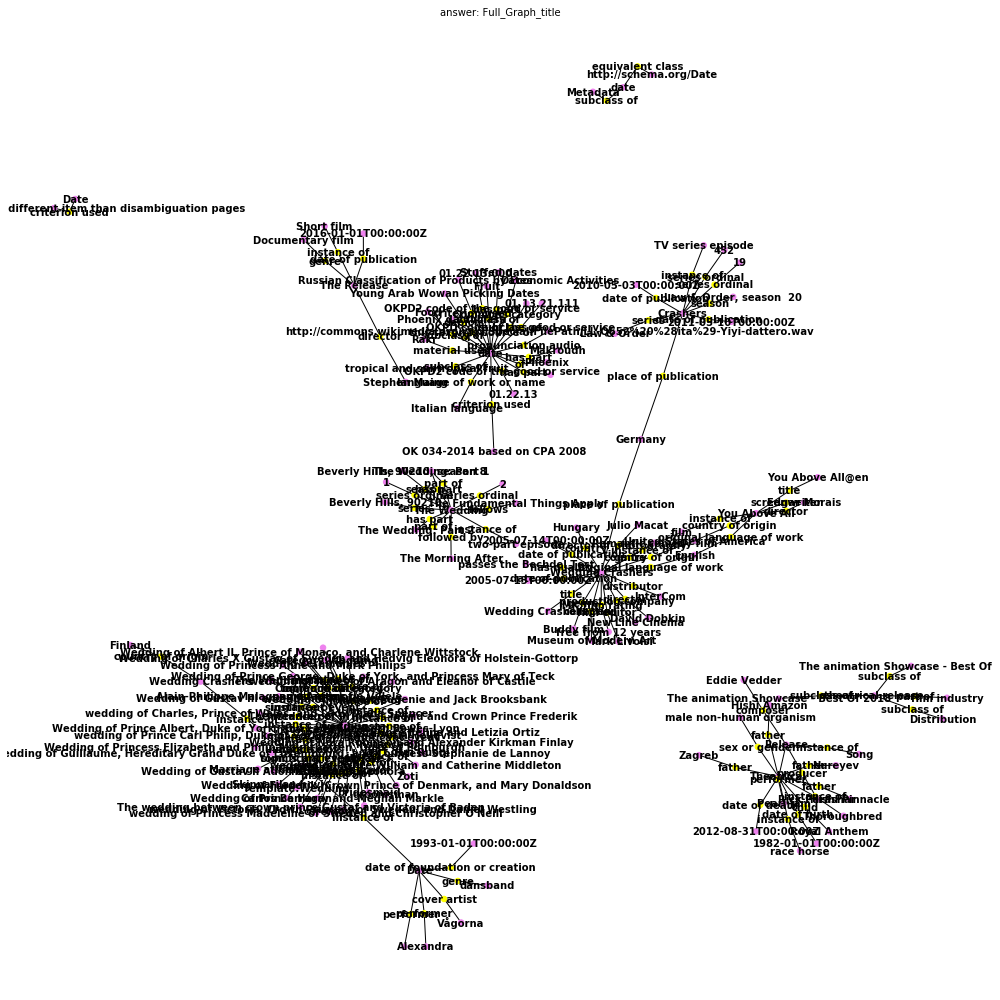

-> predicates_dict: {'P22': 4, 'P1672': 1, 'P180': 1, 'P186': 1, 'P1476': 2, 'P57': 3, 'P175': 3, 'P1013': 3, 'P361': 6, 'P279': 9, 'P31': 36, 'P569': 1, 'P291': 2, 'P577': 5, 'P570': 1, 'P136': 4, 'P571': 1, 'P1545': 4, 'P527': 5, 'P642': 2, 'P344': 1, 'P3245': 1, 'P3250': 2, 'P407': 1, 'P443': 1, 'P495': 3, 'P156': 1, 'P3650': 1, 'P4908': 2, 'P155': 1, 'P1552': 1, 'P793': 3, 'P364': 2, 'P195': 1, 'P373': 2, 'P162': 1, 'P58': 1, 'P17': 1, 'P750': 1, 'P21': 1, 'P1040': 1, 'P1709': 1, 'P910': 1, 'P138': 1, 'P86': 1, 'P272': 1, 'P179': 2, 'P40': 1, 'P1344': 1, 'P736': 1, 'P1424': 1}
-> paths_keywords: (['date', 'was', 'release', 'crashers', 'wedding crashers', 'which date', 'the movie wedding crashers', 'date crashers', 'theatrical release'], {'instance of': [instance of, ['P31']], 'day in year for periodic occurrence': [day in date for periodic occurrence, ['P837']], 'director': [director, ['P57']], 'place of marriage': [place of marriage, ['P2842']]}, [which])
-> Computing possible pat

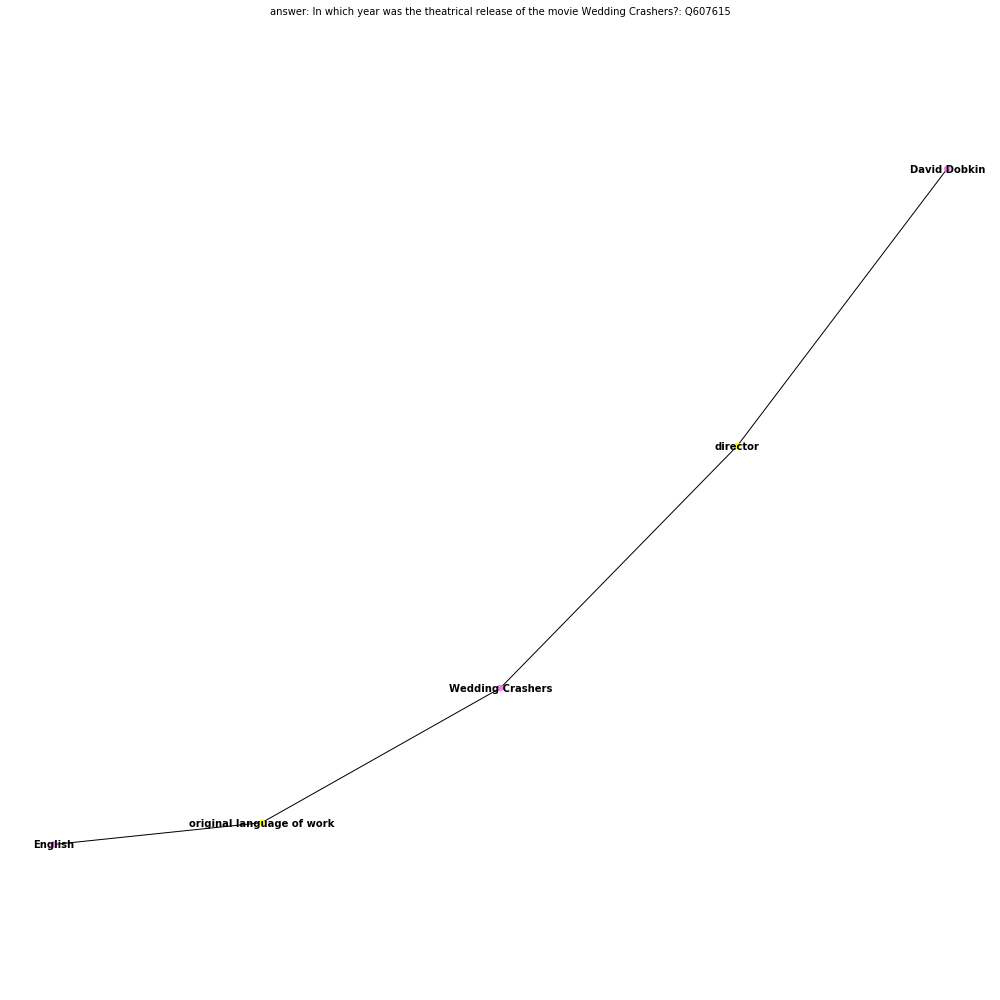

Answer: David Dobkin (Q607615)

Context Question: And who's the actor that plays Rachel McAdams' dad?
User input: And who's the actor that plays Rachel McAdams' dad?
--> Auto correcting question in progress...
-> Auto corrected q_nlp: And who is the actor that plays Rachel McAdams  Dad 
> Processing in conversational context..
-> Replacing pronouns from context..
-> New q_nlp: And who is the actor that plays Rachel McAdams Dad
-> q_themes: ([(the actor, ['Q3041737', 'Q7712313']), (who, ['Q226503', 'Q20656443']), (mcadams, ['Q27614803', 'Q1914948']), (Who, ['Q16977164']), (Dad, ['Q12838408', 'Q1156922']), (rachel mcadams, ['Q190386']), (The Actor, ['Q20496310']), (actor, ['Q33999', 'Q421946'])], [Rachel McAdams Dad, Mcadams ' Dad, Dad Mcadams, And is the actor that plays Rachel, Rachel Mcadams Dad])
-> q_themes_enhanced: [('Rachel McAdams', ['Q190386']), ('Rachel', ['Q13443199']), ('McAdams', ['Q1914948']), ('dad', ['P22']), ("'", ['Q1030011'])]
--> Calculating predicates... (could be l

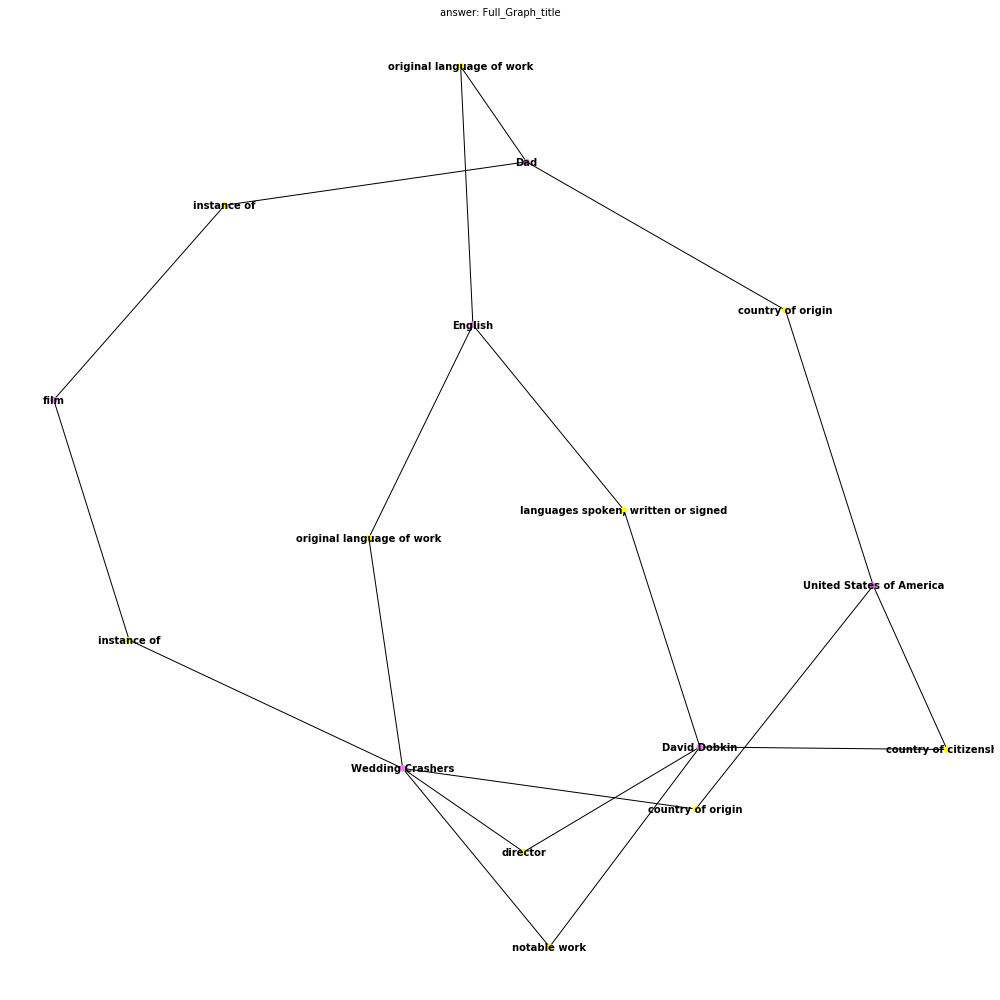

-> predicates_dict: {'P364': 6, 'P57': 11, 'P518': 2, 'P106': 6, 'P1013': 1, 'P571': 1, 'P1441': 1, 'P1412': 1, 'P2453': 3, 'P805': 2, 'P1411': 2, 'P1686': 1, 'P344': 3, 'P291': 2, 'P577': 3, 'P186': 2, 'P800': 3, 'P31': 13, 'P495': 4, 'P195': 2, 'P585': 1, 'P19': 2, 'P734': 4, 'P512': 1, 'P582': 2, 'P69': 2, 'P131': 1, 'P1545': 2, 'P735': 4, 'P217': 1, 'P276': 1, 'P272': 1, 'P1477': 1, 'P279': 1, 'P27': 1, 'P750': 2, 'P58': 2, 'P3650': 1, 'P1552': 1, 'P136': 6, 'P2579': 1, 'P17': 3, 'P725': 1, 'P175': 2, 'P86': 2, 'P170': 1, 'P451': 1, 'P856': 1, 'P910': 1, 'P21': 1, 'P282': 1, 'P373': 1}
-> paths_keywords: (['who', 'dad', 'the actor', 'actor', 'rachel mcadams', 'english', 'wedding crashers', 'david dobkin'], {'original language of work': [original language of work, ['P364']], 'instance of': [instance of, ['P31']], 'playing hand': [playing hand, ['P741']], 'director': [director, ['P57']], 'father': [father, ['P22']], 'dad': [father, ['P22']]}, [who, that])
-> Computing possible paths.

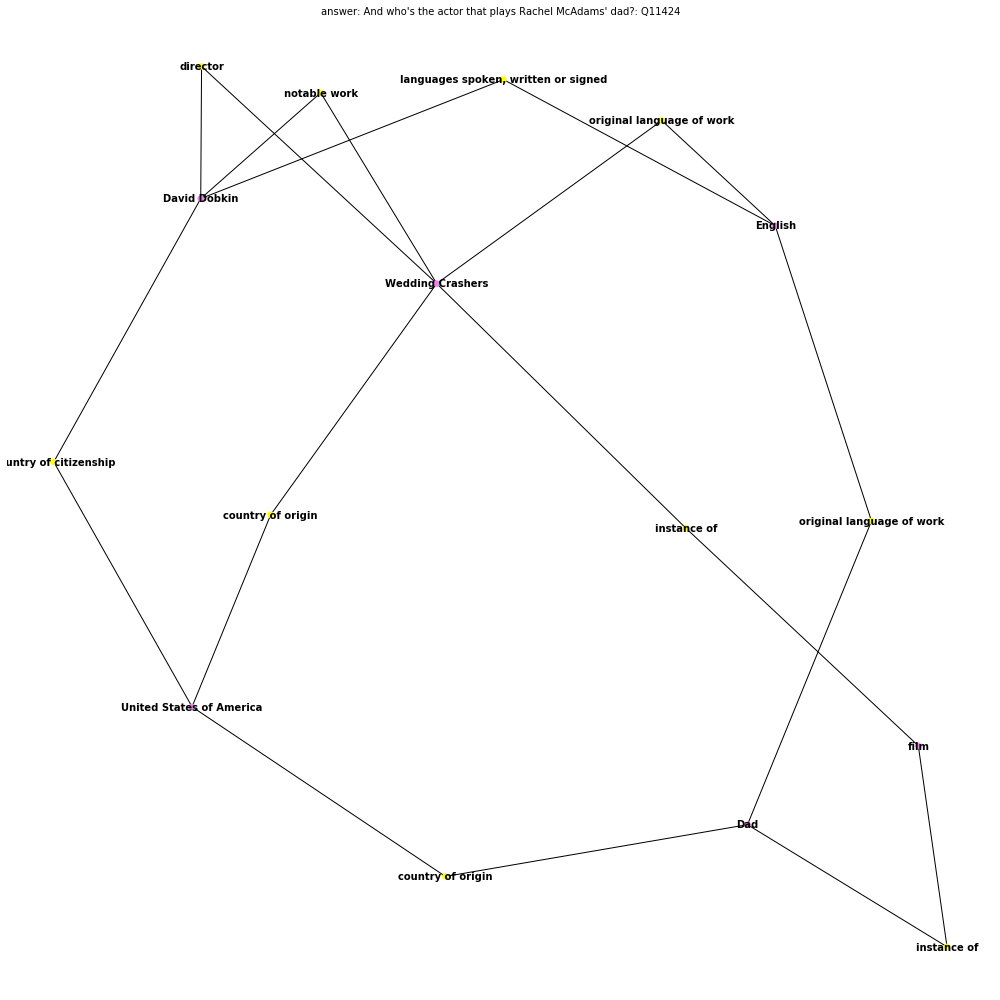

Answer: film (Q11424)

Context Question: Is Isla Fisher in it too?
User input: Is Isla Fisher in it too?
--> Auto correcting question in progress...
-> Auto corrected q_nlp: Is Isla Fisher in it too 
> Processing in conversational context..
-> Replacing pronouns from context..
-> New q_nlp: Is Isla Fisher in English too
-> q_themes: ([(Isla Fisher, ['Q228638'])], [Is Isla])
-> q_themes_enhanced: []
--> Calculating predicates... (could be long.. depends on uncached unpure predicates)
-> q_predicates: [(be, ['P31'])]
-> q_predicates 	Running time is 4.2s
--> Predicates enhanced by previous context: [(original language of work, ['P364']), (be, ['P31']), (country of origin, ['P495']), (country of citizenship, ['P27']), (director, ['P57'])]
----> q_themes in context: ([(Isla Fisher, ['Q228638'])], [Is])
--> Potential meaningful keywords for the sentence: ['Isla Fisher']
---> Meaningful keywords enhanced by previous context: ['Isla Fisher', 'English', 'Wedding Crashers', 'David Dobkin', 'Dad

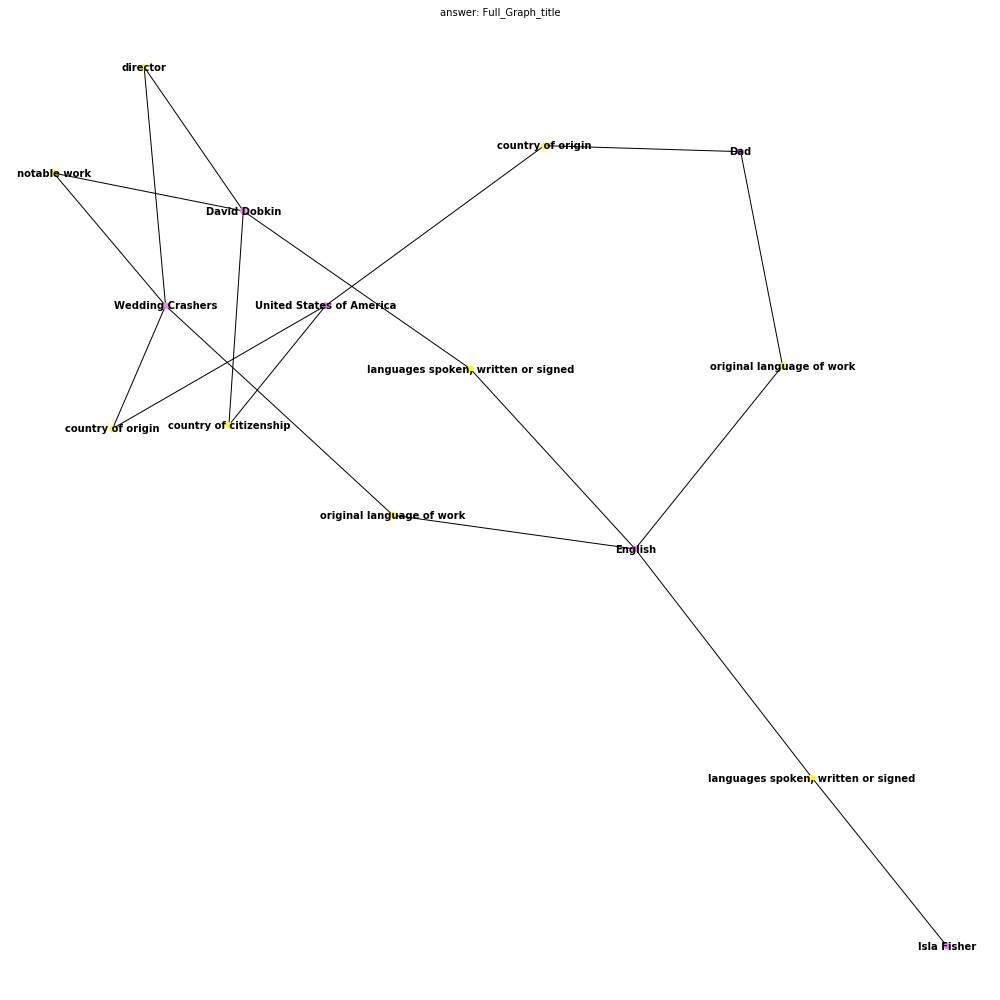

---> Ploting the context graph (PLOT 0)


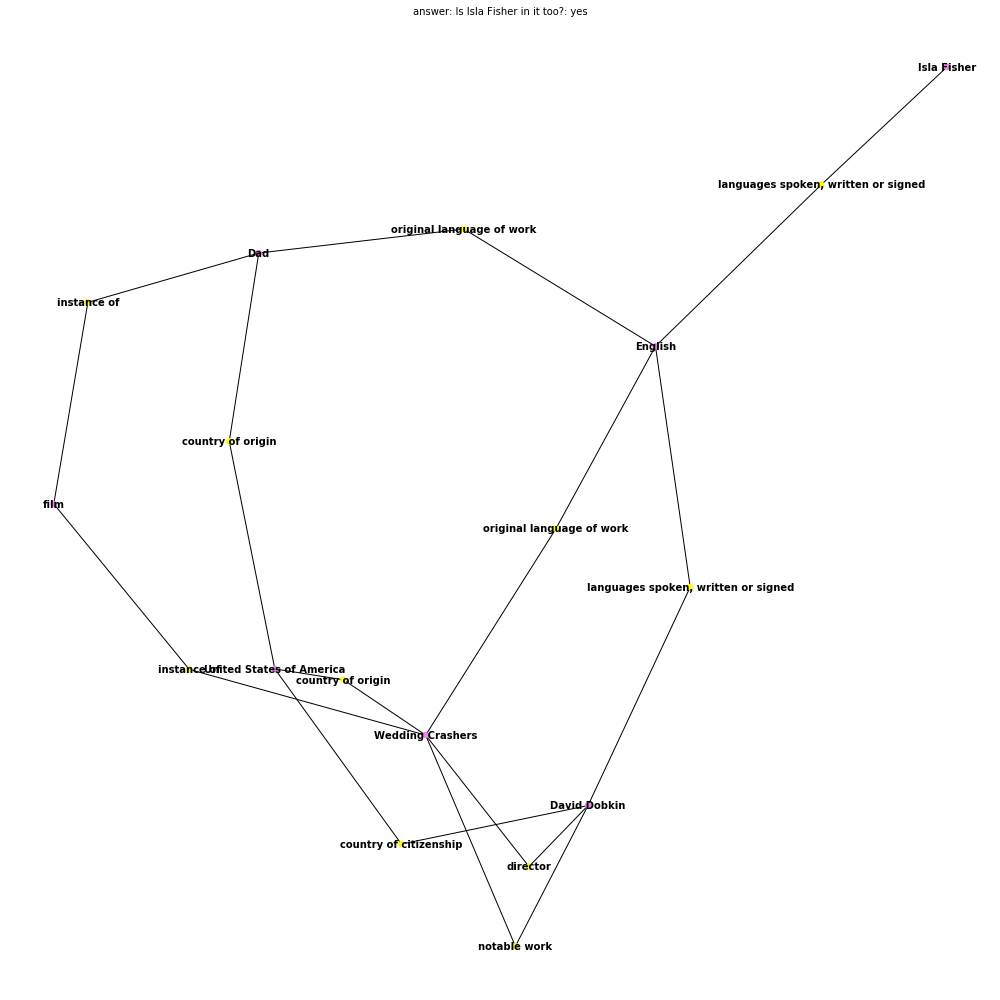

Answer: yes (yes)

Context Question: And what's the director's name?
User input: And what's the director's name?
--> Auto correcting question in progress...
-> Auto corrected q_nlp: And what is the director name 
> Processing in conversational context..
-> Replacing pronouns from context..
-> New q_nlp: And what is the director name
-> q_themes: ([(what, ['Q20656446', 'Q28036789']), (director, ['Q1162163', 'P57']), (name, ['Q82799', 'P2561']), (What, ['Q22073920']), (Director, ['Q23760617', 'Q1047422']), (Name, ['Q13873817', 'Q11236330'])], [the director name, Director Name, Name Director, The Director Name, director name, the Director Name])
-> q_themes_enhanced: [('The Director', ['Q26883246']), ('The Name', ['Q12592731'])]
--> Calculating predicates... (could be long.. depends on uncached unpure predicates)
-> q_predicates: [(be, ['P31']), (director, ['P57', 'P1037']), (name, ['P735', 'P1448'])]
-> q_predicates 	Running time is 7.45s
--> Predicates enhanced by previous context: [(la

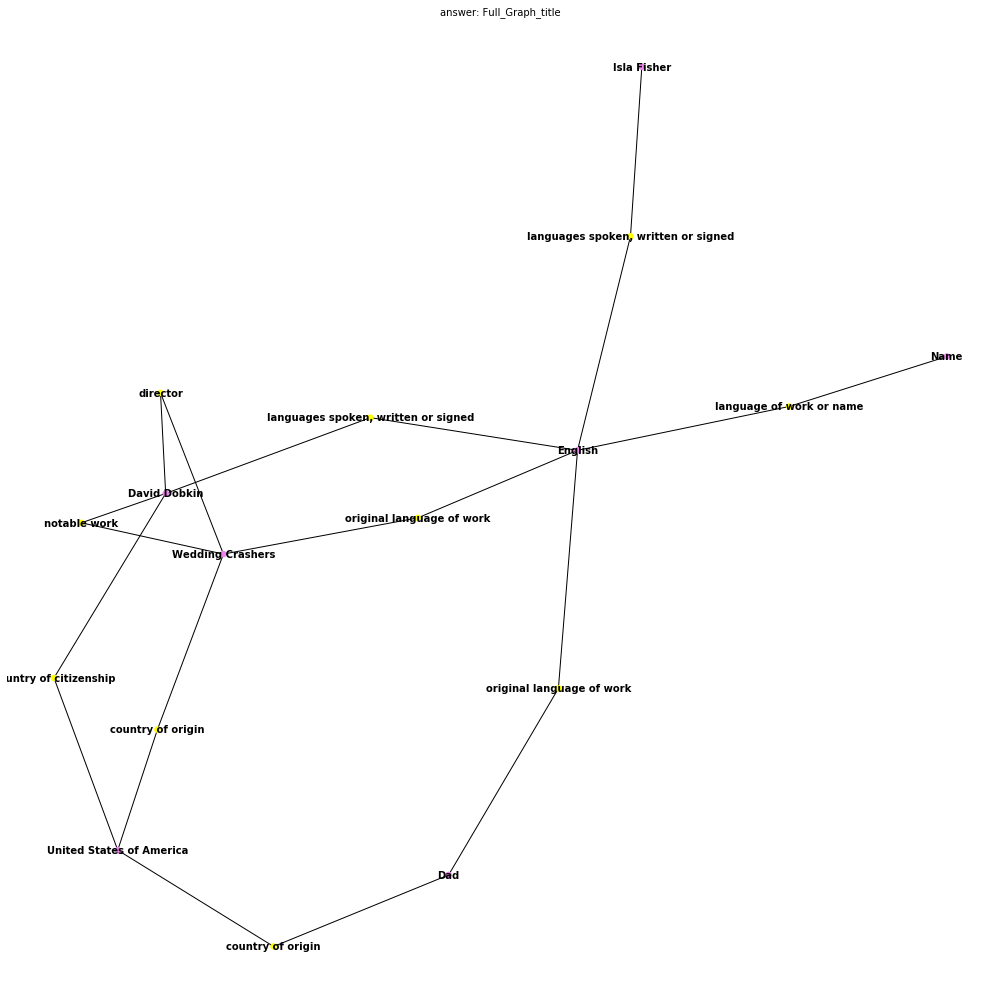

-> predicates_dict: {'P1412': 4, 'P364': 6, 'P57': 11, 'P800': 1, 'P31': 35, 'P495': 7, 'P27': 3, 'P155': 3, 'P156': 3, 'P735': 2, 'P106': 6, 'P734': 2, 'P407': 1, 'P856': 1, 'P344': 3, 'P2453': 3, 'P805': 1, 'P1411': 1, 'P175': 2, 'P1441': 1, 'P518': 1, 'P186': 1, 'P1545': 2, 'P4908': 1, 'P571': 2, 'P131': 1, 'P179': 1, 'P569': 1, 'P291': 2, 'P577': 5, 'P19': 2, 'P580': 1, 'P26': 1, 'P973': 1, 'P361': 1, 'P2521': 3, 'P3650': 1, 'P1552': 1, 'P2388': 3, 'P136': 2, 'P1476': 4, 'P264': 1, 'P279': 4, 'P750': 2, 'P17': 2, 'P195': 2, 'P217': 2, 'P276': 1, 'P725': 3, 'P170': 2, 'P69': 1, 'P272': 1, 'P1040': 1, 'P910': 1, 'P21': 2, 'P373': 1}
-> paths_keywords: (['director', 'name', 'what', 'english', 'isla fisher', 'wedding crashers', 'david dobkin', 'dad', 'film', 'united states of america'], {'languages spoken, written or signed': [languages spoken written or signed, ['P1412']], 'instance of': [instance of, ['P31']], 'director': [director, ['P57']], 'manager/director': [manager  director, [

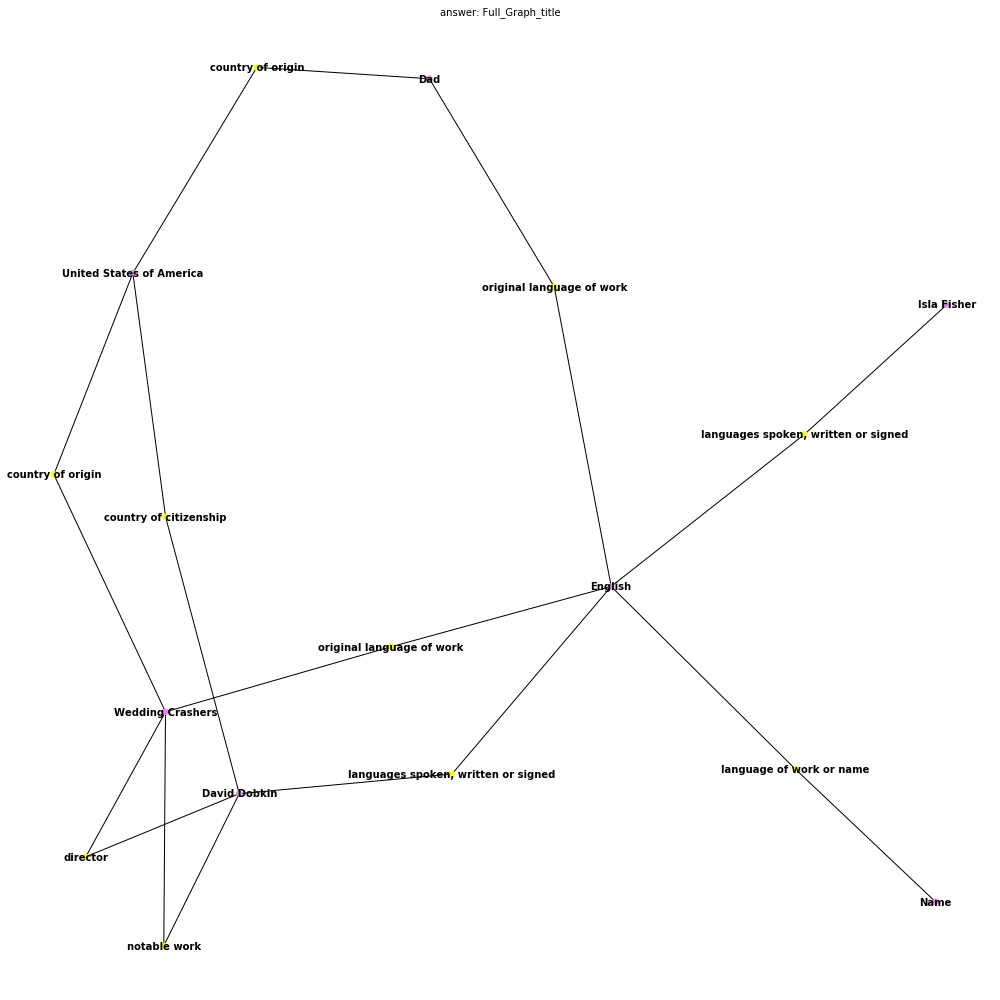

-> predicates_dict: {'P1412': 4, 'P364': 6, 'P57': 11, 'P800': 1, 'P31': 35, 'P495': 7, 'P27': 3, 'P155': 3, 'P156': 3, 'P735': 2, 'P106': 6, 'P734': 2, 'P407': 1, 'P856': 1, 'P344': 3, 'P2453': 3, 'P805': 1, 'P1411': 1, 'P175': 2, 'P1441': 1, 'P518': 1, 'P186': 1, 'P1545': 2, 'P4908': 1, 'P571': 2, 'P131': 1, 'P179': 1, 'P569': 1, 'P291': 2, 'P577': 5, 'P19': 2, 'P580': 1, 'P26': 1, 'P973': 1, 'P361': 1, 'P2521': 3, 'P3650': 1, 'P1552': 1, 'P2388': 3, 'P136': 2, 'P1476': 4, 'P264': 1, 'P279': 4, 'P17': 2, 'P750': 2, 'P195': 2, 'P217': 2, 'P276': 1, 'P725': 3, 'P69': 1, 'P170': 2, 'P272': 1, 'P1040': 1, 'P910': 1, 'P21': 2, 'P373': 1}
-> paths_keywords: (['director', 'name', 'what', 'english', 'isla fisher', 'wedding crashers', 'david dobkin', 'dad', 'film', 'united states of america'], {'languages spoken, written or signed': [languages spoken written or signed, ['P1412']], 'instance of': [instance of, ['P31']], 'director': [director, ['P57']], 'manager/director': [manager  director, [

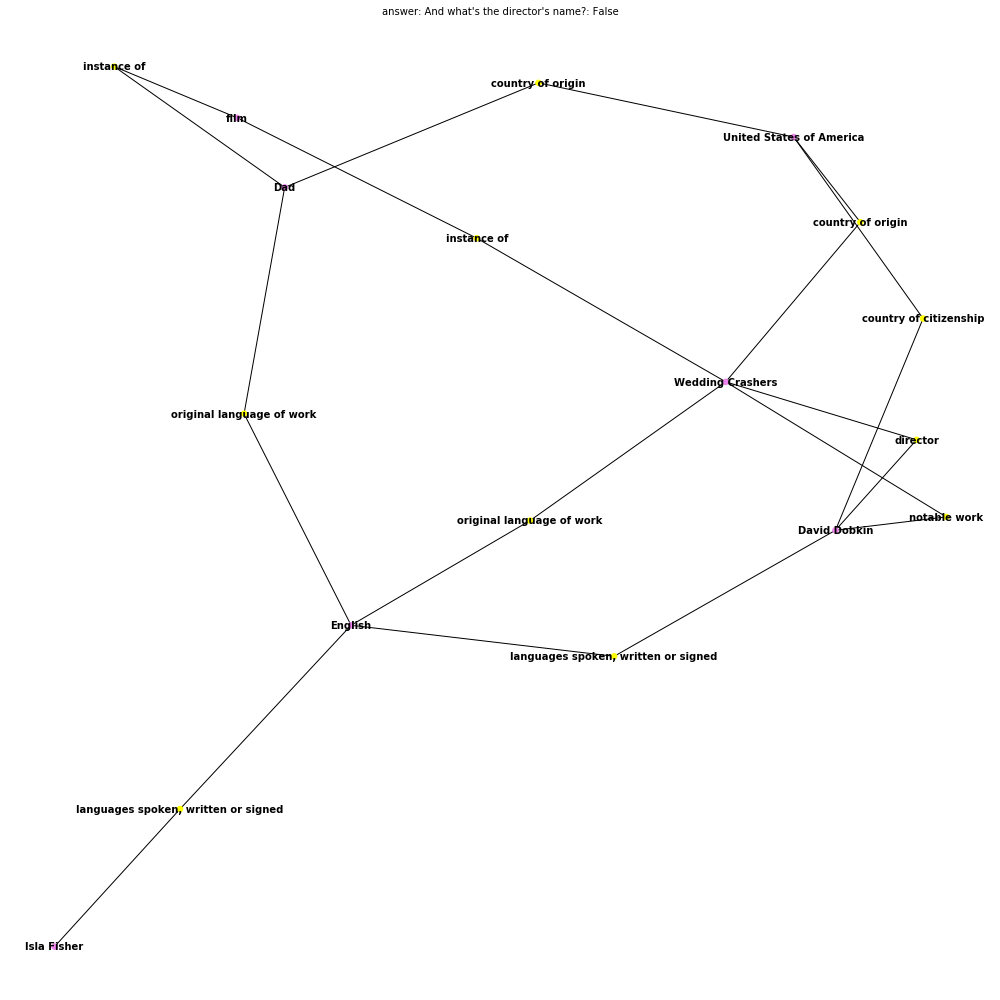

Answer: False
Context Question: Was Dobkin also the director of Shanghai Knights?
User input: Was Dobkin also the director of Shanghai Knights?
--> Auto correcting question in progress...
-> Auto corrected q_nlp: Was Dobkin also the director of Shanghai Knights 
> Processing in conversational context..
-> Replacing pronouns from context..
-> New q_nlp: Was Dobkin also the director of Shanghai Knights
-> q_themes: ([(Shanghai, ['Q8686', 'Q582284']), (Knights, ['Q20875700', 'Q18614992']), (Dobkin, ['Q21502078', 'Q1233285']), (the director, ['Q50078600']), (Shanghai Knights, ['Q595595']), (The Director, ['Q42531725', 'Q26883246']), (director, ['Q1162163', 'P57'])], [Was Dobkin, Dobkin also the director of Shanghai, dobkin])
-> q_themes_enhanced: []
--> Calculating predicates... (could be long.. depends on uncached unpure predicates)
-> q_predicates: [(be, ['P31']), (director, ['P57', 'P1037'])]
-> q_predicates 	Running time is 7.46s
--> Predicates enhanced by previous context: [(languages

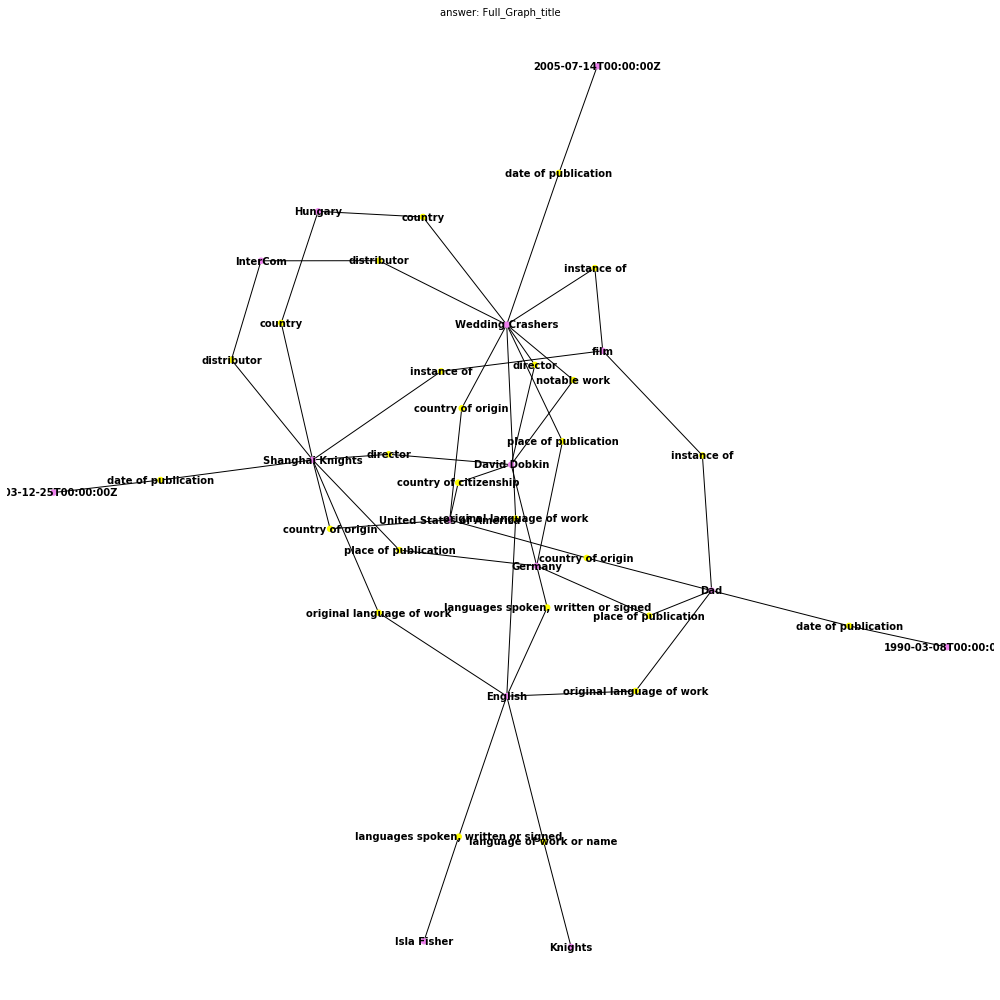

---> Ploting the context graph (PLOT 0)


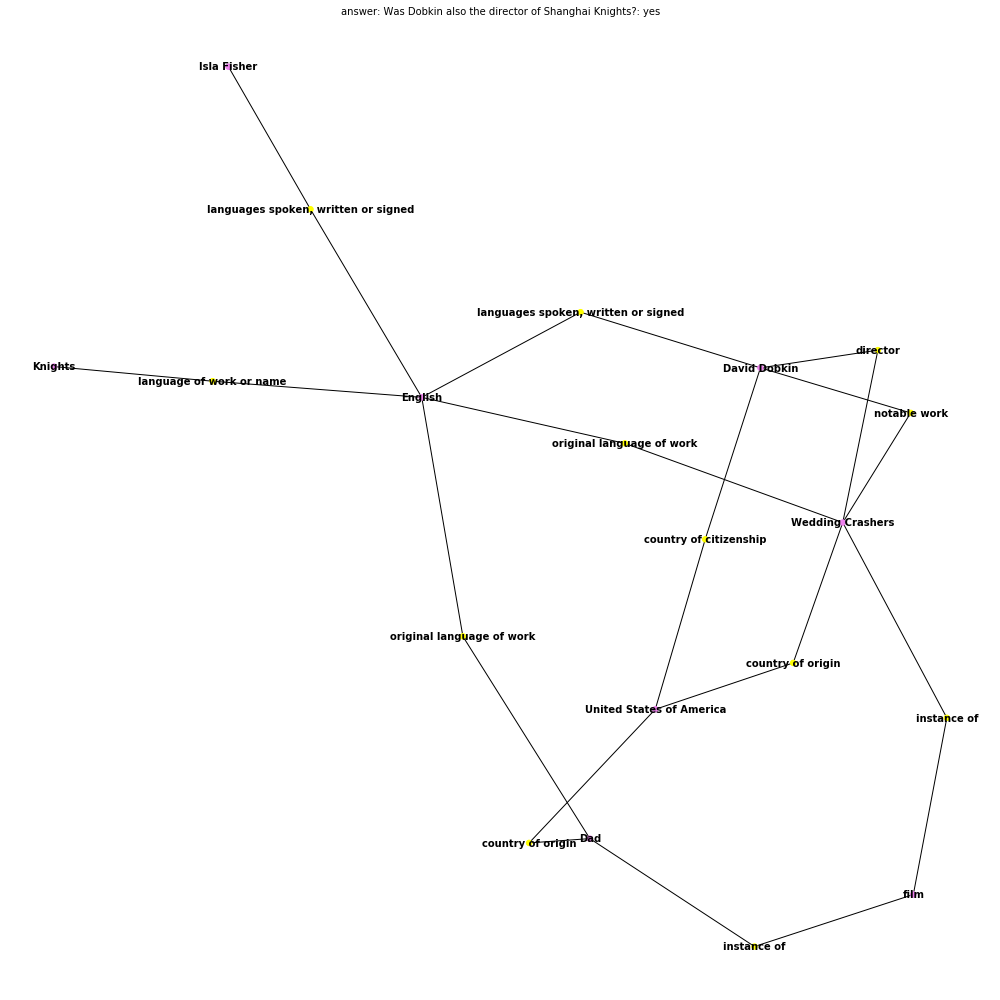

Answer: yes (yes)



In [163]:
#conversation_questions = [
#    "Which actor voiced the Unicorn in The Last Unicorn?",
#    "And Alan Arkin was behind..",
#    "Who did the score?",
#    "So who performed the songs?",
#    "Genre of this band's music?",
#    "By the way, who was the director?",
#]

conversation_questions = [
    "In which year was the theatrical release of the movie Wedding Crashers?",
    "And who's the actor that plays Rachel McAdams' dad?",
    "Is Isla Fisher in it too?",
    "And what's the director's name?",
    "Was Dobkin also the director of Shanghai Knights?"
]

def answer_conversation(questions, answer_context=False, context_graph=False, start_from=0, end_at=6):
    conversation_history = []
    for i_q,question in enumerate(questions):
        if i_q >= start_from and i_q<=end_at:
            if i_q == 0:
                answer_context,context_graph = answer_question(question ,previous_answer=answer_context, previous_graph=context_graph, verbose=True, timer=True, show_graph=True)
                #break
            elif context_graph:
                #break
                print("Context Question:",question)
                answer_context,context_graph = answer_question(question,previous_answer=answer_context, previous_graph=context_graph, verbose=True, timer=True, show_graph=True, aggressive=False)
            else:
                print("NO CONTEXT ERROR")
                break
        
        conversation_history.append([answer_context,context_graph])
        if answer_context: print("Answer:",convert_to_literal(get_wd_label(answer_context[0][0])), "("+str(answer_context[0][0])+")\n")
        else: print("Answer:",answer_context)
        #break
    return conversation_history

#first_answer = conversation_history[0][0]
#first_context = conversation_history[0][1]
#conversation_history_2 = answer_conversation(conversation_questions,answer_context=first_answer,context_graph=first_context, start_from=1, end_at=1)

#second_answer = conversation_history_2[1][0]
#second_context = conversation_history_2[1][1]
#conversation_history_3 = answer_conversation(conversation_questions,answer_context=second_answer,context_graph=second_context, start_from=2, end_at=2)

#third_answer = conversation_history_3[2][0]
#third_context = conversation_history_3[2][1]
#conversation_history_4 = answer_conversation(conversation_questions,answer_context=third_answer,context_graph=third_context, start_from=3, end_at=6)

#conversation_history = answer_conversation(conversation_questions,answer_context=False,context_graph=False, start_from=0, end_at=6)


In [ ]:
#conversation_history

In [ ]:
#get_nlp("cast member").similarity(get_nlp("behind"))
#get_wd_label("Q30060419")

In [ ]:
#for ch in conversation_history:
#    if ch[0]:
#        print("ch[0]",ch[0][0])
#        plot_graph(ch[1], "file_name_context_graph", "Context_Graph_title")

In [ ]:
def generate_answer_sentence(answer, question, model, tokenizer, verbose=False, k_spo=False, g_autocorrect=True):
    if answer:
        answer_paths = answer[1:]
        answer_best_path = answer[1]
        answer_fact = answer[0][0]
        #if verbose: print("answer_paths",answer_paths)
        #if verbose: print("answer_fact",answer_fact)
        
        if verbose: print("Answer:",get_wd_label(answer_fact), "("+str(answer_fact)+")")
        #if verbose: print("Paths:",[[get_wd_label(e) for e in row] for row in answer_paths][0])
        if verbose: print("Best path:",[get_wd_label(e) for e in answer_best_path])
            
        if k_spo:
            spo_k = k_spo
        else:
            spo_k = count_hops(answer_best_path,question)
        
        if verbose: print("spo_k",spo_k)
            
        if spo_k>1:
            last_element = spo_k*3-1
        else:
            last_element = spo_k*3
        
        answer_best_path_spos = [get_wd_label(e) for e in answer_best_path][:last_element]
        #print("answer_best_path_spos",answer_best_path_spos)
        
        raw_list = []
        sentence_spliters = []
        for i_e,e in enumerate(answer_best_path_spos):
            e = convert_to_literal(e)
            if i_e == 0:
                raw_list.append('[CLS]')
                if is_timestamp(e): raw_list.append('[MASK]')
                raw_list.append(e)
                raw_list.append('[MASK]')
            elif i_e == len(answer_best_path_spos)-1:
                if is_timestamp(e): raw_list.append('[MASK]')
                raw_list.append(e)
                raw_list.append('[MASK]')
                raw_list.append('[SEP]')
            elif spo_k > 1 and i_e % 3 and i_e != 1:
                sentence_spliters.append(len(raw_list)+2)
                #raw_list.append('[MASK]')
                if is_timestamp(e): raw_list.append('[MASK]')
                raw_list.append(e)
                raw_list.append('[MASK]')
                #raw_list.append('[MASK]')
                #raw_list.append('[SEP]')
            else:
                #print("e",e)
                get_nlp(e)
                if e.find("is") == -1:
                    raw_list.append('[MASK]')
                raw_list.append(e)
                raw_list.append('[MASK]')
                
    
        #print("answer_best_path_to_complete",answer_best_path_to_complete)
        raw_text = " ".join(raw_list)
        if verbose: print("Best answer path selected for spo_k",raw_text)
            
        #return "lol"
    
        tokenized_text = tokenizer.tokenize(raw_text)
        #print("tokenized_text",tokenized_text)
    
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        #print("indexed_tokens",indexed_tokens)
        
        segments_ids = [0] * len(tokenized_text)
        
        #print("segments_ids",segments_ids)
        
        if spo_k > 2:
            #print("sentence_spliters",sentence_spliters)
            previous_position = 0
            for i_ss, ss in enumerate(sentence_spliters):
                for i_p in range(ss+1, len(segments_ids)):
                    #print(i_p)
                    segments_ids[i_p] = i_ss+1
                #print(i_ss, ss)
                #segments_ids[previous_position:ss] = [i_ss] * int(ss)-int(previous_position)
                #previous_position = ss
            
            #print("segments_ids",segments_ids)
        else:
            segments_ids = [0] * len(tokenized_text)
        
        #print("sentence",segments_ids)
        
        #return False
    
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])
    
        model.eval()
    
        tokens_tensor = tokens_tensor.to(torch.device('cuda:0'))
        segments_tensors = segments_tensors.to(torch.device('cuda:0'))
        model.to(torch.device('cuda:0'))
    
        masked_indices = [i for i, x in enumerate(tokenized_text) if x == "[MASK]"]# or x == "[CLS]"]
        masked_indices_raw = [i for i, x in enumerate(raw_list) if x == "[MASK]"]# or x == "[CLS]"]
    
        with torch.no_grad():
            outputs = model(tokens_tensor, token_type_ids=segments_tensors)
            predictions = outputs[0]
    
        completed_text = raw_list.copy()
        #print("source:", " ".join(completed_text))
    
        for i_mi, masked_index in enumerate(masked_indices):
            predicted_index = torch.argmax(predictions[0, masked_index]).item()
            predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
            completed_text[masked_indices_raw[i_mi]] = predicted_token
        
        completed_text = " ".join(completed_text).replace("[CLS]","").replace("[SEP]","").replace("/","").replace(" .",". ")#[6:-5]
        completed_text = re.sub(r'\s*,\s*', ', ', completed_text)
        completed_text = re.sub(r'\s*, ,\s*', ', ', completed_text)
        completed_text = re.sub(r'\s*\.\s*', '. ', completed_text)
        completed_text = re.sub(r'\s*\(\s*', ' (', completed_text)
        completed_text = re.sub(r'\s*\)\s*', ') ', completed_text)
        completed_text = re.sub(r'\s* ; \s*', '; ', completed_text)
        completed_text = re.sub(r'\s* : \s*', ': ', completed_text)
        completed_text = re.sub(r'\s* - \s*', ', ', completed_text)
        
        if completed_text[len(completed_text)-2:] == "; ": completed_text = completed_text[:-2]+"."
        if completed_text[len(completed_text)-1:] == " ": completed_text = completed_text[:-1]
        if completed_text[0] == " ": completed_text = completed_text[1:]
            
        if verbose: print("Spot filled:",completed_text)
        if not g_autocorrect:
            return [completed_text,completed_text]
        
        corrected_completed_text = corrector.correct(completed_text)
    
        if verbose: print("\n\nBest Answer sentence for spo_k",spo_k,"and corrected:",corrected_completed_text[0]["sequence"])
        if corrected_completed_text[0]["sequence"].find("/") != -1:
            return [completed_text, corrected_completed_text[0]["sequence"]]
        else:
            return [corrected_completed_text[0]["sequence"], completed_text]
    else:
        return False

#print("--> Generating complete sentence from answer...")
#question = "who is the wife of barrack obama"
#question = "which actor voiced the unicorn in the last unicorn?"
#question = "when did the the first star wars released"
#question = "Where did Michelle Obama and Barrack Obama get married?"

#answer = answer_question(question, verbose=True, timer=True, show_graph=True)
#print(answer)

#question = "And Alan Arkin was behind.."
#answer = conversation_history[1][0]

#generate_answer_sentence(answer, question, bert_model, bert_tokenizer, verbose=True, k_spo=False)[0]


In [ ]:
#import torch.nn.functional as functional
import random

def generate_next_word(input_text, model, tokenizer, threshold=0.7):
    input_ids = torch.tensor(tokenizer.encode(input_text)).unsqueeze(0)
    outputs = model(input_ids)[0][:, -1]
    possibilities = torch.nn.functional.softmax(outputs, dim=-1).squeeze()
    indexes = torch.argsort(possibilities, descending=True)
    results = []
    proba_sum = 0.0
    
    for idx in indexes:
        results.append(idx)
        proba_sum += possibilities[idx]
        if proba_sum > threshold:
            pred_idx = indexes.new_tensor([random.choice(results)])
            break
    predication = tokenizer.convert_ids_to_tokens(int(pred_idx))
    return tokenizer.convert_tokens_to_string(predication)

def extend_sentence(sentence, gpt2_model, gpt2_tokenizer, verbose=False, k_sentences=False):
    BREAKING_TOKENS = [".","!","?"]
    
    #tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    #model = GPT2LMHeadModel.from_pretrained("gpt2")
    #gpt2_modelpath = "gpt2-large"
    #gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_modelpath)
    #gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_modelpath)
    
    sentence += generate_next_word(sentence, gpt2_model, gpt2_tokenizer, threshold=0.7)
    done = False
    if k_sentences:
        k_sentences -= 1
        while not done:
            
            next_word = generate_next_word(sentence, gpt2_model, gpt2_tokenizer, threshold=0.7)
            if next_word == "\n": continue
            #print("next_word",next_word)
            sentence += next_word
            if verbose: print("\r\t>>> Building sentence: {}".format(sentence), end=' ')
            for bt in BREAKING_TOKENS:
                if next_word.find(bt) != -1: 
                    #print("bt",bt)
                    k_sentences -= 1
                    break
            if k_sentences<0:
                break
                done=True
        
        #print("k_sentences",k_sentences)
            
    #sentence.replace("\\","").replace("\" ","\"").replace("\" \"","\"").replace("\\\'","\'").replace("\\n","").replace("\'","'")
    #if sentence.count("\"") == 1: sentence.replace("\"","")
            
    return sentence

#sentence = "Yes, and"
#extend_sentence(sentence, gpt2_model, gpt2_tokenizer, verbose=True, k_sentences=1)

#del gpt2_tokenizer
#del gpt2_model

In [ ]:
#def answer_conversation(questions, answer_context=False, context_graph=False, start_from=0, end_at=6):
#    conversation_history = []
#    for i_q,question in enumerate(questions):
#        if i_q >= start_from and i_q<=end_at:
#            if i_q == 0:
#                answer_context,context_graph = answer_question(question ,previous_answer=answer_context, previous_graph=context_graph, verbose=True, timer=True, show_graph=True)
#                #break
#            elif context_graph:
#                #break
#                print("Context Question:",question)
#                answer_context,context_graph = answer_question(question,previous_answer=answer_context, previous_graph=context_graph, verbose=True, timer=True, show_graph=True, aggressive=False)
#            else:
#                print("NO CONTEXT ERROR")
#                break
#        
#        conversation_history.append([answer_context,context_graph])
#        if answer_context: print("Answer:",convert_to_literal(get_wd_label(answer_context[0][0])), "("+str(answer_context[0][0])+")\n")
#        #break
#    return conversation_history


#bert_modelpath = "bert-large-uncased"
#bert_model = BertForMaskedLM.from_pretrained(bert_modelpath)
#bert_tokenizer = BertTokenizer.from_pretrained(bert_modelpath)
#
#gpt2_modelpath = "gpt2-xl"
#gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_modelpath)
#gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_modelpath)

In [ ]:
def get_full_answer(question, answer_context=False, context_graph=False, verbose=False, timer=False, show_graph=False, k_spo=False, k_chatty=1, g_autocorrect=True):
    BREAKING_TOKENS = [".","!","?"]
    
    answer_context,context_graph = answer_question(question,
                                                   previous_answer=answer_context, previous_graph=context_graph,
                                                   verbose=verbose, timer=timer, show_graph=show_graph, g_autocorrect=g_autocorrect)
    
    if answer_context:
        if verbose: print("\nGET_FULL_ANSWER - building sentence from:",answer_context[1])
        answer_sentence = generate_answer_sentence(answer_context, question, bert_model, bert_tokenizer, verbose=verbose, k_spo=k_spo, g_autocorrect=g_autocorrect)
        if answer_sentence[0][-1] in BREAKING_TOKENS and k_chatty>0:
            answer_sentence_no_ending = answer_sentence[0][:-1]
        else: answer_sentence_no_ending = answer_sentence[0]
        
        if k_chatty>0:
            if verbose: print("\nGET_FULL_ANSWER - extending sentence with:",answer_sentence_no_ending)
            answer_sentence_extended = extend_sentence(answer_sentence_no_ending, gpt2_model, gpt2_tokenizer, verbose=verbose, k_sentences=k_chatty)
        else: answer_sentence_extended = answer_sentence_no_ending
        
        return answer_sentence_extended, answer_context, context_graph
    
    else:
        return "I don't know.", False, False
     

#question = "Who is the wife of Barack Obama?"
#print("Asking:", question)
#answer = get_full_answer(question, answer_context=False, context_graph=False, verbose=True, timer=True, show_graph=True, k_spo=2, k_chatty=2, g_autocorrect=True)    
#print("\n\n\nGraphQA answer:",answer[0])

In [ ]:
#question_2 = "When did they marry?"
#answer_2 = get_full_answer(question_2, answer_context=answer[1], context_graph=answer[2], verbose=True, timer=True, show_graph=True, k_spo=2, k_chatty=1, g_autocorrect=True)    
 #answer_sentence_extended, answer_context, context_graph

In [ ]:
#answer

In [ ]:
#conversation_history[1][0]

In [ ]:
questions = [
    "Which actor voiced the Unicorn in The Last Unicorn?",
    "Who voiced the Unicorn in The Last Unicorn?",
    "When was the publication date of the movie Grease?",
    "When was produced the first Matrix movie?",
    "Which is the nation of Martha Mattox",
    "Where did roger marquis die",
    "Who is the author that wrote the book Moby Dick",
    "Who is the wife of Barack Obama?",
    "of what nationality is ken mcgoogan",
    
    "When did the movie Grease come out?",
    "which stadium do the wests tigers play in",
    
    "What is the name of the writer of The Secret Garden?",
    "whats the name of the organization that was founded by  frei otto",
    
    "Which genre of album is harder.....faster?",
    "Which genre of album is Harder ... Faster?",
    
    "Which equestrian was is in dublin ?",
    "how does engelbert zaschka identify	",
    "Who influenced michael mcdowell?",
    "what does  2674 pandarus orbit"
            ]

#for i_q, question in enumerate(questions):
#    if i_q >= 0:
#        answer,context_graph = answer_question(question, verbose=True, timer=True, show_graph=True)
#        if answer:
#            print("Answer:",convert_to_literal(get_wd_label(answer[0][0])), "("+str(answer[0][0])+")\n")

In [ ]:
def get_top_1_answer(answer_convex,question):
    time_sensitive = False
    if 'when' in [t.lower_ for t in get_nlp(question) if t.tag_=="WRB"]: time_sensitive = True

    top_1_answer = answer_convex[0]["answer"]

    if time_sensitive:
        for answer in answer_convex:
            if is_timestamp(answer["answer"]):
                top_1_answer = answer["answer"]
                break
                
    return top_1_answer

#top_1_answer = get_top_1_answer(answer_convex, question)
#print("top_1_answer",top_1_answer)

In [ ]:
def standardize_graph(graph):
    this_graph = graph.copy()
    for n in this_graph.nodes():
        n_pos = n.find("-")
        n_name = n
        if n_pos != -1: n_name = n[:n_pos]
        this_graph.nodes[n]["name"] = get_wd_label(n_name)
        this_graph.nodes[n]["weight"] = 1
        
    return this_graph

In [ ]:
### try with Convex
#import convex as cx

conversation_questions = [
    "Which actor voice the Unicorn in The Last Unicron?",
    "And Alan Arkin was behind..",
    "Who did the score?",
    "So who performed the songs?",
    "Genre of this band's music?",
    "By the way, who was the director?"
]

def try_conversation_with_convex(questions, answer_convex=False, context_graph=False):
    frontier_detection=[0.9, 0.6, 0.3] #random_access
    answer_detection=[0.9, 0.1] #total_distance_qa_nodes, total_distance_frontiers
    frontiers=3

    for i_q,question in enumerate(questions):
        turn = i_q+1
        if i_q >= 1:
            if i_q == 0:
                answer_convex,context_graph = answer_question(question ,previous_answer=answer_convex, previous_graph=context_graph, verbose=True, timer=True, show_graph=True)
                if answer_convex: print("Answer:",convert_to_literal(get_wd_label(answer_convex[0][0])), "("+str(answer_convex[0][0])+")\n")
            elif context_graph:
                print("Context Question:",question)
                answer_convex, context_graph = cx.answer_follow_up_question(question, turn, context_graph, frontier_detection+answer_detection, frontiers)
                context_graph = standardize_graph(context_graph)
                top_1_answer = get_top_1_answer(answer_convex[1:],question)
                plot_graph(context_graph, "file_name_context_graph", "Context_Graph_title")
                if top_1_answer: print("Answer:",convert_to_literal(get_wd_label(top_1_answer)), "("+str(top_1_answer)+")\n")
                for ac in answer_convex:
                    print(ac)
                print("\n")
            else:
                print("NO CONTEXT ERROR")
                break


#try_conversation_with_convex(conversation_questions,answer=answer,context_graph=context_graph)

        

In [ ]:
#import convex as cx
#conversation_questions = [
#    "Who is the wife of Barack Obama?",
#    "Where did they marry?"
#]
#answer = "Q13133"
#answer_context=[[answer]]
#context_graph=nx.Graph()
#context_graph.add_node(answer, name=get_wd_label(answer), type='entity', turn=1, weight=1, qa=True)
#frontier_detection=[0.9, 0.6, 0.3] #random_access
#answer_detection=[0.9, 0.1] #total_distance_qa_nodes, total_distance_frontiers
#frontiers=3
#turn=2
#question = conversation_questions[1]
#answer_context,context_graph = answer_question(conversation_questions[1] ,previous_answer=answer_context, previous_graph=context_graph, 
#                                               verbose=True, timer=True, show_graph=True)

#answer_convex, context_graph = cx.answer_follow_up_question(question, turn, context_graph, frontier_detection+answer_detection, frontiers)
#context_graph = standardize_graph(context_graph)
##top_1_answer = get_top_1_answer(answer_convex[0:],question)
#plot_graph(context_graph, "file_name_context_graph", "Context_Graph_title")
#if top_1_answer: print("Answer:",convert_to_literal(get_wd_label(answer_convex[0]["answer"])), "("+str(answer_convex[0]["answer"])+")\n")
#for ac in answer_convex:
#    print(ac)
#print("\n")
#

In [ ]:
# TODO try decomposing the question into subquestions (multi-hop into single-hop SPO)

#test_nlp_1 = get_nlp("What is the name of Metallica's first album")
#test_nlp_2 = get_nlp("What year did the TV show Arrested Development first air?")
#test_nlp_3 = get_nlp("How many Back to the Future movie are there?")
#test_nlp_4 = get_nlp("what is the name of an episode of life on a stick")
#test_nlp_5 = get_nlp("Which album is a death metal album?")
#test_nlp_6 = get_nlp("Star wars: the first order, the movie.")
#test_nlp_7 = get_nlp("What is the first star wars movie?")
#
#def is_reasoning_question(nlp_question):
#    print(nlp_question)
#    for e in nlp_question:
#        print(e,e.tag_,e.pos_,list(e.children))
#    print("\n")
#    
#is_reasoning_question(test_nlp_1)
#is_reasoning_question(test_nlp_2)
#is_reasoning_question(test_nlp_3)
#is_reasoning_question(test_nlp_4)
#is_reasoning_question(test_nlp_5)
#is_reasoning_question(test_nlp_7)